# Clustering Pipeline
- Clustering will be applied only on Pre period, considering both Intervention and Control.
- All housholds must have 100% information of their socioeconomic data; so the later feature comparison is effective.


This code has the following structure

1. **Load socioeconomic features**
2. **Load half-hour readings**
3. **Spectral Clustering for Outlier detection **

*   3.1 Define Spectral Clustering Function
*   3.2 Run Spectral Clustering on Pre Masked - First Iteration
*   3.3 Remove Outliers with Spectral Clustering - Second Iteration
*   3.4 Remove Outliers with Spectral Clustering - Third Iteration

4. **Clustering**

*   4.1 PC Loadings
*   4.2 Custom Measure function for Clustering evaluation
*   4.3 Iterate over many clusters and components configurations

5. **Generate Clustering for Components XX and Clusters YY (Sankey Diagram)**

*   5.1 Generate 1 plot per highlighted Cluster

6. **Output a .csv with ANON_ID Clusters... and Socio_df**




# Libraries & Packages

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.sparse.linalg import eigsh
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import os

# Load Data

In [2]:
# Working with Google Colab
file_path = ""

## 1. Load socioeconomic features

In [3]:
# 1 --- Load socioeconomic data ---
socio_file = "socioEcodata.csv"
socio_df = pd.read_csv(os.path.join(file_path, socio_file))

# Drop unneeded columns
cols_to_drop = [
    'ESTIMATED_CONSUMPTION_ELEC_DAY',
    'ESTIMATED_CONSUMPTION_ELEC_NIGHT',
    'ESTIMATED_CONSUMPTION_TOTAL'
]
socio_df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Rename HASH_KEY -> ANON_ID
if 'HASH_KEY' in socio_df.columns:
    socio_df.rename(columns={'HASH_KEY': 'ANON_ID'}, inplace=True)

# 2 --- Remove missing data ---

socio_df.dropna(inplace=True)

# Remove 'Unknown'
features = [
    'AGE_GROUP', 'INCOME_CATEGORY', 'HOUSEHOLD_OCCUPANCY', 'CHILDREN_AT_HOME',
    'HOUSEHOLD_SIZE', 'NUMBER_OF_BEDROOMS', 'OCCUPATION', 'EMPLOYMENT_STATUS',
    'HIGHEST_QUALIFICATION', 'HOME_OWNERSHIP', 'HOME_TYPE', 'SOCIAL_GRADE',
    'TARIFF_GROUP', 'HOME_VALUE'
]
print("Lets remove all housholds whith features that take value as Unknown")
print(f"Socio-economic data shape before cleaning: {socio_df.shape}")
mask_no_unknown = (socio_df[features] != 'Unknown').all(axis=1)
socio_df = socio_df[mask_no_unknown].copy()
print(f"Socio-economic data shape after cleaning: {socio_df.shape}")

# 3 ---  Order feature values ---
age_group_order = ['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+']
income_category_order = [
    '0-9,999', '10,000-19,999', '20,000-29,999', '30,000-39,999',
    '40,000-49,999', '50,000-74,999', '75,000-99,999', '100,000+']
household_occupancy_order = ['Single Adult Household', 'Couple Household', 'Multi-Occupancy Household']
children_at_home_order = ['0', '1', '2+']
household_size_order = ['1', '2', '3-4', '5+']
number_of_bedrooms_order = ['1', '2', '3', '4', '5+']
highest_qualification_order = ['GCSE Equivalent', 'A Level Equivalent', 'Secondary Education or Less', 'University Degree or Higher']
home_value_order = ['0-100k', '100-150k', '150-250k', '250-500k', '500k+']
social_grade_order = ['Social grade A', 'Social grade B', 'Social grade C1', 'Social grade C2', 'Social grade D']

feature_orders = {
    'AGE_GROUP': age_group_order,
    'INCOME_CATEGORY': income_category_order,
    'HOUSEHOLD_OCCUPANCY': household_occupancy_order,
    'CHILDREN_AT_HOME': children_at_home_order,
    'HOUSEHOLD_SIZE': household_size_order,
    'NUMBER_OF_BEDROOMS': number_of_bedrooms_order,
    'HIGHEST_QUALIFICATION': highest_qualification_order,
    'HOME_VALUE': home_value_order,
    'SOCIAL_GRADE': social_grade_order
}
for col, cat_order in feature_orders.items():
    if col in socio_df.columns:
        socio_df[col] = pd.Categorical(socio_df[col], categories=cat_order, ordered=True)

print("Socioeconomic features:")
print(socio_df.columns)


Lets remove all housholds whith features that take value as Unknown
Socio-economic data shape before cleaning: (1138, 15)
Socio-economic data shape after cleaning: (1044, 15)
Socioeconomic features:
Index(['ANON_ID', 'AGE_GROUP', 'INCOME_CATEGORY', 'HOUSEHOLD_OCCUPANCY',
       'CHILDREN_AT_HOME', 'HOUSEHOLD_SIZE', 'NUMBER_OF_BEDROOMS',
       'OCCUPATION', 'EMPLOYMENT_STATUS', 'HIGHEST_QUALIFICATION',
       'HOME_OWNERSHIP', 'HOME_TYPE', 'HOME_VALUE', 'SOCIAL_GRADE',
       'TARIFF_GROUP'],
      dtype='object')


## 2. Load half-hour readings

In [4]:
# Same time period for both
# Removed 24th - 31st December
pre_start = pd.Timestamp("2023-02-01 00:00:00")
pre_end   = pd.Timestamp("2024-01-23 23:59:59")

post_start = pd.Timestamp("2024-04-01 00:00:00")
post_end   = pd.Timestamp("2024-12-23 23:59:59")

def preprocess(file_name, start_date, end_date):
    df = pd.read_csv(os.path.join(file_path, file_name))
    df = df.rename(columns={'Unnamed: 0': 'Time'})

    # Convert Time column to datetime
    df['Time'] = pd.to_datetime(df['Time'], format="%Y-%m-%d %H:%M:%S")
    print(f"Processing {file_name} -> Min Time: {df['Time'].min()}, Max Time: {df['Time'].max()}")
    df = df[(df['Time'] >= start_date) & (df['Time'] <= end_date)] # Filter by time range (pre or post)



    df_long = df.melt(id_vars=['Time'], var_name='ANON_ID', value_name='ELEC_KWH') # Convert from wide to long format
    df_long.drop_duplicates(subset=['Time', 'ANON_ID'], inplace=True) # Remove duplicates after melting

    return df_long

# Load the Pre data
df_controlpre        = preprocess("controlePreConsolide.csv", pre_start, pre_end)
df_interventionpre   = preprocess("interventionPreConsolide.csv", pre_start, pre_end)
print(f"Control group entries on Pre: {df_controlpre.shape}")
print(f"Intervention group entries on Pre: {df_interventionpre.shape}")
df_pre = pd.concat([df_controlpre,df_interventionpre],ignore_index=True)
df_pre = df_pre.dropna(subset=['ELEC_KWH'])
print(f"Pre columns are: {df_pre.columns}")
print(f"Pre shape is: {df_pre.shape}")


# Keep only ANON_ID with all socioeconomics features
df_pre_masked = df_pre[df_pre['ANON_ID'].isin(socio_df['ANON_ID'])]
print(f"Pre_masked shape is: {df_pre_masked.shape}")
unique_count = df_pre_masked['ANON_ID'].nunique()
print(f"Number of unique ANON_IDs: {unique_count}")

# Load the Post data
print("\n Lets Load the Post data")
df_controlpost        = preprocess("controleConsolide.csv", post_start, post_end)
df_interventionpost   = preprocess("interventionConsolide.csv", post_start, post_end)
print(f"Control group entries on Post: {df_controlpost.shape}")
print(f"Intervention group entries on Post: {df_interventionpost.shape}")
df_post = pd.concat([df_controlpost,df_interventionpost],ignore_index=True)
df_post = df_post.dropna(subset=['ELEC_KWH'])
print(f"Post columns are: {df_post.columns}")
print(f"Post shape is: {df_post.shape}")

# Keep only ANON_ID that are in Pre and Post
df_pre_masked_02 = df_pre_masked[df_pre_masked['ANON_ID'].isin(df_post['ANON_ID'])]

print(f"Pre_masked_02 considering for Pre and Post shape is: {df_pre_masked_02.shape}")
unique_count_02 = df_pre_masked_02['ANON_ID'].nunique()
print(f"Number of unique ANON_IDs: {unique_count_02}")


Processing controlePreConsolide.csv -> Min Time: 2023-02-02 00:00:00, Max Time: 2024-01-31 23:30:00
Processing interventionPreConsolide.csv -> Min Time: 2023-02-02 00:00:00, Max Time: 2024-01-31 23:30:00
Control group entries on Pre: (5417600, 3)
Intervention group entries on Pre: (6573969, 3)
Pre columns are: Index(['Time', 'ANON_ID', 'ELEC_KWH'], dtype='object')
Pre shape is: (11869150, 3)
Pre_masked shape is: (10556057, 3)
Number of unique ANON_IDs: 629

 Lets Load the Post data
Processing controleConsolide.csv -> Min Time: 2024-04-01 00:00:00, Max Time: 2024-12-31 23:30:00
Processing interventionConsolide.csv -> Min Time: 2024-04-01 00:00:00, Max Time: 2024-12-31 23:30:00
Control group entries on Post: (5560940, 3)
Intervention group entries on Post: (7306020, 3)
Post columns are: Index(['Time', 'ANON_ID', 'ELEC_KWH'], dtype='object')
Post shape is: (11907347, 3)
Pre_masked_02 considering for Pre and Post shape is: (10522490, 3)
Number of unique ANON_IDs: 627


# 3. Spectral Clustering for Outlier detection


## 3.1 Define Spectral Clustering Function

In [5]:
def spectral_clustering_analysis(
    dataframe = df_pre,
    pre_start=pd.Timestamp("2023-02-01 00:00:00"),
    pre_end=pd.Timestamp("2024-01-31 23:59:59"),
    k_knn=5,
    k_clusters=10,
    plot_eigenvalues=True,
    plot_eigvec_scatter=True,
    plot_cluster_profiles=True
):
    """
    1) Reads a 'long' CSV with columns like [Time, ANON_ID, ELEC_KWH].
    2) Filters by [pre_start, pre_end].
    3) Aggregates + pivots to create 48 half-hour columns per ANON_ID
       (one row per ANON_ID with shape (n, 49) => [ANON_ID, 48 half-hour cols]).
    4) Performs spectral clustering with a k-NN adjacency + normalized Laplacian.
    5) Returns a DataFrame with columns: [ANON_ID, <48 half-hour columns>, 'Cluster'].

    Parameters
    ----------
    file_name : str
        Name of the CSV containing the time-series data: [Time, ANON_ID, ELEC_KWH].
    pre_start, pre_end : pd.Timestamp
        Date range filter. Keep rows where Time is in [pre_start, pre_end].
    k_knn : int
        #neighbors in the k-NN graph.
    k_clusters : int
        #clusters to use in KMeans on the spectral embedding.
    plot_eigenvalues, plot_eigvec_scatter, plot_cluster_profiles : bool
        Whether to produce the corresponding plots.

    Returns
    -------
    df_out : pd.DataFrame
        Has columns: [ANON_ID, half-hour1, half-hour2, ..., half-hour48, 'Cluster'].
    """

    # -------------------------------------------------------------------------
    # (A) READ + AGGREGATE TO 48 HALF-HOUR COLUMNS
    # -------------------------------------------------------------------------
    df = dataframe
    # Convert Time column to datetime if not already
    df['Time'] = pd.to_datetime(df['Time'], format="%Y-%m-%d %H:%M:%S", errors='coerce')

    # Filter date range
    df = df[(df['Time'] >= pre_start) & (df['Time'] <= pre_end)].copy()

    # For half-hour detection, we assume each row is exactly one half-hour reading
    # in the time series. If not, adapt logic. We'll group by [ANON_ID, day-of-year, half-hour index].
    # Alternatively, you might do something more direct. Example approach:

    # Let's create an integer 'day_index' = date part of Time,
    # and 'hh_index' = which half-hour of the day (0 to 47).
    df['date'] = df['Time'].dt.floor('D')  # or dt.date
    # half-hour index: e.g. hour*2 + (minute//30)
    df['hh_index'] = df['Time'].dt.hour * 2 + (df['Time'].dt.minute // 30)

    # We want an average daily consumption across all dates, or do we want just the grand average?
    # The question is how you want to handle multiple days per ANON_ID.
    # Possibly you want the average across all days for that half-hour?
    # We'll do: group by [ANON_ID, hh_index] => average ELEC_KWH across all days in the range.
    # That yields a single row per (ANON_ID, hh_index).

    agg = (df.groupby(['ANON_ID', 'hh_index'], as_index=False)
             .agg({'ELEC_KWH':'mean'}))

    # Now pivot => columns=hh_index from 0..47, row=ANON_ID
    df_wide = agg.pivot(index='ANON_ID', columns='hh_index', values='ELEC_KWH').reset_index()

    # Possibly rename columns to something like HalfHour_0..HalfHour_47
    halfhour_cols = [f"HH_{c:02d}" for c in range(48)]
    # In case some columns are missing if not all half-hours appear, reindex
    # We'll do .reindex to ensure we have all 48 columns in order 0..47.
    df_wide = df_wide.reindex(columns=[ 'ANON_ID' ] + list(range(48)), fill_value=0)
    col_map = {i: halfhour_cols[i] for i in range(48)}
    df_wide.rename(columns=col_map, inplace=True)

    print(f"[INFO] Aggregated shape => {df_wide.shape} (ANON_ID + 48 half-hour columns)")

    # -------------------------------------------------------------------------
    # (B) SPECTRAL CLUSTERING
    # -------------------------------------------------------------------------
    # Extract consumption array shape(n,48)
    household_ids = df_wide['ANON_ID'].values
    consumption_raw = df_wide.drop(columns=['ANON_ID']).values
    n = consumption_raw.shape[0]

    # Standardize
    scaler = StandardScaler()
    consumption = scaler.fit_transform(consumption_raw)

    # Distances
    dist = euclidean_distances(consumption, consumption)
    sigma = np.median(dist)
    W = np.exp(-dist**2 / (2*sigma**2))

    # k-NN
    for i in range(n):
        idx_sorted = np.argsort(dist[i,:])
        keep_idx = idx_sorted[:k_knn+1]
        mask = np.ones(n, dtype=bool)
        mask[keep_idx] = False
        W[i, mask] = 0.

    # Symmetrize
    W = 0.5*(W + W.T)

    # Normalized Laplacian
    d = np.sum(W, axis=1)
    D = np.diag(d)
    D_inv = np.linalg.inv(D)
    Lrw = np.eye(n) - D_inv.dot(W)

    # Eigenvectors
    evals, evecs = eigsh(Lrw, k=k_clusters, which='SM')

    # K-means in embedding
    kmeans = KMeans(n_clusters=k_clusters, init='k-means++', n_init=10, random_state=42)


    labels = kmeans.fit_predict(evecs)

    # Evaluate silhouette
    sil_score = silhouette_score(evecs, labels)
    print(f"Spectral Clustering => k_knn={k_knn}, k_clusters={k_clusters}")
    print(f"Silhouette Score: {sil_score:.4f}")

    # Print cluster sizes
    unique_clusters, counts = np.unique(labels, return_counts=True)
    for c, cnt in zip(unique_clusters, counts):
        print(f"Cluster {c}: {cnt} ANON_IDs")

    # --- Optional Plots ---
    if plot_eigenvalues:
        thresh = 0.05*np.max(evals)
        plt.figure()
        plt.plot(range(1, k_clusters+1), evals, marker='o', label="Eigenvalues")
        plt.axhline(y=thresh, color='red', linestyle='--', label=f"5% of max eval={thresh:.4f}")
        plt.xlabel("Eigenvalue Index")
        plt.ylabel("Eigenvalue")
        plt.title("Eigenvalues of Lrw")
        plt.legend()
        plt.grid(True)
        plt.show()

    if plot_eigvec_scatter and k_clusters>=2:
        plt.figure()
        plt.scatter(evecs[:,0], evecs[:,1], c=labels, cmap='viridis', alpha=0.7)
        plt.xlabel("Eigenvector 1")
        plt.ylabel("Eigenvector 2")
        plt.title("Spectral Embedding (first two eigvecs)")
        plt.colorbar(label="Cluster")
        plt.grid(True)
        plt.show()

    if plot_cluster_profiles:
        plt.figure()
        for c in unique_clusters:
            c_idx = np.where(labels==c)[0]
            mean_profile = np.mean(consumption_raw[c_idx,:], axis=0)
            plt.plot(range(1,49), mean_profile, label=f'Cluster {c}')
        plt.xlabel("Half-hour Interval")
        plt.ylabel("Mean Consumption (kWh)")
        plt.title("Average Daily Consumption Profile per Cluster")
        plt.legend()
        plt.grid(True)
        plt.show()

    # Attach 'Cluster' to df_wide
    df_wide['Spectral_Cluster'] = labels
    # Return the final df
    return df_wide


## 3.2 Run Spectral Clustering on **Pre** Masked - *First Iteration*

<ipython-input-5-1161729208>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time'] = pd.to_datetime(df['Time'], format="%Y-%m-%d %H:%M:%S", errors='coerce')


[INFO] Aggregated shape => (627, 49) (ANON_ID + 48 half-hour columns)
Spectral Clustering => k_knn=20, k_clusters=15
Silhouette Score: 0.3273
Cluster 0: 49 ANON_IDs
Cluster 1: 58 ANON_IDs
Cluster 2: 61 ANON_IDs
Cluster 3: 67 ANON_IDs
Cluster 4: 41 ANON_IDs
Cluster 5: 29 ANON_IDs
Cluster 6: 15 ANON_IDs
Cluster 7: 51 ANON_IDs
Cluster 8: 1 ANON_IDs
Cluster 9: 60 ANON_IDs
Cluster 10: 43 ANON_IDs
Cluster 11: 52 ANON_IDs
Cluster 12: 2 ANON_IDs
Cluster 13: 45 ANON_IDs
Cluster 14: 53 ANON_IDs


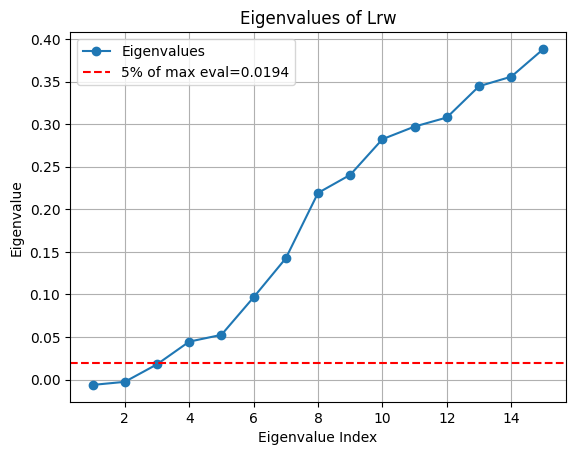

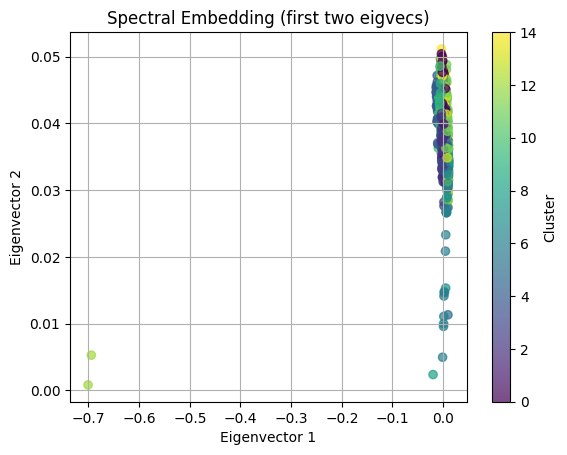

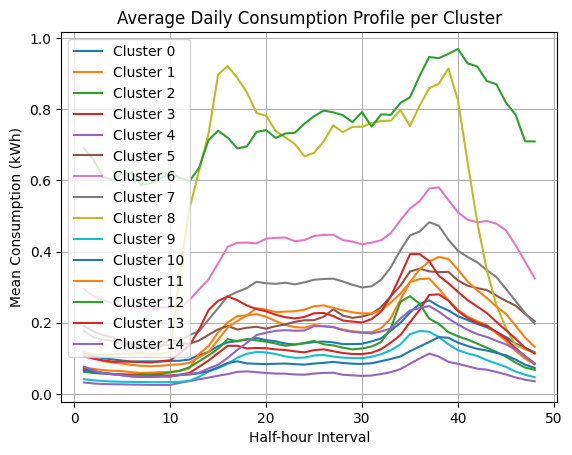

(627, 50)


hh_index                                            ANON_ID     HH_00  \
0         0045034694b28ba56978092fc4dd601c58774fd74c30b7...  0.025413   
1         01b422497e7deb1a7c0ad65e11faabdd20dc9da6a4e520...  0.073129   
2         01c05e36af0caaf19d6c35e0340d015ab07e742aa14fda...  0.135249   
3         029cf457eace7f2a0ed8f55912f926ba9855f3748a117f...  0.070989   
4         034d4493bbb8bd1ae4b7496160610c6a2ab00100a79a7c...  0.306584   

hh_index     HH_01     HH_02     HH_03     HH_04     HH_05     HH_06  \
0         0.025936  0.025600  0.025126  0.025026  0.024868  0.024839   
1         0.057328  0.053876  0.053876  0.052639  0.054272  0.053281   
2         0.133459  0.117193  0.072145  0.053960  0.044119  0.047099   
3         0.070898  0.070937  0.069634  0.069564  0.068128  0.066214   
4         0.246539  0.263386  0.253646  0.250405  0.263125  0.308563   

hh_index     HH_07     HH_08  ...     HH_39     HH_40     HH_41     HH_42  \
0         0.025132  0.024258  ...  0.143833  0.130411  0.111695  0.096144   
1         0.052716  0.052321  ...  0.172920  0.181034  0.211782  0.173481   
2         0.040150  0.038377  ...  0.299261  0.178127  0.166994  0.159198   
3         0.063134  0.062225  ...  0.209570  0.159758  0.161735  0.175795   
4         0.313134  0.358123  ...  0.545106  0.499296  0.495104  0.511303   

hh_index     HH_43     HH_44     HH_45     HH_46     HH_47  Spectral_Cluster  
0         0.076765  0.058824  0.041727  0.029490  0.026768                 9  
1         0.168461  0.161862  0.148991  0.125378  0.098152                14  
2         0.188895  0.167448  0.191603  0.165161  0.126127                14  
3         0.183439  0.177761  0.144652  0.094259  0.075239                 3  
4         0.508230  0.507161  0.348952  0.359245  0.313606                 6  

[5 rows x 50 columns]

In [6]:
# Apply Spectral Clustering on Masked (twice) Pre
df_clusters_spec_01 = spectral_clustering_analysis(
    dataframe = df_pre_masked_02,
    pre_start=pre_start,
    pre_end=pre_end,
    k_knn=20,
    k_clusters=15,
    plot_eigenvalues=True,
    plot_eigvec_scatter=True,
    plot_cluster_profiles=True
)


print(df_clusters_spec_01.shape)
df_clusters_spec_01.head()


### 3.2.0 Optional: Plot Spectral Clusters

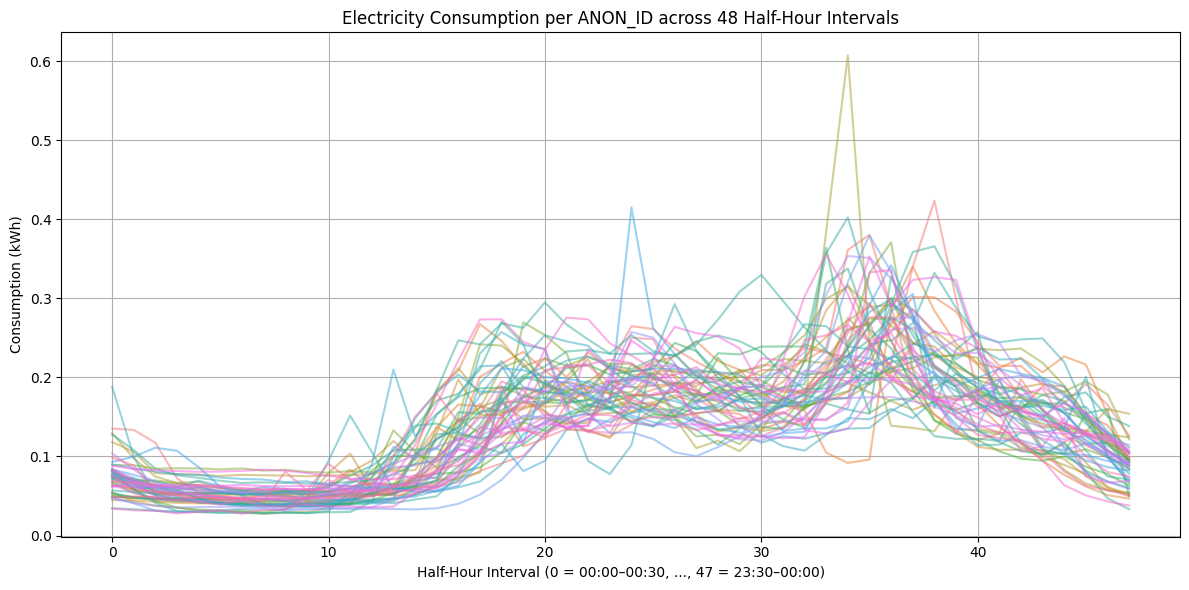

In [7]:
# Visualize Results from Spectral Clustering
### Plot ELEC_KWH vs HH
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# True shows only one cluster; False shows entire Pre
onlyonecluster = True
cluster = 14

if onlyonecluster == True:
    df_clusters_spec = df_clusters_spec_01[df_clusters_spec_01['Spectral_Cluster']==cluster]
else:
    df_clusters_spec = df_clusters_spec_01

# Melt the dataframe to long format
df_melted = df_clusters_spec.melt(
    id_vars='ANON_ID',
    value_vars=[f'HH_{i:02d}' for i in range(48)],
    var_name='HalfHour',
    value_name='Consumption_kWh'
)

# Convert 'HH_00' → 0, ..., 'HH_47' → 47 (int)
df_melted['HalfHour'] = df_melted['HalfHour'].str.extract(r'(\d+)').astype(int)

# Plot with Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_melted,
    x='HalfHour',
    y='Consumption_kWh',
    hue='ANON_ID',
    legend=False,
    alpha=0.5
)

plt.title("Electricity Consumption per ANON_ID across 48 Half-Hour Intervals")
plt.xlabel("Half-Hour Interval (0 = 00:00–00:30, ..., 47 = 23:30–00:00)")
plt.ylabel("Consumption (kWh)")
plt.grid(True)
plt.tight_layout()
plt.show()

### 3.2.1 Remove Outliers

In [8]:
def remove_clusters(df_with_clusters, clusters_to_drop):
    """
    Given a DataFrame that has a 'Spectral_Cluster' column, drop all rows
    whose 'Cluster' is in the list clusters_to_drop.
    """
    mask = df_with_clusters['Spectral_Cluster'].isin(clusters_to_drop)
    return df_with_clusters[~mask].copy()

# Count unique ANON_IDs per cluster
cluster_counts = df_clusters_spec_01['Spectral_Cluster'].value_counts()
clusters_to_drop = cluster_counts[cluster_counts < 5].index.tolist()

# Apply the removal function
df_clusters_spec_01_filtered = remove_clusters(df_clusters_spec_01, clusters_to_drop)

# Optional: Print what was removed
if clusters_to_drop:
    print(f"Removed clusters: {clusters_to_drop}")
    print(f"Original shape: {df_clusters_spec_01.shape}")
    print(f"Filtered shape: {df_clusters_spec_01_filtered.shape}")
else:
    print("No clusters needed to be removed (all have >= 5 ANON_IDs)")

print(f"Pre data shape: {df_pre_masked_02.shape}")
df_pre_masked_03 = df_pre_masked_02[df_pre_masked_02['ANON_ID'].isin(df_clusters_spec_01_filtered['ANON_ID'])]
print(f"Pre data after mask 03: {df_pre_masked_03.shape}")

Removed clusters: [12, 8]
Original shape: (627, 50)
Filtered shape: (624, 50)
Pre data shape: (10522490, 3)
Pre data after mask 03: (10473514, 3)


## 3.3 Remove Outliers with Spectral Clustering - *Second Iteration*

[INFO] Aggregated shape => (624, 49) (ANON_ID + 48 half-hour columns)
Spectral Clustering => k_knn=20, k_clusters=10
Silhouette Score: 0.3760
Cluster 0: 88 ANON_IDs
Cluster 1: 81 ANON_IDs
Cluster 2: 17 ANON_IDs
Cluster 3: 42 ANON_IDs
Cluster 4: 89 ANON_IDs
Cluster 5: 60 ANON_IDs
Cluster 6: 51 ANON_IDs
Cluster 7: 41 ANON_IDs
Cluster 8: 73 ANON_IDs
Cluster 9: 82 ANON_IDs


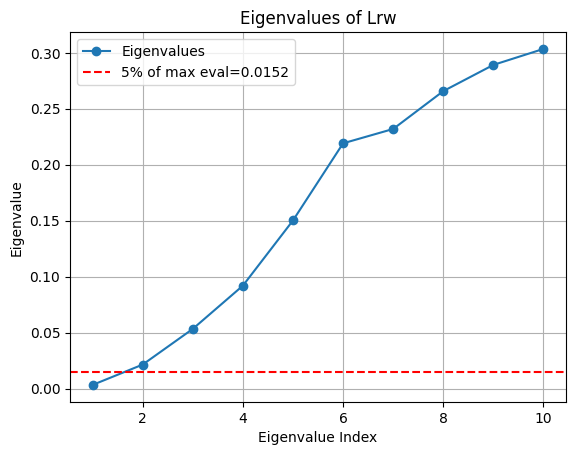

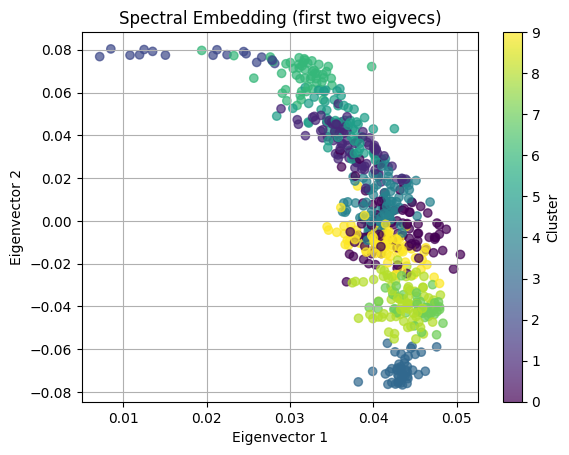

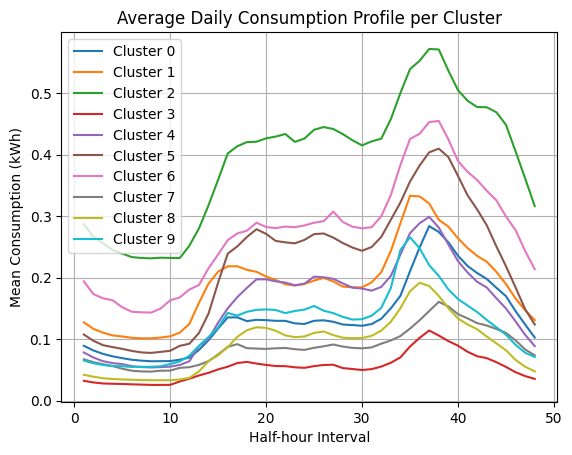

hh_index                                            ANON_ID     HH_00  \
0         0045034694b28ba56978092fc4dd601c58774fd74c30b7...  0.025413   
1         01b422497e7deb1a7c0ad65e11faabdd20dc9da6a4e520...  0.073129   
2         01c05e36af0caaf19d6c35e0340d015ab07e742aa14fda...  0.135249   
3         029cf457eace7f2a0ed8f55912f926ba9855f3748a117f...  0.070989   
4         034d4493bbb8bd1ae4b7496160610c6a2ab00100a79a7c...  0.306584   

hh_index     HH_01     HH_02     HH_03     HH_04     HH_05     HH_06  \
0         0.025936  0.025600  0.025126  0.025026  0.024868  0.024839   
1         0.057328  0.053876  0.053876  0.052639  0.054272  0.053281   
2         0.133459  0.117193  0.072145  0.053960  0.044119  0.047099   
3         0.070898  0.070937  0.069634  0.069564  0.068128  0.066214   
4         0.246539  0.263386  0.253646  0.250405  0.263125  0.308563   

hh_index     HH_07     HH_08  ...     HH_39     HH_40     HH_41     HH_42  \
0         0.025132  0.024258  ...  0.143833  0.130411  0.111695  0.096144   
1         0.052716  0.052321  ...  0.172920  0.181034  0.211782  0.173481   
2         0.040150  0.038377  ...  0.299261  0.178127  0.166994  0.159198   
3         0.063134  0.062225  ...  0.209570  0.159758  0.161735  0.175795   
4         0.313134  0.358123  ...  0.545106  0.499296  0.495104  0.511303   

hh_index     HH_43     HH_44     HH_45     HH_46     HH_47  Spectral_Cluster  
0         0.076765  0.058824  0.041727  0.029490  0.026768                 8  
1         0.168461  0.161862  0.148991  0.125378  0.098152                 4  
2         0.188895  0.167448  0.191603  0.165161  0.126127                 4  
3         0.183439  0.177761  0.144652  0.094259  0.075239                 0  
4         0.508230  0.507161  0.348952  0.359245  0.313606                 2  

[5 rows x 50 columns]

In [9]:
# Lets run again Spectral Clustering on the filtered df to double check Outlier Clusters are removed
# Filtered Input of Spectral Clustering: df_pre_masked_03
# Filtered Output of Spectral Clustering: df_clusters_spec_01_filtered

df_pre_02 = df_pre_masked_03.merge(
    df_clusters_spec_01_filtered[['ANON_ID', 'Spectral_Cluster']],
    on='ANON_ID',
    how='left'  # Use 'left' to preserve all rows in df_pre
)

df_clusters_spec_second = spectral_clustering_analysis(
    dataframe = df_pre_02,
    pre_start=pre_start,
    pre_end=pre_end,
    k_knn=20,
    k_clusters=10,
    plot_eigenvalues=True,
    plot_eigvec_scatter=True,
    plot_cluster_profiles=True
)

df_clusters_spec_second.head()


### 3.3.1 Remove outliers

In [10]:
# Count unique ANON_IDs per cluster
cluster_counts = df_clusters_spec_second['Spectral_Cluster'].value_counts()
clusters_to_drop_second = cluster_counts[cluster_counts < 5].index.tolist()

# Apply the removal function
df_clusters_spec_02_filtered = remove_clusters(df_clusters_spec_second, clusters_to_drop_second)

# Optional: Print what was removed
if clusters_to_drop_second:
    print(f"Removed clusters: {clusters_to_drop_second}")
    print(f"Original shape: {df_clusters_spec_second.shape}")
    print(f"Filtered shape: {df_clusters_spec_02_filtered.shape}")
else:
    print("No clusters needed to be removed (all have >= 5 ANON_IDs)")

print(f"Pre data shape: {df_pre_masked_03.shape}")
df_pre_masked_04 = df_pre_masked_03[df_pre_masked_03['ANON_ID'].isin(df_clusters_spec_02_filtered['ANON_ID'])]
print(f"Pre data after mask 03: {df_pre_masked_04.shape}")

No clusters needed to be removed (all have >= 5 ANON_IDs)
Pre data shape: (10473514, 3)
Pre data after mask 03: (10473514, 3)


## 3.4 Remove Outliers with Spectral Clustering - *Third Iteration*

[INFO] Aggregated shape => (624, 49) (ANON_ID + 48 half-hour columns)
Spectral Clustering => k_knn=20, k_clusters=10
Silhouette Score: 0.3676
Cluster 0: 60 ANON_IDs
Cluster 1: 73 ANON_IDs
Cluster 2: 88 ANON_IDs
Cluster 3: 14 ANON_IDs
Cluster 4: 41 ANON_IDs
Cluster 5: 84 ANON_IDs
Cluster 6: 57 ANON_IDs
Cluster 7: 81 ANON_IDs
Cluster 8: 43 ANON_IDs
Cluster 9: 83 ANON_IDs


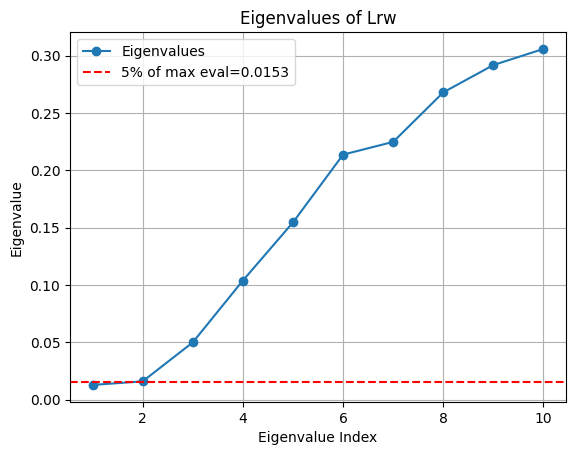

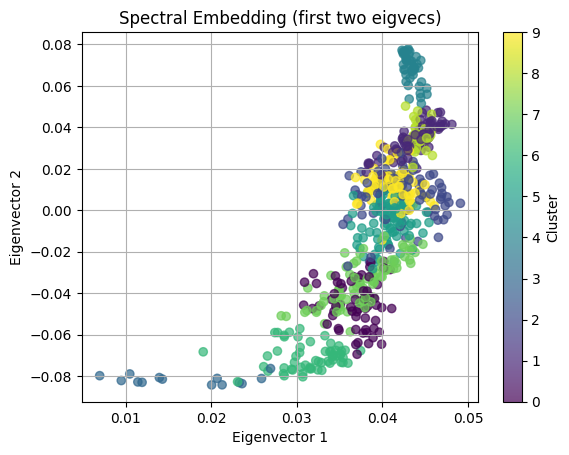

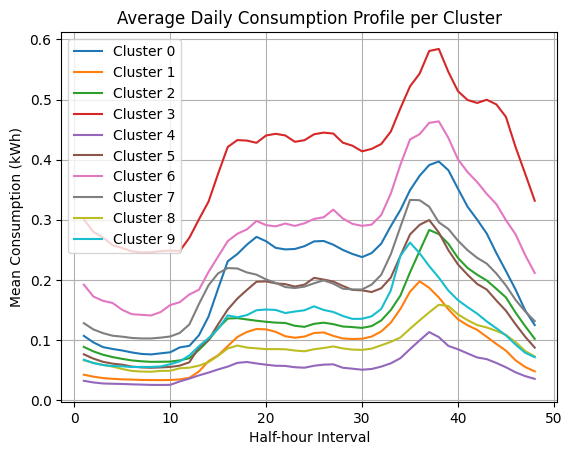

In [11]:
# Lets run again Spectral Clustering on the filtered df to double check Outlier Clusters are removed
# Filtered Input of Spectral Clustering: df_pre_masked_03
# Filtered Output of Spectral Clustering: df_clusters_spec_01_filtered

df_pre_03 = df_pre_masked_04.merge(
    df_clusters_spec_02_filtered[['ANON_ID', 'Spectral_Cluster']],
    on='ANON_ID',
    how='left'  # Use 'left' to preserve all rows in df_pre
)


df_clusters_spec_third = spectral_clustering_analysis(
    dataframe = df_pre_03,
    pre_start=pre_start,
    pre_end=pre_end,
    k_knn=20,
    k_clusters=10,
    plot_eigenvalues=True,
    plot_eigvec_scatter=True,
    plot_cluster_profiles=True
)

df_clusters_spec_third.head()
df_pre_consumption_clean = df_clusters_spec_third.drop(columns=["Spectral_Cluster"])

# 4 Clustering


## 4.1 PC Loadings

Percentage of variance explained (rows = number of components, columns = PC index):
    PC1  PC2  PC3  PC4  PC5  PC6  PC7 PC8 PC9 PC10 PC11 PC12  Cumulative
2  71.5  7.2                                                        78.7
3  71.5  7.2  4.4                                                   83.0
4  71.5  7.2  4.4  3.5                                              86.5
5  71.5  7.2  4.4  3.5  2.5                                         89.0
6  71.5  7.2  4.4  3.5  2.5  1.6                                    90.6
7  71.5  7.2  4.4  3.5  2.5  1.6  1.4                               92.0


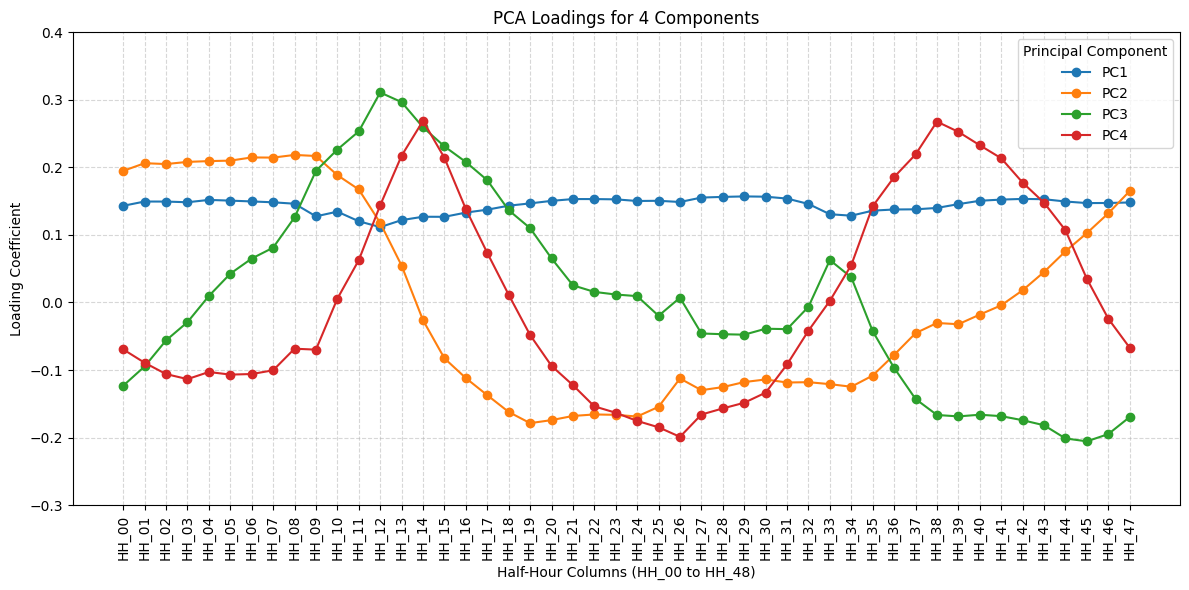

In [12]:

# ------------------------------------------------------------------------------
# 0) Prepare your data from df24_clean (already in your code)
# ------------------------------------------------------------------------------
df24_clean = df_pre_consumption_clean.copy()  # use your existing DataFrame
anon_ids = df24_clean["ANON_ID"].values
data_24 = df24_clean.drop(columns=["ANON_ID"])  # the 48 HH columns
data_24_values = data_24.values.astype(np.float64)  # shape (n_samples, 48)


# Scale the 48-HH data
scaler_raw = StandardScaler()
data_24_scaled = scaler_raw.fit_transform(data_24_values)


# ------------------------------------------------------------------------------
# 1) Collect explained variance for n_components in [2..12]
# ------------------------------------------------------------------------------
all_explained_variance = {}  # dict: n_comp -> explained_variance_ratio_ array

for n_comp in range(2, 13):
    pca_temp = PCA(n_components=n_comp, random_state=42)
    pca_temp.fit(data_24_scaled)
    # explained_variance_ratio_ is length n_comp
    all_explained_variance[n_comp] = pca_temp.explained_variance_ratio_

# Create a DataFrame (rows = n_comp=2..12, columns = PC1..PC12)
expl_variance_df = pd.DataFrame.from_dict(
    all_explained_variance,
    orient='index'
)
expl_variance_df.columns = [f'PC{i+1}' for i in range(expl_variance_df.shape[1])]

# Multiply by 100 to get percentages
expl_variance_df = expl_variance_df * 100

# Create a new column with the cumulative variance for *that* number of components
# (i.e. sum across the non-NaN columns in the row)
expl_variance_df["Cumulative"] = expl_variance_df.sum(axis=1)

print("Percentage of variance explained (rows = number of components, columns = PC index):")
expl_variance_df = expl_variance_df.round(1)
expl_variance_df = expl_variance_df.fillna("")

print(expl_variance_df.head(6))

# ------------------------------------------------------------------------------
# 1) Fit PCA and extract loadings
# ------------------------------------------------------------------------------
selected_n_components = 4  # Arbitrarily select number of components to examine
pca_chosen = PCA(n_components=selected_n_components, random_state=42)
pca_chosen.fit(data_24_scaled)

# PCA loadings = pca.components_, shape is (n_components, n_features)
# By convention: row i = coefficients of PC i across the original features
# Make a DataFrame where rows = PC1..PCn, columns = HH_00..HH_48
loadings_df = pd.DataFrame(
    pca_chosen.components_,
    columns=data_24.columns,
    index=[f"PC{i+1}" for i in range(selected_n_components)]
)

# ------------------------------------------------------------------------------
# 2) Plot Loadings vs HH (Each line is a Component)
# ------------------------------------------------------------------------------
plt.figure(figsize=(12, 6))

for component in loadings_df.index:
    plt.plot(loadings_df.columns, loadings_df.loc[component], marker='o', label=component)

plt.xlabel("Half-Hour Columns (HH_00 to HH_48)")
plt.ylabel("Loading Coefficient")
plt.title(f"PCA Loadings for {selected_n_components} Components")
plt.xticks(rotation=90)
plt.legend(title="Principal Component", loc="upper right")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.ylim(-0.3,0.4)
plt.show()




## 4.2 Custom Measure function for Clustering evaluation

In [13]:
import numpy as np

def clustermeasure(vec1, vec2, alpha):
    """
    Compute similarity measure between two 48-dimensional vectors (half-hour readings).

    The measure is:
        0.8 * sum(|(v1[h] / mean(v1)) - (v2[h] / mean(v2))|) +
        0.2 * |mean(v1) - mean(v2)|

    Parameters
    ----------
    vec1 : array-like of shape (48,)
        48 half-hour readings for entity 1
    vec2 : array-like of shape (48,)
        48 half-hour readings for entity 2

    Returns
    -------
    float
        The cluster measure (smaller means more similar).
    """
    mean1 = vec1.mean()
    mean2 = vec2.mean()
    # Differences from each vector's mean
    centered_diff = np.abs((vec1 / mean1) - (vec2 / mean2))
    measure_centered = np.sum(centered_diff)
    measure_mean = np.abs(mean1 - mean2)

    return (alpha) * measure_centered + (1-alpha) * measure_mean
# ------------------------------------------------------------------------------
# Define a utility to compute the average clustermeasure to cluster centroids
# ------------------------------------------------------------------------------
def average_clustermeasure_to_centroid(data_original, labels, n_clusters, cluster_centroids, alpha):
    """
    Compute the average clustermeasure between each point and its cluster centroid
    in the original 48-dimensional space.

    Parameters
    ----------
    data_original : ndarray, shape (n_samples, 48)
        Original 48-HH data
    labels : ndarray, shape (n_samples,)
        Cluster labels for each sample.
    n_clusters : int
        Number of clusters.
    cluster_centroids : ndarray, shape (n_clusters, 48)
        Centroids in the *original domain* (48-HH).


    Returns
    -------
    float
        Average cluster measure across all points with respect to their cluster centroid
    """
    n_samples = data_original.shape[0]
    sum_measure = 0.0
    for i in range(n_samples):
        c = labels[i]
        sum_measure += clustermeasure(data_original[i], cluster_centroids[c], alpha)
    return sum_measure / n_samples


## 4.3 Iterate over many clusters and components configurations

    n_components  n_clusters  silhouette  avg_clustermeasure
0              4           2    0.255805            8.000139
1              4           3    0.247380            7.858567
2              4           4    0.240872            7.656252
3              4           5    0.225784            7.438704
4              4           6    0.235132            7.416392
..           ...         ...         ...                 ...
67            20           5    0.072186            7.774912
68            20           6    0.045068            7.755225
69            20           7    0.093944            7.662963
70            20           8    0.073327            7.735485
71            20           9    0.040538            7.634811

[72 rows x 4 columns]


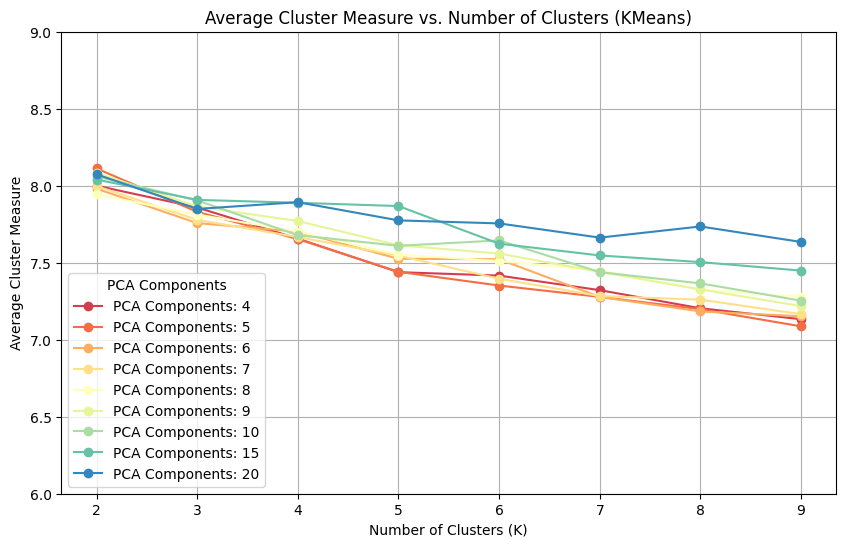

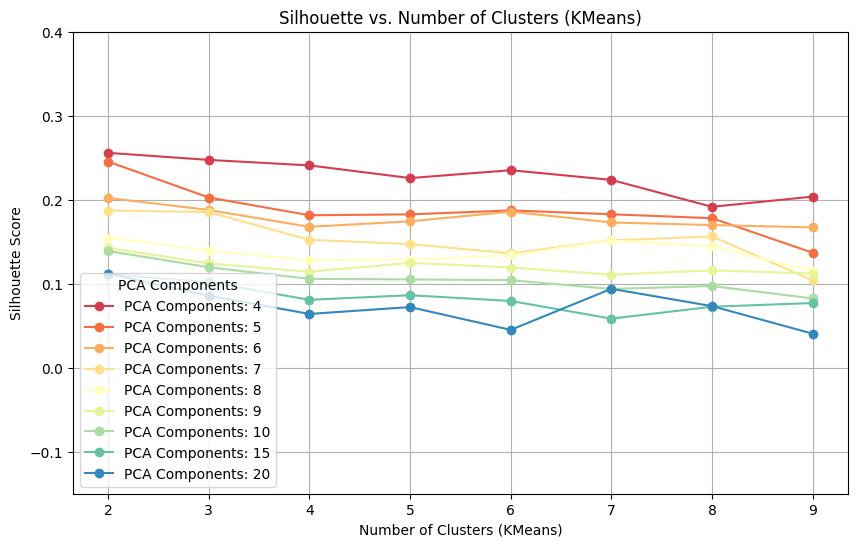

In [14]:
os.environ["OMP_NUM_THREADS"] = "3"  # or set to 1, 2, depending on your CPU


manyclusters = 10

# ----------------------------------------------------------------------------
# 0) Prepare your data from df24_clean
# ----------------------------------------------------------------------------
df24_clean = df_pre_consumption_clean.copy()

# Preserve ANON_ID as a column
anon_ids = df24_clean["ANON_ID"].values

# Prepare data for PCA and clustering
data_24 = df24_clean.drop(columns=["ANON_ID"])  # the 48 HH columns
data_24_values = data_24.values.astype(np.float64)

# Scale the data
scaler_raw = StandardScaler()
data_24_scaled = scaler_raw.fit_transform(data_24_values)

# ----------------------------------------------------------------------------
# 1) Range of PCA components and cluster counts
# ----------------------------------------------------------------------------
n_components_list = [4, 5, 6, 7, 8, 9, 10, 15, 20]
clusters_range = range(2, manyclusters)

results = []

for n_comp in n_components_list:
    pca = PCA(n_components=n_comp, random_state=42)
    pca_scores = pca.fit_transform(data_24_scaled)

    scaler_pca = StandardScaler()
    pca_scores_scaled = scaler_pca.fit_transform(pca_scores)

    for k in clusters_range:
        kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
        labels = kmeans.fit_predict(pca_scores_scaled)

        sil_score = silhouette_score(pca_scores_scaled, labels)

        cluster_centers_pca = scaler_pca.inverse_transform(kmeans.cluster_centers_)
        cluster_centers_scaled = pca.inverse_transform(cluster_centers_pca)
        cluster_centers_original = scaler_raw.inverse_transform(cluster_centers_scaled)

        avg_meas = average_clustermeasure_to_centroid(
            data_original=data_24_values,
            labels=labels,
            n_clusters=k,
            cluster_centroids=cluster_centers_original,
            alpha=0.8
        )

        results.append({
            "n_components": n_comp,
            "n_clusters": k,
            "silhouette": sil_score,
            "avg_clustermeasure": avg_meas
        })

# ----------------------------------------------------------------------------
# 2) Plot Results
# ----------------------------------------------------------------------------
results_df = pd.DataFrame(results)
print(results_df)

plt.figure(figsize=(10, 6))
colors = sns.color_palette("Spectral", len(results_df["n_components"].unique()))

for i, n_comp in enumerate(results_df["n_components"].unique()):
    subset = results_df[results_df["n_components"] == n_comp]
    plt.plot(
        subset["n_clusters"], subset["avg_clustermeasure"], marker='o', linestyle='-',
        label=f'PCA Components: {n_comp}', color=colors[i]
    )

plt.title('Average Cluster Measure vs. Number of Clusters (KMeans)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Average Cluster Measure')
plt.xticks(range(2, manyclusters))
plt.legend(title="PCA Components")
plt.grid(True)
plt.ylim(6, 9)
plt.show()

plt.figure(figsize=(10, 6))
colors = sns.color_palette("Spectral", len(results_df["n_components"].unique()))

for i, n_comp in enumerate(results_df["n_components"].unique()):
    subset = results_df[results_df["n_components"] == n_comp]
    plt.plot(
        subset["n_clusters"], subset["silhouette"], marker='o', linestyle='-',
        label=f'PCA Components: {n_comp}', color=colors[i]
    )

plt.title("Silhouette vs. Number of Clusters (KMeans)")
plt.xlabel("Number of Clusters (KMeans)")
plt.ylabel("Silhouette Score")
plt.xticks(range(2, manyclusters))
plt.legend(title="PCA Components")
plt.grid(True)
plt.ylim(-0.15, 0.4)
plt.show()


### 4.4 Run with ideal configuratioin of clusters and components

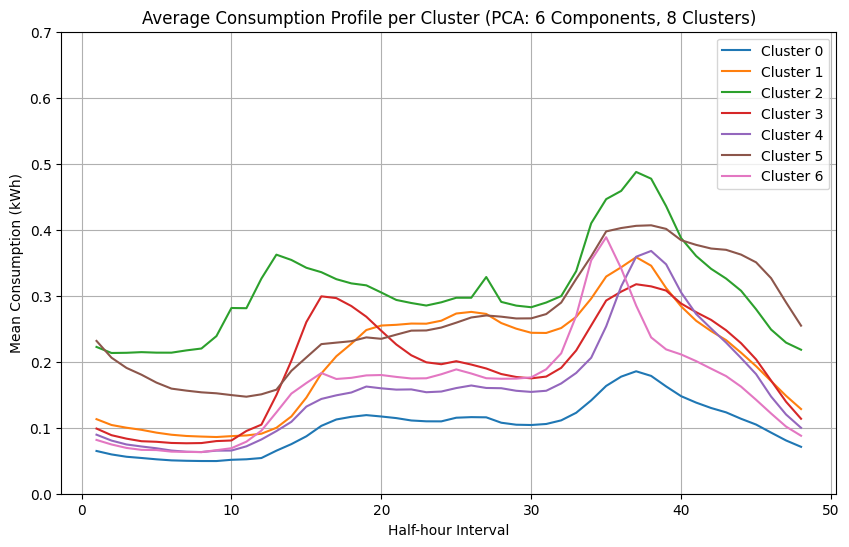

   Cluster  Household Count
0        0              240
1        1               98
2        2               13
3        3               58
4        4               95
5        5               36
6        6               84


In [15]:
# ----------------------------------------------------------------------------
# 3) PCA + KMeans Final Fit for Visualization
# ----------------------------------------------------------------------------
n_components = 6
n_clusters = 7

pca = PCA(n_components=n_components, random_state=42)
pca_scores = pca.fit_transform(data_24_scaled)

scaler_pca = StandardScaler()
pca_scores_scaled = scaler_pca.fit_transform(pca_scores)

kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
labels_kplus_6comp = kmeans.fit_predict(pca_scores_scaled)

cluster_centers_pca = scaler_pca.inverse_transform(kmeans.cluster_centers_)
cluster_centers_scaled = pca.inverse_transform(cluster_centers_pca)
cluster_centers_original = scaler_raw.inverse_transform(cluster_centers_scaled)

plt.figure(figsize=(10, 6))
for cluster in range(n_clusters):
    plt.plot(range(1, 49), cluster_centers_original[cluster], label=f'Cluster {cluster}')

plt.xlabel("Half-hour Interval")
plt.ylabel("Mean Consumption (kWh)")
plt.title("Average Consumption Profile per Cluster (PCA: 6 Components, 8 Clusters)")
plt.legend()
plt.grid(True)
plt.ylim(0,0.7)
plt.show()

# Count the number of households (ANON_IDs) per cluster
cluster_counts = pd.Series(labels_kplus_6comp).value_counts().sort_index()

# Convert to a DataFrame for better readability
cluster_counts_df = pd.DataFrame({
    "Cluster": cluster_counts.index,
    "Household Count": cluster_counts.values
})

# Display the table
print(cluster_counts_df)



### 4.4.0 Optional Plot a specific Cluster

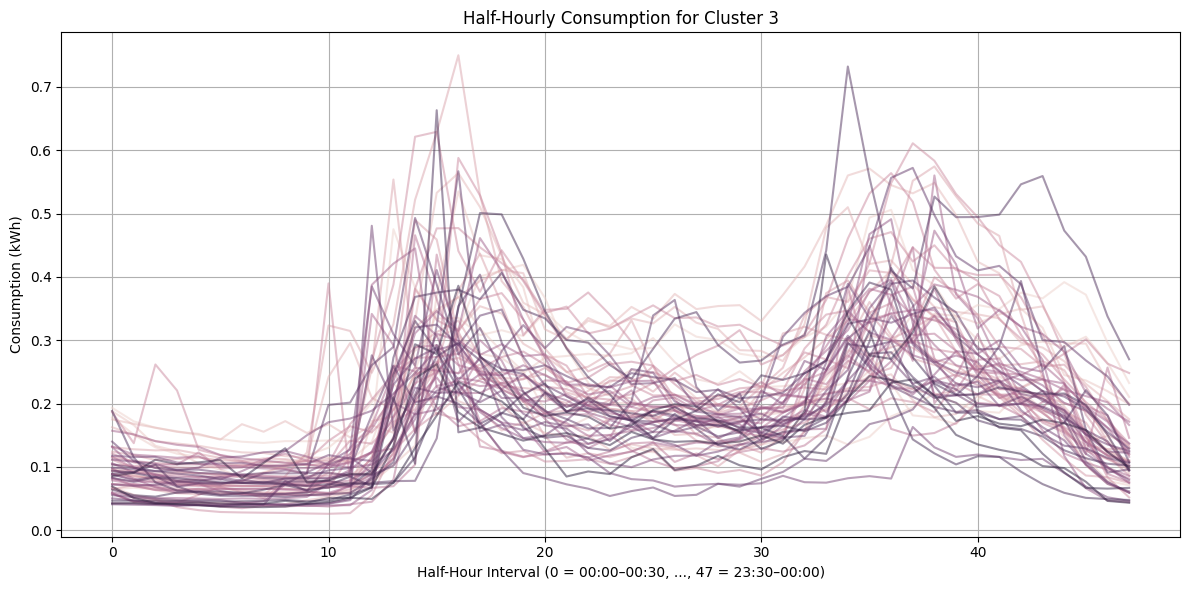

In [16]:
cluster_id = 3
# Step 1: Assign cluster labels to the original data
df_with_labels = data_24.copy()
df_with_labels['Cluster'] = labels_kplus_6comp
df_with_labels['ANON_ID'] = data_24.index  # Optional: if ANON_ID is the index, reset or assign it here

# Step 2: Melt to long format for plotting
df_long = df_with_labels.melt(
    id_vars=['ANON_ID', 'Cluster'],
    value_vars=[f'HH_{i:02d}' for i in range(48)],
    var_name='HalfHour',
    value_name='Consumption_kWh'
)

# Convert 'HH_00' → 0, ..., 'HH_47' → 47
df_long['HalfHour'] = df_long['HalfHour'].str.extract(r'(\d+)').astype(int)

# Step 3: Plot for a specific cluster

df_cluster = df_long[df_long['Cluster'] == cluster_id]

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_cluster,
    x='HalfHour',
    y='Consumption_kWh',
    hue='ANON_ID',
    legend=False,
    alpha=0.5
)
plt.title(f"Half-Hourly Consumption for Cluster {cluster_id}")
plt.xlabel("Half-Hour Interval (0 = 00:00–00:30, ..., 47 = 23:30–00:00)")
plt.ylabel("Consumption (kWh)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Generate Clustering for Components XX and Clusters YY
Several plots showcasing how the ANON_IDs change from one to another.


Includes **Sankey Diagram**

Processing PCA with 4 components...
  - Clustering with 2 clusters...


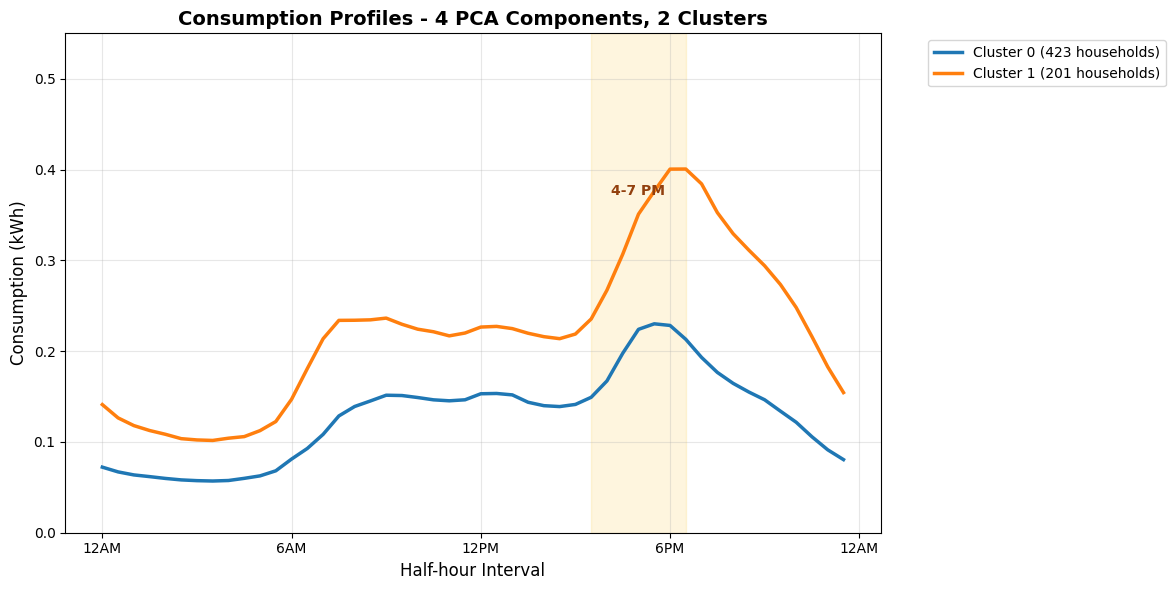

  - Clustering with 3 clusters...


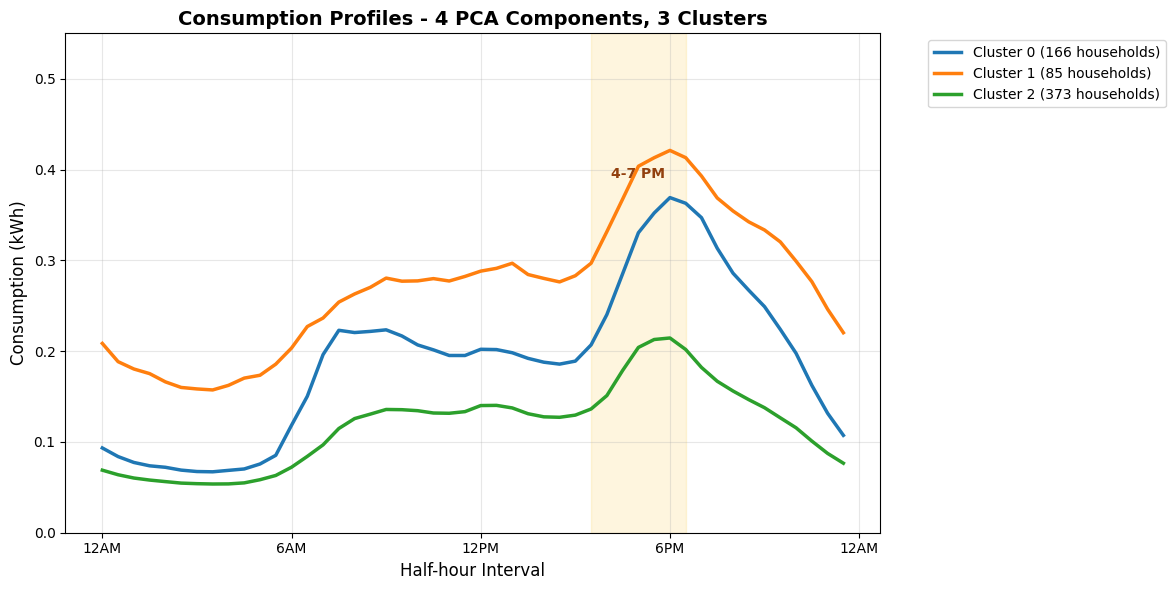

  - Clustering with 4 clusters...


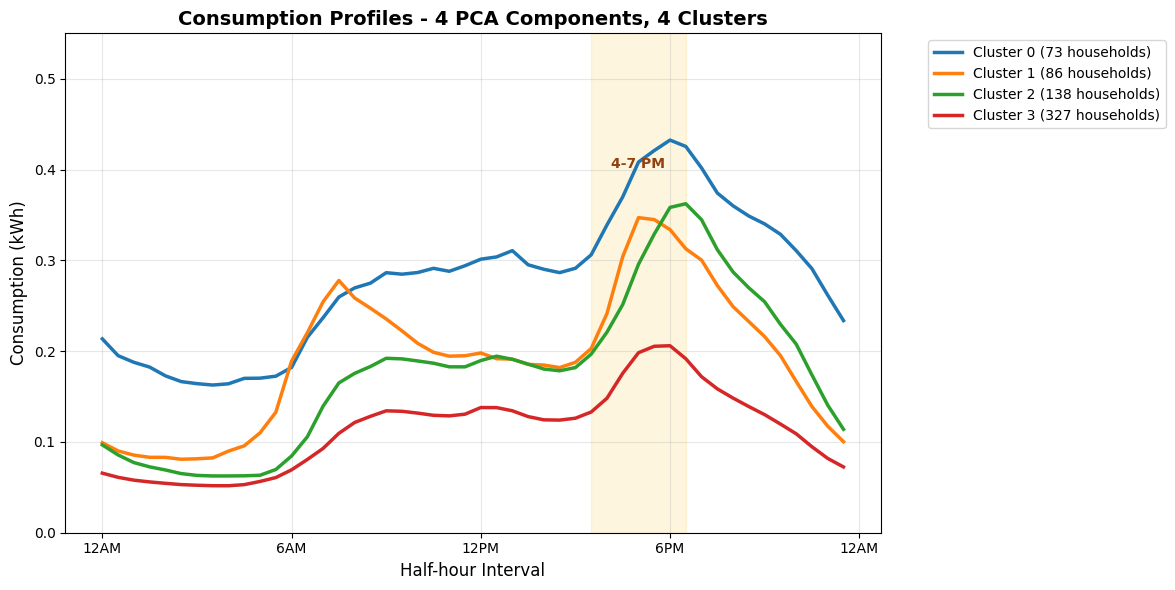

  - Clustering with 5 clusters...


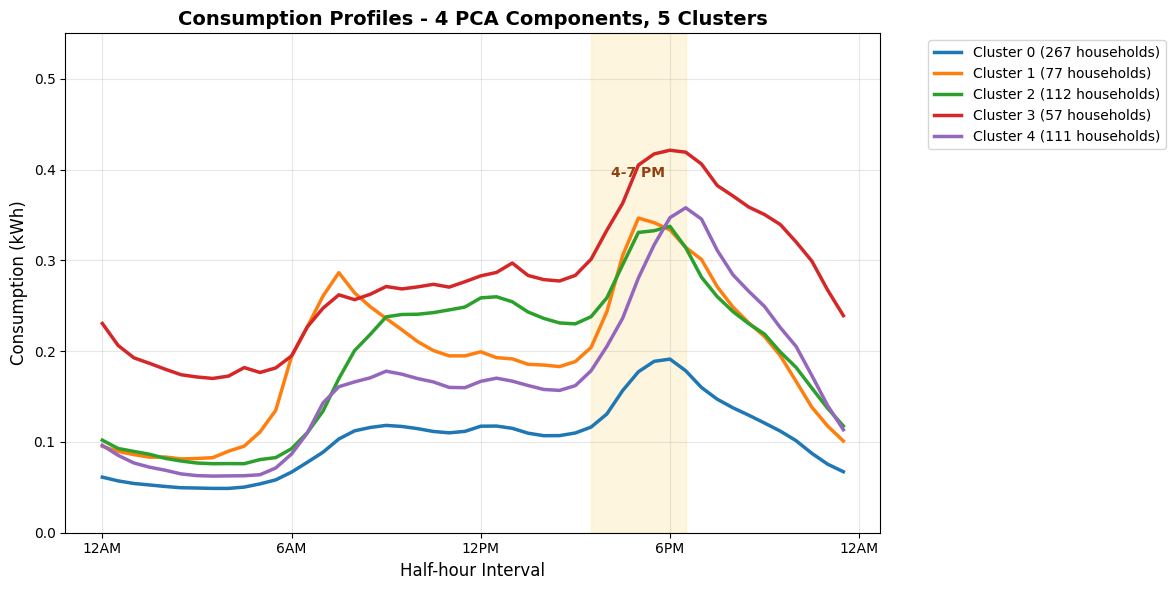

  - Clustering with 6 clusters...


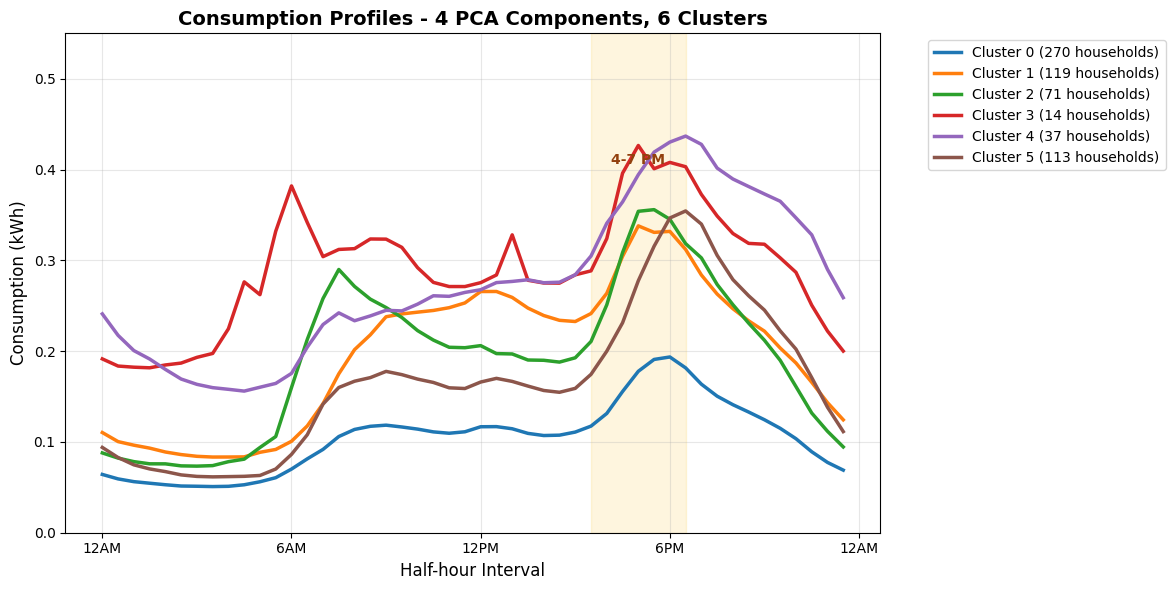

  - Clustering with 7 clusters...


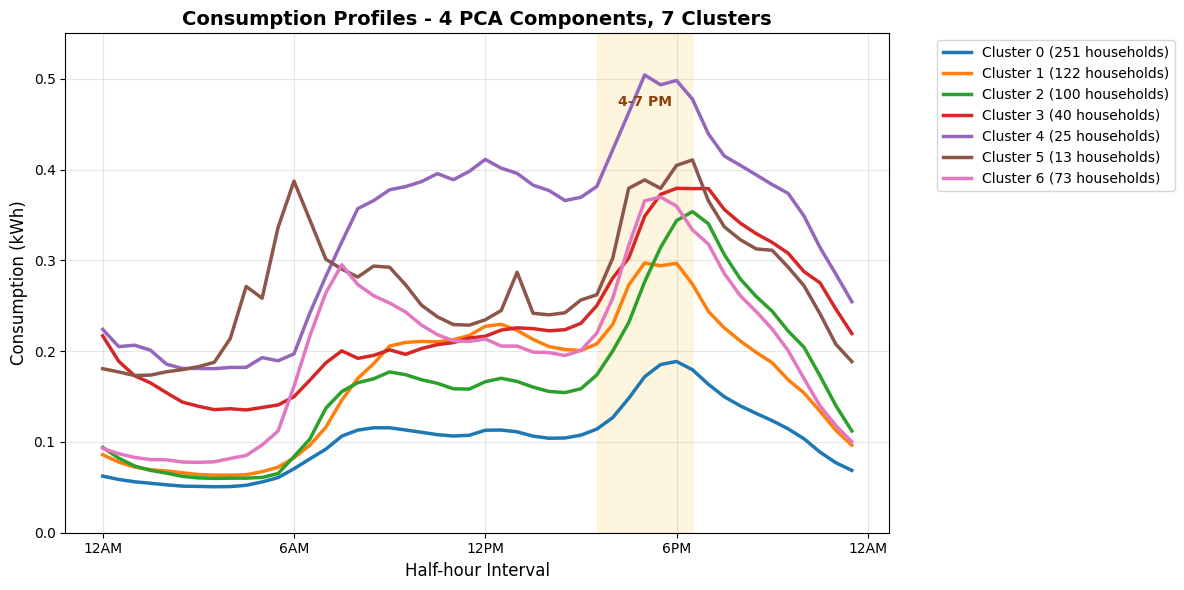

  - Clustering with 8 clusters...


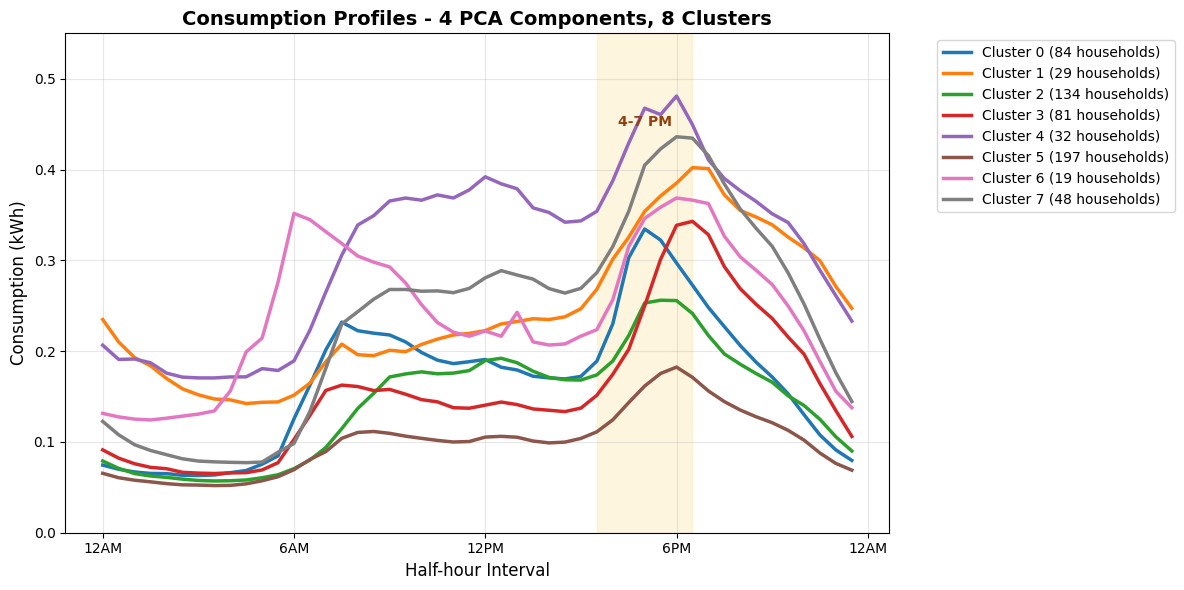

  - Clustering with 9 clusters...


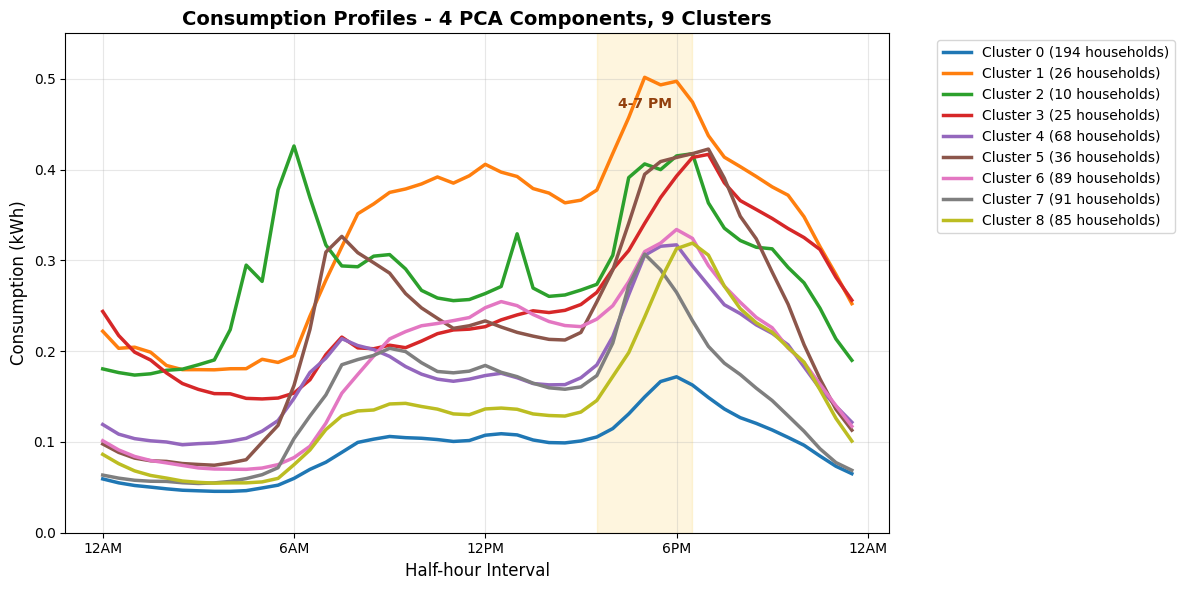

Processing PCA with 6 components...
  - Clustering with 2 clusters...


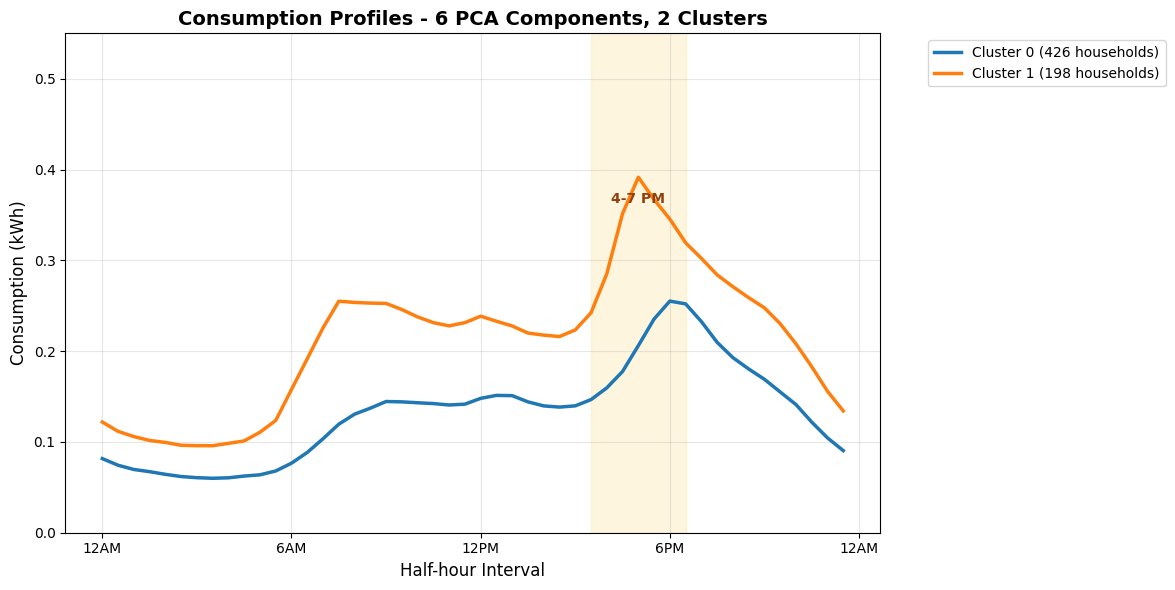

  - Clustering with 3 clusters...


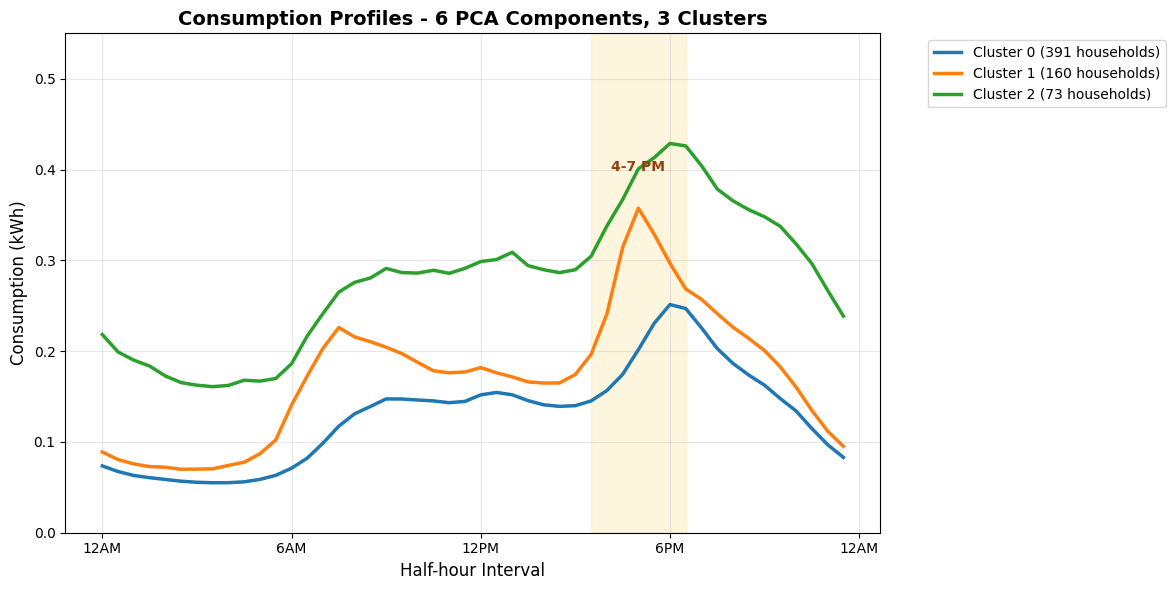

  - Clustering with 4 clusters...


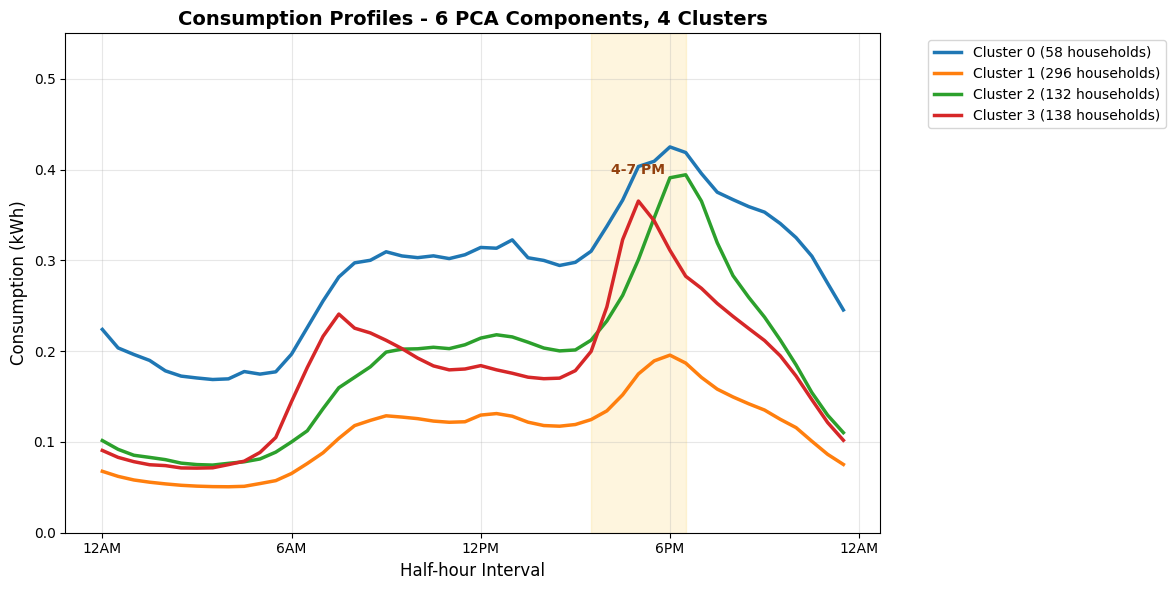

  - Clustering with 5 clusters...


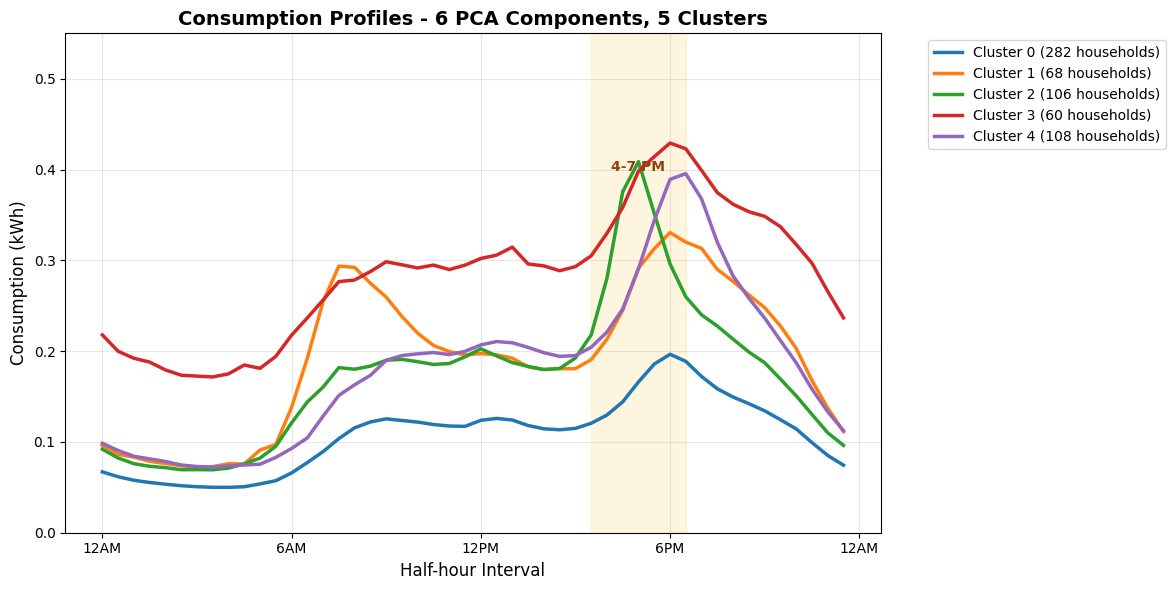

  - Clustering with 6 clusters...


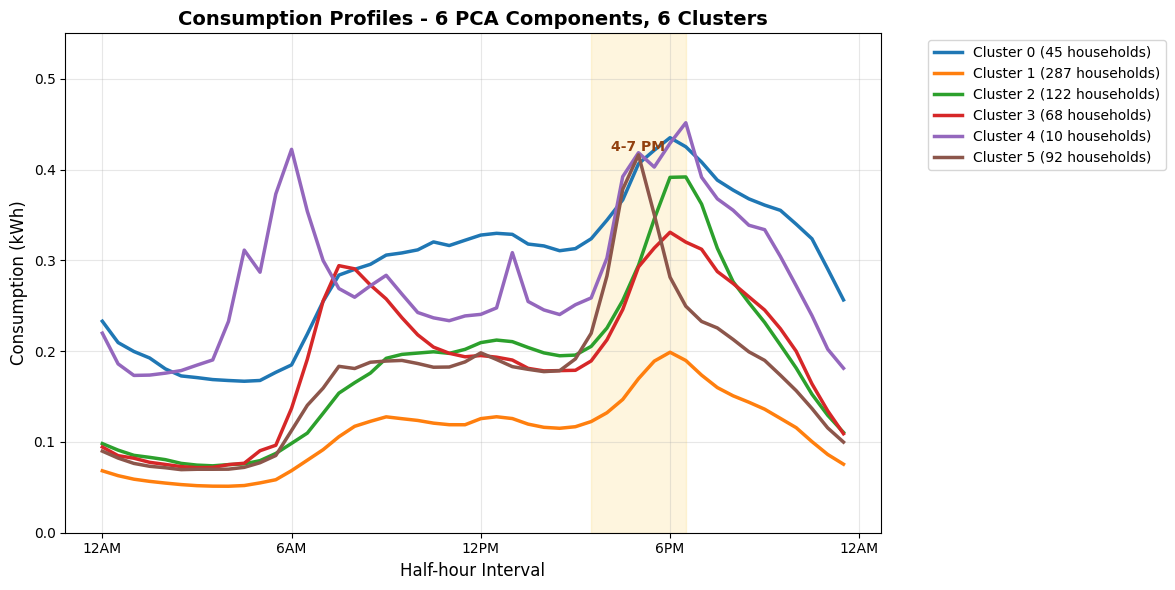

  - Clustering with 7 clusters...


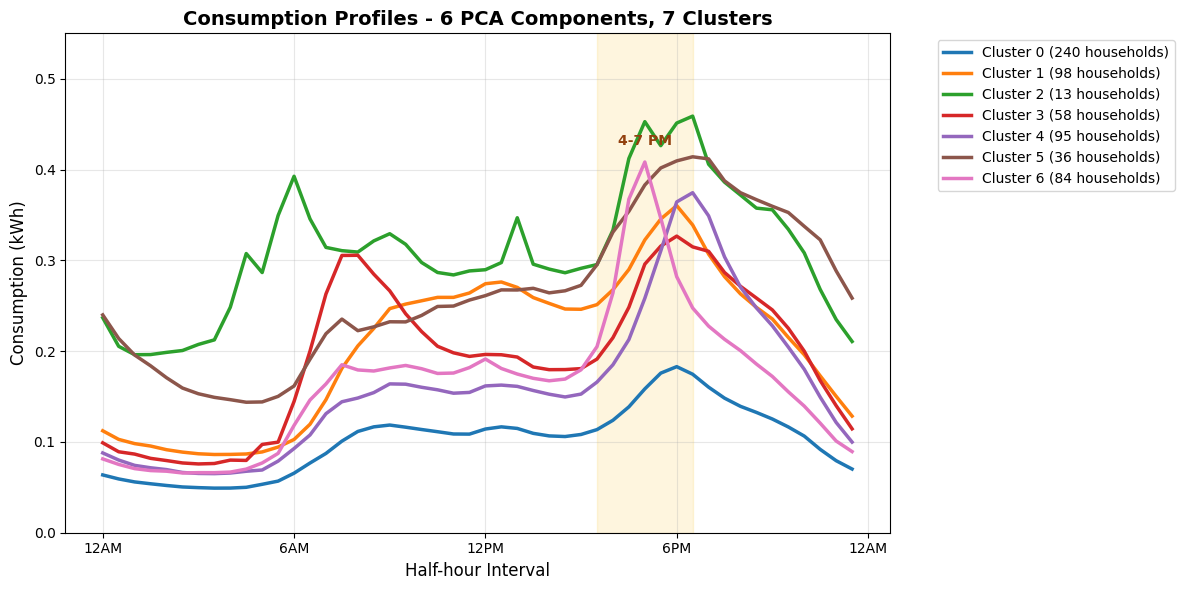

  - Clustering with 8 clusters...


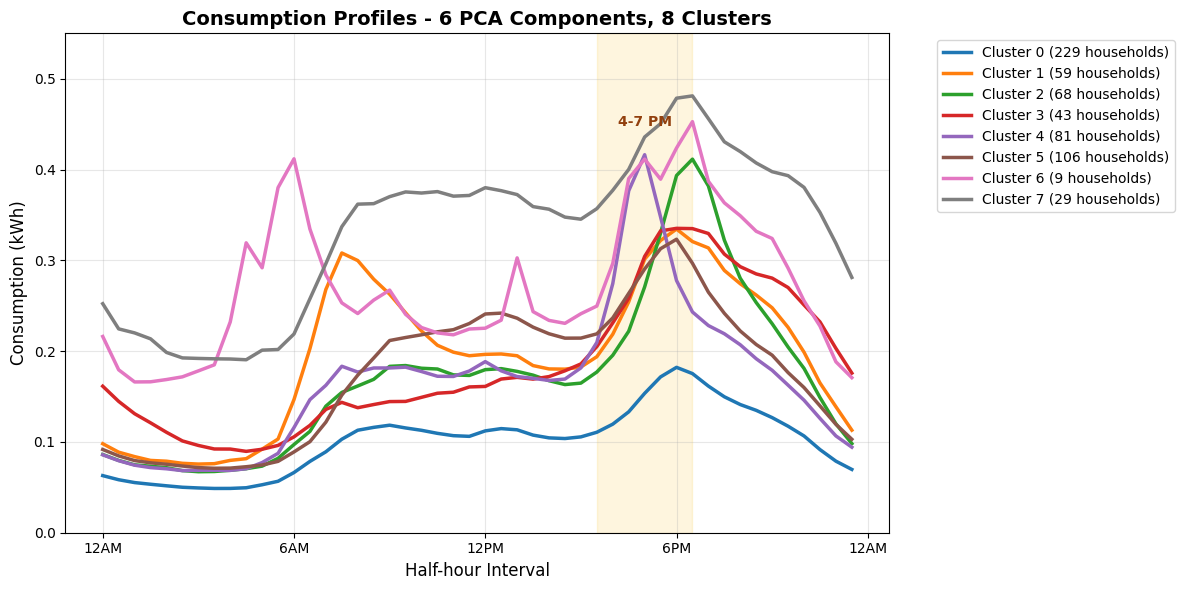

  - Clustering with 9 clusters...


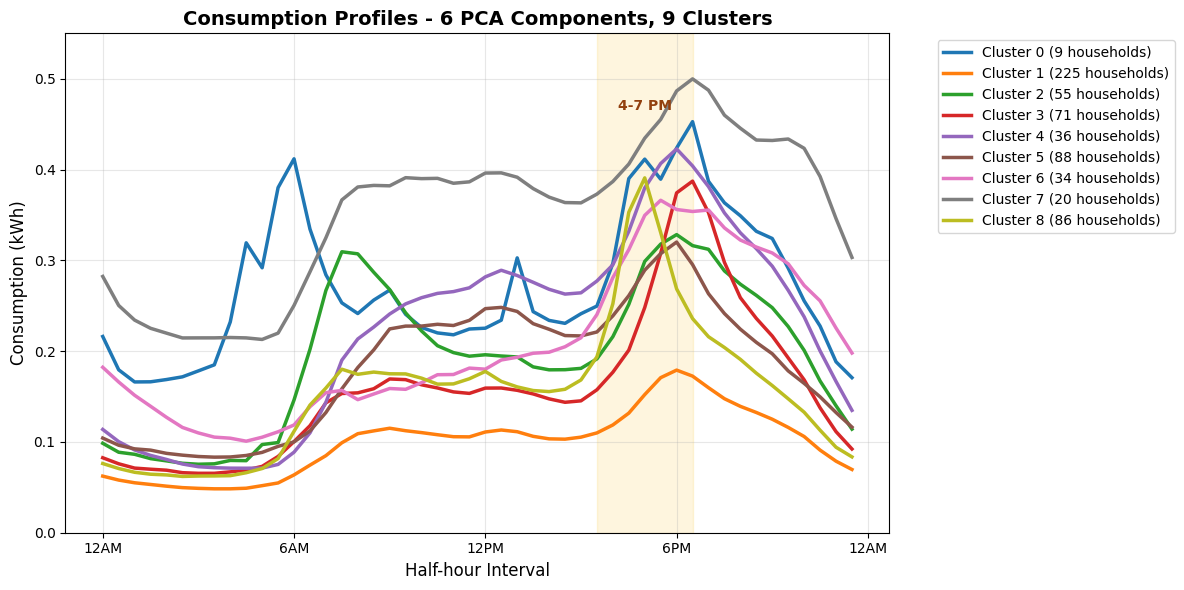


Completed! Added 16 clustering columns to the dataframe.
DataFrame shape: (624, 17)
Columns added: ['Cluster_Comp04_k02', 'Cluster_Comp04_k03', 'Cluster_Comp04_k04', 'Cluster_Comp04_k05', 'Cluster_Comp04_k06', 'Cluster_Comp04_k07', 'Cluster_Comp04_k08', 'Cluster_Comp04_k09', 'Cluster_Comp06_k02', 'Cluster_Comp06_k03', 'Cluster_Comp06_k04', 'Cluster_Comp06_k05', 'Cluster_Comp06_k06', 'Cluster_Comp06_k07', 'Cluster_Comp06_k08', 'Cluster_Comp06_k09']

Results Summary:
   n_components  n_clusters  silhouette  avg_clustermeasure
0             4           2    0.255805            8.000139
1             4           3    0.247380            7.858567
2             4           4    0.240872            7.656252
3             4           5    0.225784            7.438704
4             4           6    0.235132            7.416392
5             4           7    0.223596            7.321879
6             4           8    0.191571            7.204235
7             4           9    0.203716          

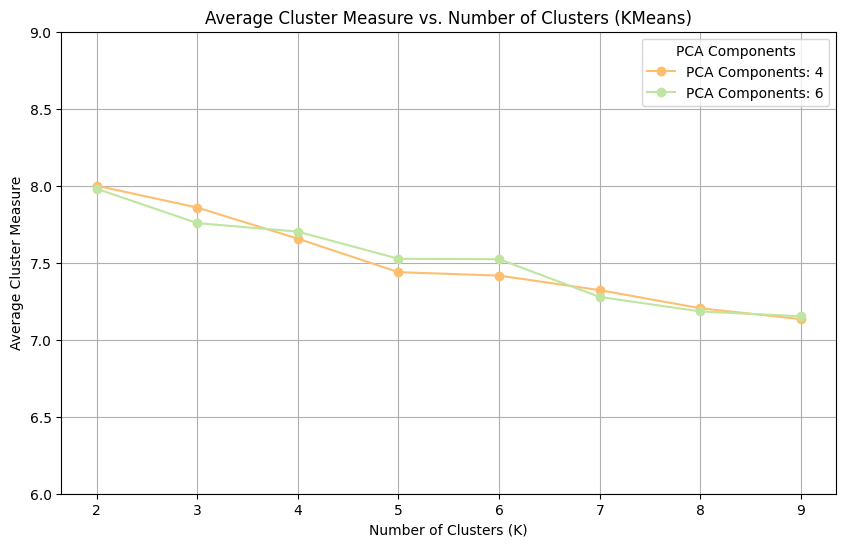

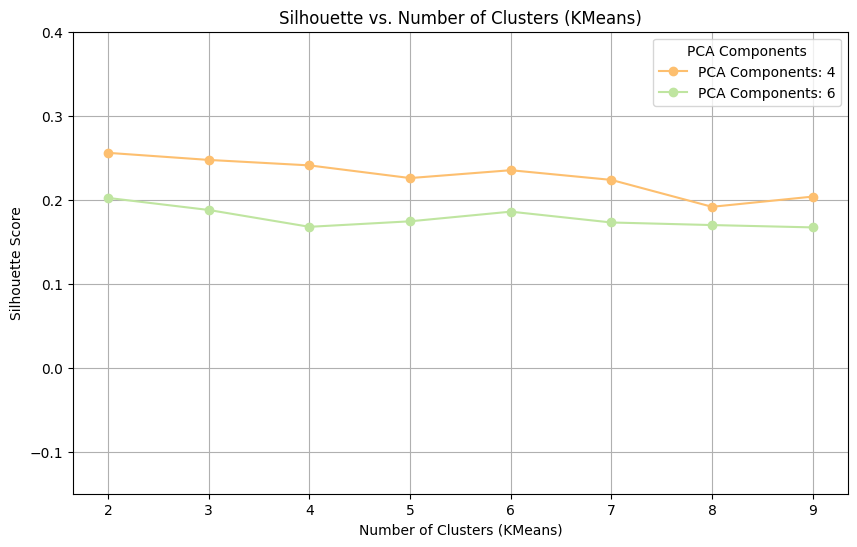


Sample of clustering results dataframe:
hh_index                                            ANON_ID  \
0         0045034694b28ba56978092fc4dd601c58774fd74c30b7...   
1         01b422497e7deb1a7c0ad65e11faabdd20dc9da6a4e520...   
2         01c05e36af0caaf19d6c35e0340d015ab07e742aa14fda...   
3         029cf457eace7f2a0ed8f55912f926ba9855f3748a117f...   
4         034d4493bbb8bd1ae4b7496160610c6a2ab00100a79a7c...   

hh_index  Cluster_Comp04_k02  Cluster_Comp04_k03  Cluster_Comp04_k04  \
0                          0                   2                   3   
1                          0                   2                   3   
2                          0                   2                   2   
3                          0                   2                   3   
4                          1                   1                   0   

hh_index  Cluster_Comp04_k05  Cluster_Comp04_k06  Cluster_Comp04_k07  \
0                          0                   0                   1   
1  


Transition Matrix (3 → 5 clusters):
Rows = Source clusters, Columns = Target clusters
col_0    0   1    2   3   4
row_0                      
0      261  17  100  13   0
1       19  83    4  50   4
2        2   6    4   5  56

Creating Sankey diagram: 4 → 7 clusters (PCA Components: 6)



Transition Matrix (4 → 7 clusters):
Rows = Source clusters, Columns = Target clusters
col_0    0   1   2   3   4   5  6
row_0                            
0      227  14  14   4  34   3  0
1        9  10  62  47   3   4  3
2        1  71   7   2  45   4  2
3        3   0   1   5  16  25  8

Creating Multi-Stage Sankey diagram: 4 → 5 → 6 → 7 clusters (PCA Components: 6)



MULTI-STAGE SANKEY SUMMARY
Sequence: 4 → 5 → 6 → 7
Stages: 4
Total flows: 59
Diagram size: 1800×1000 pixels
Flow statistics:
  - Minimum flow: 1 households
  - Maximum flow: 278 households
  - Average flow: 31.7 households

Creating Multi-Stage Sankey diagram: 3 → 4 → 5 → 6 clusters (PCA Components: 6)



MULTI-STAGE SANKEY SUMMARY
Sequence: 3 → 4 → 5 → 6
Stages: 4
Total flows: 44
Diagram size: 1800×1000 pixels
Flow statistics:
  - Minimum flow: 1 households
  - Maximum flow: 278 households
  - Average flow: 42.5 households

ANALYSIS COMPLETE!
✓ Generated 16 clustering configurations
✓ Created 16 consumption profile plots
✓ Generated 2 standard + 2 multi-stage Sankey diagrams
✓ Clustering results stored in df_clustering_results ((624, 17))

To create custom Sankey diagrams:
• Two-stage: create_sankey_diagram(df_clustering_results, data_24_values, n_components=X, k_from=Y, k_to=Z)
• Multi-stage: create_multi_stage_sankey(df_clustering_results, data_24_values, n_components=X, k_sequence=[A,B,C,D])


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.graph_objects as go
import os
os.environ["OMP_NUM_THREADS"] = "3"  # or set to 1, 2, depending on your CPU

manyclusters = 10

# ----------------------------------------------------------------------------
# 0) Prepare your data from df24_clean
# ----------------------------------------------------------------------------
df24_clean = df_pre_consumption_clean.copy()

# Create a results dataframe that will store all cluster labels
df_clustering_results = df24_clean[["ANON_ID"]].copy()  # Start with just ANON_ID

# Preserve ANON_ID as a column
anon_ids = df24_clean["ANON_ID"].values

# Prepare data for PCA and clustering
data_24 = df24_clean.drop(columns=["ANON_ID"])  # the 48 HH columns
data_24_values = data_24.values.astype(np.float64)

# Scale the data
scaler_raw = StandardScaler()
data_24_scaled = scaler_raw.fit_transform(data_24_values)

# ----------------------------------------------------------------------------
# 1) Range of PCA components and cluster counts
# ----------------------------------------------------------------------------
n_components_list = [4, 6]
clusters_range = range(2, manyclusters)

results = []

for n_comp in n_components_list:
    print(f"Processing PCA with {n_comp} components...")

    pca = PCA(n_components=n_comp, random_state=42)
    pca_scores = pca.fit_transform(data_24_scaled)

    scaler_pca = StandardScaler()
    pca_scores_scaled = scaler_pca.fit_transform(pca_scores)

    for k in clusters_range:
        print(f"  - Clustering with {k} clusters...")

        kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
        labels = kmeans.fit_predict(pca_scores_scaled)

        sil_score = silhouette_score(pca_scores_scaled, labels)

        cluster_centers_pca = scaler_pca.inverse_transform(kmeans.cluster_centers_)
        cluster_centers_scaled = pca.inverse_transform(cluster_centers_pca)
        cluster_centers_original = scaler_raw.inverse_transform(cluster_centers_scaled)

        avg_meas = average_clustermeasure_to_centroid(
            data_original=data_24_values,
            labels=labels,
            n_clusters=k,
            cluster_centroids=cluster_centers_original,
            alpha=0.8
        )

        # Store cluster labels in the results dataframe
        column_name = f"Cluster_Comp{n_comp:02d}_k{k:02d}"
        df_clustering_results[column_name] = labels

        # Plot consumption profiles for this configuration
        plt.figure(figsize=(12, 6))

        # Get cluster counts
        unique_clusters, cluster_counts = np.unique(labels, return_counts=True)

        # Plot each cluster profile
        for cluster_id in unique_clusters:
            cluster_mask = labels == cluster_id
            cluster_data = data_24_values[cluster_mask]
            mean_profile = np.mean(cluster_data, axis=0)
            count = cluster_counts[cluster_id]

            plt.plot(range(1, 49), mean_profile,
                    linewidth=2.5,
                    label=f'Cluster {cluster_id} ({count} households)')

        # Highlight 4-7pm period
        plt.axvspan(32, 38, alpha=0.15, color='#fbbf24', zorder=0)
        plt.text(35, plt.ylim()[1] * 0.9, '4-7 PM', ha='center', va='center',
                 fontsize=10, fontweight='bold', color='#92400e')

        plt.title(f'Consumption Profiles - {n_comp} PCA Components, {k} Clusters',
                  fontsize=14, fontweight='bold')
        plt.xlabel('Half-hour Interval', fontsize=12)
        plt.ylabel('Consumption (kWh)', fontsize=12)
        plt.grid(True, alpha=0.3)

        # Time labels
        time_positions = [1, 13, 25, 37, 49]
        time_labels = ['12AM', '6AM', '12PM', '6PM', '12AM']
        plt.xticks(time_positions, time_labels)

        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.ylim(0,0.55)
        plt.show()

        results.append({
            "n_components": n_comp,
            "n_clusters": k,
            "silhouette": sil_score,
            "avg_clustermeasure": avg_meas,
            "column_name": column_name
        })

print(f"\nCompleted! Added {len(results)} clustering columns to the dataframe.")
print(f"DataFrame shape: {df_clustering_results.shape}")
print(f"Columns added: {[col for col in df_clustering_results.columns if col.startswith('Cluster_')]}")

# ----------------------------------------------------------------------------
# 2) Plot Results
# ----------------------------------------------------------------------------
results_df = pd.DataFrame(results)
print("\nResults Summary:")
print(results_df[["n_components", "n_clusters", "silhouette", "avg_clustermeasure"]].head(10))

plt.figure(figsize=(10, 6))
colors = sns.color_palette("Spectral", len(results_df["n_components"].unique()))

for i, n_comp in enumerate(results_df["n_components"].unique()):
    subset = results_df[results_df["n_components"] == n_comp]
    plt.plot(
        subset["n_clusters"], subset["avg_clustermeasure"], marker='o', linestyle='-',
        label=f'PCA Components: {n_comp}', color=colors[i]
    )

plt.title('Average Cluster Measure vs. Number of Clusters (KMeans)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Average Cluster Measure')
plt.xticks(range(2, manyclusters))
plt.legend(title="PCA Components")
plt.grid(True)
plt.ylim(6, 9)
plt.show()

plt.figure(figsize=(10, 6))
colors = sns.color_palette("Spectral", len(results_df["n_components"].unique()))

for i, n_comp in enumerate(results_df["n_components"].unique()):
    subset = results_df[results_df["n_components"] == n_comp]
    plt.plot(
        subset["n_clusters"], subset["silhouette"], marker='o', linestyle='-',
        label=f'PCA Components: {n_comp}', color=colors[i]
    )

plt.title("Silhouette vs. Number of Clusters (KMeans)")
plt.xlabel("Number of Clusters (KMeans)")
plt.ylabel("Silhouette Score")
plt.xticks(range(2, manyclusters))
plt.legend(title="PCA Components")
plt.grid(True)
plt.ylim(-0.15, 0.4)
plt.show()

# ----------------------------------------------------------------------------
# 3) Display sample of the clustering results dataframe
# ----------------------------------------------------------------------------
print(f"\nSample of clustering results dataframe:")
print(df_clustering_results.head())

print(f"\nExample: To access clusters for 6 components and 7 clusters:")
print(f"df_clustering_results['Cluster_Comp06_k07'].value_counts()")

# Optional: Save the clustering results to CSV
# df_clustering_results.to_csv("clustering_results_all_combinations.csv", index=False)
# print("Saved clustering results to 'clustering_results_all_combinations.csv'")

# ----------------------------------------------------------------------------
# 4) Sankey Diagram Functions
# ----------------------------------------------------------------------------

def rename_clusters_by_consumption(labels, data_values):
    """
    Rename clusters based on their mean consumption (ascending order)

    Parameters:
    - labels: cluster assignments for each household
    - data_values: consumption data (households x 48 half-hours)

    Returns:
    - renamed_labels: labels with clusters renamed 0, 1, 2... by increasing mean consumption
    - cluster_means: mean consumption for each renamed cluster
    """
    unique_clusters = np.unique(labels)
    cluster_means = []

    # Calculate mean consumption for each cluster
    for cluster in unique_clusters:
        cluster_mask = labels == cluster
        cluster_data = data_values[cluster_mask]
        mean_consumption = np.mean(cluster_data)
        cluster_means.append((cluster, mean_consumption))

    # Sort by mean consumption
    cluster_means.sort(key=lambda x: x[1])

    # Create mapping from old cluster ID to new cluster ID
    cluster_mapping = {}
    sorted_means = []
    for new_id, (old_id, mean_val) in enumerate(cluster_means):
        cluster_mapping[old_id] = new_id
        sorted_means.append(mean_val)

    # Apply mapping to labels
    renamed_labels = np.array([cluster_mapping[label] for label in labels])

    return renamed_labels, sorted_means

def create_sankey_diagram(df_clustering_results, data_24_values,
                         n_components, k_from, k_to,
                         title_suffix=""):
    """
    Create Sankey diagram showing cluster transitions

    Parameters:
    - df_clustering_results: dataframe with all clustering results
    - data_24_values: original consumption data
    - n_components: number of PCA components to analyze
    - k_from: initial number of clusters
    - k_to: final number of clusters
    - title_suffix: additional text for title
    """

    # Get column names
    col_from = f"Cluster_Comp{n_components:02d}_k{k_from:02d}"
    col_to = f"Cluster_Comp{n_components:02d}_k{k_to:02d}"

    if col_from not in df_clustering_results.columns or col_to not in df_clustering_results.columns:
        print(f"Error: Required columns {col_from} or {col_to} not found!")
        return None, None

    # Get original cluster assignments
    labels_from_orig = df_clustering_results[col_from].values
    labels_to_orig = df_clustering_results[col_to].values

    # Rename clusters by consumption
    labels_from, means_from = rename_clusters_by_consumption(labels_from_orig, data_24_values)
    labels_to, means_to = rename_clusters_by_consumption(labels_to_orig, data_24_values)

    # Create transition matrix
    transition_counts = pd.crosstab(labels_from, labels_to, margins=False)

    # Prepare Sankey diagram data
    source_nodes = []
    target_nodes = []
    values = []

    # Node labels and colors
    source_labels = [f"C{i}\n({len(labels_from[labels_from==i])} HH)\nAvg: {means_from[i]:.3f}"
                    for i in range(k_from)]
    target_labels = [f"C{i}\n({len(labels_to[labels_to==i])} HH)\nAvg: {means_to[i]:.3f}"
                    for i in range(k_to)]

    all_labels = source_labels + target_labels

    # Colors: gradient from blue (low consumption) to red (high consumption)
    def get_color(consumption_rank, total_clusters):
        # Normalize to 0-1 range
        norm_rank = consumption_rank / (total_clusters - 1) if total_clusters > 1 else 0
        # Blue to red gradient
        red = int(255 * norm_rank)
        blue = int(255 * (1 - norm_rank))
        return f"rgba({red}, 100, {blue}, 0.8)"

    source_colors = [get_color(i, k_from) for i in range(k_from)]
    target_colors = [get_color(i, k_to) for i in range(k_to)]
    all_colors = source_colors + target_colors

    # Build flows
    for from_cluster in range(k_from):
        for to_cluster in range(k_to):
            if transition_counts.iloc[from_cluster, to_cluster] > 0:
                source_nodes.append(from_cluster)  # Source node index
                target_nodes.append(k_from + to_cluster)  # Target node index (offset by k_from)
                values.append(transition_counts.iloc[from_cluster, to_cluster])

    # Create Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=all_labels,
            color=all_colors
        ),
        link=dict(
            source=source_nodes,
            target=target_nodes,
            value=values,
            color=[all_colors[s].replace('0.8', '0.4') for s in source_nodes]  # Semi-transparent links
        )
    )])

    fig.update_layout(
        title=f"Cluster Transitions: {k_from} → {k_to} Clusters ({n_components} PCA Components){title_suffix}",
        font_size=12,
        width=1000,
        height=600
    )

    # Add subtitle with explanation
    fig.add_annotation(
        text="Clusters renamed by average consumption (C0=lowest, C{}=highest)<br>HH=households".format(max(k_from, k_to)-1),
        xref="paper", yref="paper",
        x=0.5, y=-0.1, showarrow=False,
        font=dict(size=10, color="gray")
    )

    fig.show()

    # Print transition matrix
    print(f"\nTransition Matrix ({k_from} → {k_to} clusters):")
    print("Rows = Source clusters, Columns = Target clusters")
    print(transition_counts)

    return fig, transition_counts

def create_multi_stage_sankey(df_clustering_results, data_24_values,
                             n_components, k_sequence,
                             title_suffix=""):
    """
    Create multi-stage Sankey diagram showing cluster evolution through multiple stages

    Parameters:
    - df_clustering_results: dataframe with all clustering results
    - data_24_values: original consumption data
    - n_components: number of PCA components to analyze
    - k_sequence: list of cluster numbers (e.g., [4, 5, 6, 7])
    - title_suffix: additional text for title
    """

    # Verify all required columns exist
    required_cols = [f"Cluster_Comp{n_components:02d}_k{k:02d}" for k in k_sequence]
    missing_cols = [col for col in required_cols if col not in df_clustering_results.columns]
    if missing_cols:
        print(f"Error: Missing columns: {missing_cols}")
        return None

    # Prepare data for each stage
    all_labels = []
    all_means = []

    for k in k_sequence:
        col_name = f"Cluster_Comp{n_components:02d}_k{k:02d}"
        labels_orig = df_clustering_results[col_name].values
        labels_renamed, means = rename_clusters_by_consumption(labels_orig, data_24_values)
        all_labels.append(labels_renamed)
        all_means.append(means)

    # Calculate node positions
    total_nodes = sum(k_sequence)
    node_offset = 0
    stage_offsets = []

    for k in k_sequence:
        stage_offsets.append(node_offset)
        node_offset += k

    # Build node labels and colors
    all_node_labels = []
    all_node_colors = []

    def get_color(consumption_rank, total_clusters):
        norm_rank = consumption_rank / (total_clusters - 1) if total_clusters > 1 else 0
        red = int(255 * norm_rank)
        blue = int(255 * (1 - norm_rank))
        return f"rgba({red}, 100, {blue}, 0.8)"

    for stage_idx, k in enumerate(k_sequence):
        labels = all_labels[stage_idx]
        means = all_means[stage_idx]

        for cluster_id in range(k):
            count = len(labels[labels == cluster_id])
            # Shorter, cleaner labels to reduce overlap
            label = f"K{k}-C{cluster_id}<br>({count})<br>{means[cluster_id]:.3f}"
            all_node_labels.append(label)
            all_node_colors.append(get_color(cluster_id, k))

    # Build flows between consecutive stages
    source_nodes = []
    target_nodes = []
    values = []
    link_colors = []

    for stage_idx in range(len(k_sequence) - 1):
        k_from = k_sequence[stage_idx]
        k_to = k_sequence[stage_idx + 1]

        labels_from = all_labels[stage_idx]
        labels_to = all_labels[stage_idx + 1]

        # Create transition matrix for this stage
        transition_counts = pd.crosstab(labels_from, labels_to, margins=False)

        # Add flows
        for from_cluster in range(k_from):
            for to_cluster in range(k_to):
                if transition_counts.iloc[from_cluster, to_cluster] > 0:
                    source_idx = stage_offsets[stage_idx] + from_cluster
                    target_idx = stage_offsets[stage_idx + 1] + to_cluster

                    source_nodes.append(source_idx)
                    target_nodes.append(target_idx)
                    values.append(transition_counts.iloc[from_cluster, to_cluster])

                    # Link color based on source cluster
                    source_color = all_node_colors[source_idx].replace('0.8', '0.3')
                    link_colors.append(source_color)

    # Calculate dynamic sizing based on complexity
    max_k = max(k_sequence)
    num_stages = len(k_sequence)

    # Dynamic width and height based on complexity
    width = max(1800, 400 * num_stages)  # Minimum 1800px, scales with stages
    height = max(1000, 120 * max_k)      # Minimum 1000px, scales with max clusters

    # Improved node positioning to prevent overlap
    x_positions = []
    y_positions = []

    for stage_idx, k in enumerate(k_sequence):
        # X position: evenly spaced across the width with more margin
        x_pos = 0.08 + 0.84 * stage_idx / (len(k_sequence) - 1) if len(k_sequence) > 1 else 0.5

        for cluster_id in range(k):
            # Y position: more spacing between nodes
            if k == 1:
                y_pos = 0.5
            else:
                y_pos = 0.1 + 0.8 * cluster_id / (k - 1)

            x_positions.append(x_pos)
            y_positions.append(y_pos)

    # Create the multi-stage Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=25,           # Increased padding between nodes
            thickness=30,     # Thicker nodes for better visibility
            line=dict(color="black", width=1),
            label=all_node_labels,
            color=all_node_colors,
            x=x_positions,
            y=y_positions
        ),
        link=dict(
            source=source_nodes,
            target=target_nodes,
            value=values,
            color=link_colors
        )
    )])

    # Format title
    k_sequence_str = " → ".join(map(str, k_sequence))

    # Enhanced layout with better sizing and margins
    fig.update_layout(
        title=dict(
            text=f"Multi-Stage Cluster Evolution: {k_sequence_str} Clusters", #<br>({n_components} PCA Components){title_suffix}",
            font=dict(size=18),
            x=0.5,
            xanchor='center'
        ),
        font=dict(size=12),
        width=width,
        height=height,
        margin=dict(l=50, r=50, t=100, b=100),  # Increased margins
        showlegend=False
    )

    # Add subtitle with better positioning
    fig.add_annotation(
        text=f"Evolution through {len(k_sequence)} stages • Clusters by consumption (C0=lowest) • Numbers show household counts",
        xref="paper", yref="paper",
        x=0.5, y=-0.08,
        showarrow=False,
        font=dict(size=12, color="gray"),
        xanchor='center'
    )

    # Add stage labels at the top
    for stage_idx, k in enumerate(k_sequence):
        x_pos = 0.08 + 0.84 * stage_idx / (len(k_sequence) - 1) if len(k_sequence) > 1 else 0.5
        fig.add_annotation(
            text=f"<b>{k} Clusters</b>",
            xref="paper", yref="paper",
            x=x_pos, y=1.05,
            showarrow=False,
            font=dict(size=14, color="black"),
            xanchor='center'
        )

    fig.show()

    # Print detailed transition summary
    print(f"\n" + "="*60)
    print(f"MULTI-STAGE SANKEY SUMMARY")
    print(f"="*60)
    print(f"Sequence: {k_sequence_str}")
    print(f"Stages: {len(k_sequence)}")
    print(f"Total flows: {len(values)}")
    print(f"Diagram size: {width}×{height} pixels")

    # Show flow statistics
    if values:
        print(f"Flow statistics:")
        print(f"  - Minimum flow: {min(values)} households")
        print(f"  - Maximum flow: {max(values)} households")
        print(f"  - Average flow: {sum(values)/len(values):.1f} households")

    return fig

# def create_multi_stage_sankey(df_clustering_results, data_24_values,
#                              n_components, k_sequence,
#                              title_suffix=""):
#     """
#     Create multi-stage Sankey diagram showing cluster evolution through multiple stages

#     Parameters:
#     - df_clustering_results: dataframe with all clustering results
#     - data_24_values: original consumption data
#     - n_components: number of PCA components to analyze
#     - k_sequence: list of cluster numbers (e.g., [4, 5, 6, 7])
#     - title_suffix: additional text for title
#     """

#     # Verify all required columns exist
#     required_cols = [f"Cluster_Comp{n_components:02d}_k{k:02d}" for k in k_sequence]
#     missing_cols = [col for col in required_cols if col not in df_clustering_results.columns]
#     if missing_cols:
#         print(f"Error: Missing columns: {missing_cols}")
#         return None

#     # Prepare data for each stage
#     all_labels = []
#     all_means = []

#     for k in k_sequence:
#         col_name = f"Cluster_Comp{n_components:02d}_k{k:02d}"
#         labels_orig = df_clustering_results[col_name].values
#         labels_renamed, means = rename_clusters_by_consumption(labels_orig, data_24_values)
#         all_labels.append(labels_renamed)
#         all_means.append(means)

#     # Calculate node positions
#     total_nodes = sum(k_sequence)
#     node_offset = 0
#     stage_offsets = []

#     for k in k_sequence:
#         stage_offsets.append(node_offset)
#         node_offset += k

#     # Build node labels and colors
#     all_node_labels = []
#     all_node_colors = []

#     def get_color(consumption_rank, total_clusters):
#         norm_rank = consumption_rank / (total_clusters - 1) if total_clusters > 1 else 0
#         red = int(255 * norm_rank)
#         blue = int(255 * (1 - norm_rank))
#         return f"rgba({red}, 100, {blue}, 0.8)"

#     for stage_idx, k in enumerate(k_sequence):
#         labels = all_labels[stage_idx]
#         means = all_means[stage_idx]

#         for cluster_id in range(k):
#             count = len(labels[labels == cluster_id])
#             label = f"K{k}\nC{cluster_id}\n({count} HH)\n{means[cluster_id]:.3f}"
#             all_node_labels.append(label)
#             all_node_colors.append(get_color(cluster_id, k))

#     # Build flows between consecutive stages
#     source_nodes = []
#     target_nodes = []
#     values = []
#     link_colors = []

#     for stage_idx in range(len(k_sequence) - 1):
#         k_from = k_sequence[stage_idx]
#         k_to = k_sequence[stage_idx + 1]

#         labels_from = all_labels[stage_idx]
#         labels_to = all_labels[stage_idx + 1]

#         # Create transition matrix for this stage
#         transition_counts = pd.crosstab(labels_from, labels_to, margins=False)

#         # Add flows
#         for from_cluster in range(k_from):
#             for to_cluster in range(k_to):
#                 if transition_counts.iloc[from_cluster, to_cluster] > 0:
#                     source_idx = stage_offsets[stage_idx] + from_cluster
#                     target_idx = stage_offsets[stage_idx + 1] + to_cluster

#                     source_nodes.append(source_idx)
#                     target_nodes.append(target_idx)
#                     values.append(transition_counts.iloc[from_cluster, to_cluster])

#                     # Link color based on source cluster
#                     source_color = all_node_colors[source_idx].replace('0.8', '0.3')
#                     link_colors.append(source_color)

#     # Create the multi-stage Sankey diagram
#     fig = go.Figure(data=[go.Sankey(
#         node=dict(
#             pad=15,
#             thickness=20,
#             line=dict(color="black", width=0.5),
#             label=all_node_labels,
#             color=all_node_colors,
#             x=[0.1 + 0.8 * i / (len(k_sequence) - 1) for i in range(len(k_sequence)) for _ in range(k_sequence[i])],
#             y=[0.1 + 0.8 * j / (k - 1) if k > 1 else 0.5 for k in k_sequence for j in range(k)]
#         ),
#         link=dict(
#             source=source_nodes,
#             target=target_nodes,
#             value=values,
#             color=link_colors
#         )
#     )])

#     # Format title
#     k_sequence_str = " → ".join(map(str, k_sequence))
#     fig.update_layout(
#         title=f"Multi-Stage Cluster Evolution: {k_sequence_str} Clusters ({n_components} PCA Components){title_suffix}",
#         font_size=12,
#         width=1400,
#         height=800
#     )

#     # Add subtitle
#     fig.add_annotation(
#         text=f"Showing evolution through {len(k_sequence)} stages • Clusters renamed by consumption (C0=lowest) • HH=households",
#         xref="paper", yref="paper",
#         x=0.5, y=-0.1, showarrow=False,
#         font=dict(size=10, color="gray")
#     )

#     fig.show()

#     # Print transition summary
#     print(f"\nMulti-stage transitions: {k_sequence_str}")
#     print(f"Total stages: {len(k_sequence)}")
#     print(f"Total flows: {len(values)}")

#     return fig

# ----------------------------------------------------------------------------
# 5) Example Sankey Diagrams
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("CREATING SANKEY DIAGRAMS")
print("="*80)

# Set parameters for Sankey analysis
sankey_components = 6  # Choose your PCA components for analysis

# Example 1: 3 clusters to 5 clusters
print(f"\nCreating Sankey diagram: 3 → 5 clusters (PCA Components: {sankey_components})")
fig1, matrix1 = create_sankey_diagram(
    df_clustering_results, data_24_values,
    n_components=sankey_components,
    k_from=3, k_to=5,
    title_suffix=" - Low to Medium Granularity"
)

# Example 2: 4 clusters to 7 clusters
print(f"\nCreating Sankey diagram: 4 → 7 clusters (PCA Components: {sankey_components})")
fig2, matrix2 = create_sankey_diagram(
    df_clustering_results, data_24_values,
    n_components=sankey_components,
    k_from=4, k_to=7,
    title_suffix=""
)

# Example 3: Multi-stage evolution (4 → 5 → 6 → 7 clusters)
print(f"\nCreating Multi-Stage Sankey diagram: 4 → 5 → 6 → 7 clusters (PCA Components: {sankey_components})")
fig_multi = create_multi_stage_sankey(
    df_clustering_results, data_24_values,
    n_components=sankey_components,
    k_sequence=[4, 5, 6, 7],
    title_suffix=""
)

# Additional multi-stage examples
print(f"\nCreating Multi-Stage Sankey diagram: 3 → 4 → 5 → 6 clusters (PCA Components: {sankey_components})")
fig_multi2 = create_multi_stage_sankey(
    df_clustering_results, data_24_values,
    n_components=sankey_components,
    k_sequence=[3, 4, 5, 6],
    title_suffix=""
)

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print(f"✓ Generated {len(results)} clustering configurations")
print(f"✓ Created {len(results)} consumption profile plots")
print(f"✓ Generated 2 standard + 2 multi-stage Sankey diagrams")
print(f"✓ Clustering results stored in df_clustering_results ({df_clustering_results.shape})")
print("\nTo create custom Sankey diagrams:")
print("• Two-stage: create_sankey_diagram(df_clustering_results, data_24_values, n_components=X, k_from=Y, k_to=Z)")
print("• Multi-stage: create_multi_stage_sankey(df_clustering_results, data_24_values, n_components=X, k_sequence=[A,B,C,D])")

# CLUSTER MAPPING

Processing PCA with 4 components...
  - Clustering with 2 clusters...
  - Clustering with 3 clusters...
  - Clustering with 4 clusters...
  - Clustering with 5 clusters...
  - Clustering with 6 clusters...
  - Clustering with 7 clusters...
  - Clustering with 8 clusters...
  - Clustering with 9 clusters...
Processing PCA with 6 components...
  - Clustering with 2 clusters...
  - Clustering with 3 clusters...
  - Clustering with 4 clusters...
  - Clustering with 5 clusters...
  - Clustering with 6 clusters...
  - Clustering with 7 clusters...
  - Clustering with 8 clusters...
  - Clustering with 9 clusters...

Completed clustering! Added 16 clustering columns to the dataframe.
DataFrame shape: (624, 17)

APPLYING CONSUMPTION-BASED ORDERING TO ALL CLUSTERING COLUMNS
Applying consumption-based ordering to 16 clustering columns...
  Processing Cluster_Comp04_k02...
    Original → New mapping: {np.int32(0): 0, np.int32(1): 1}
    Cluster means (ascending): ['0.128', '0.220']
  Processing Cl

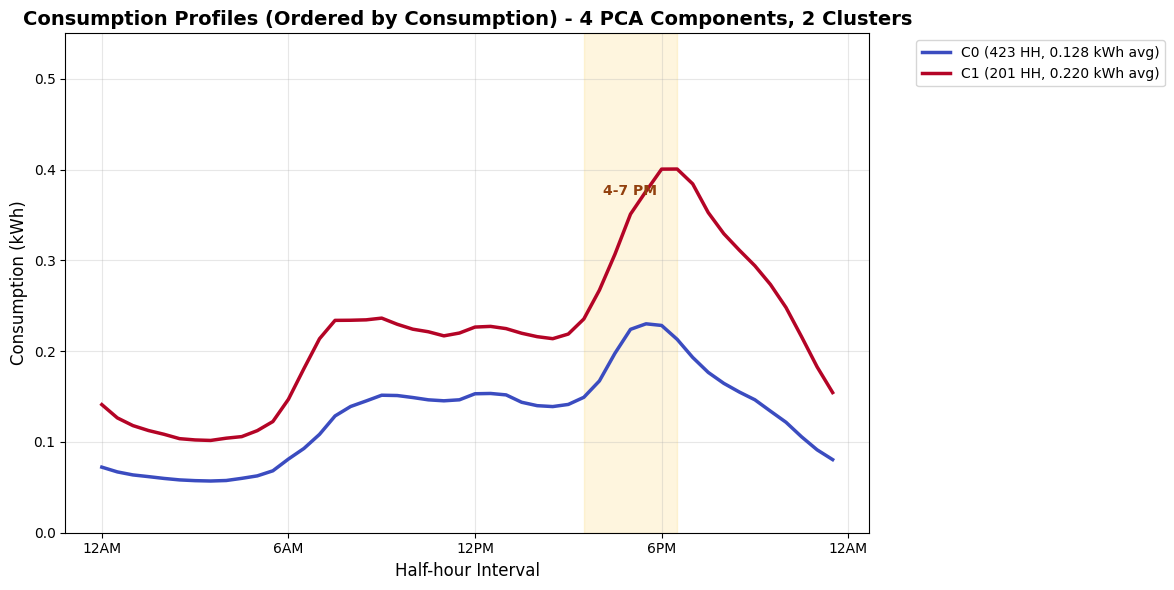

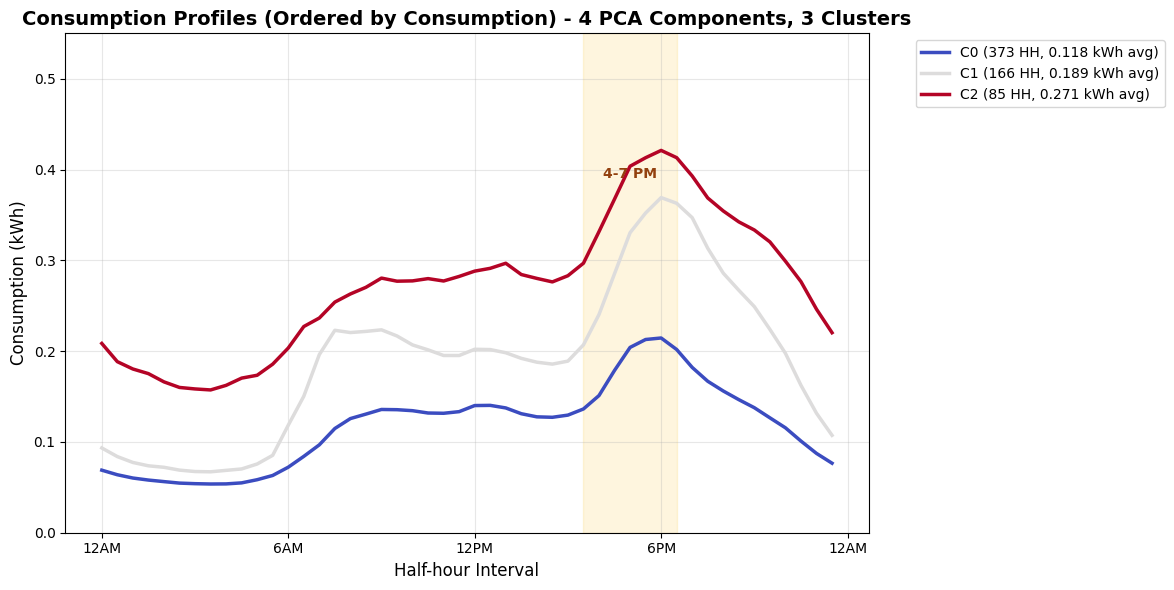

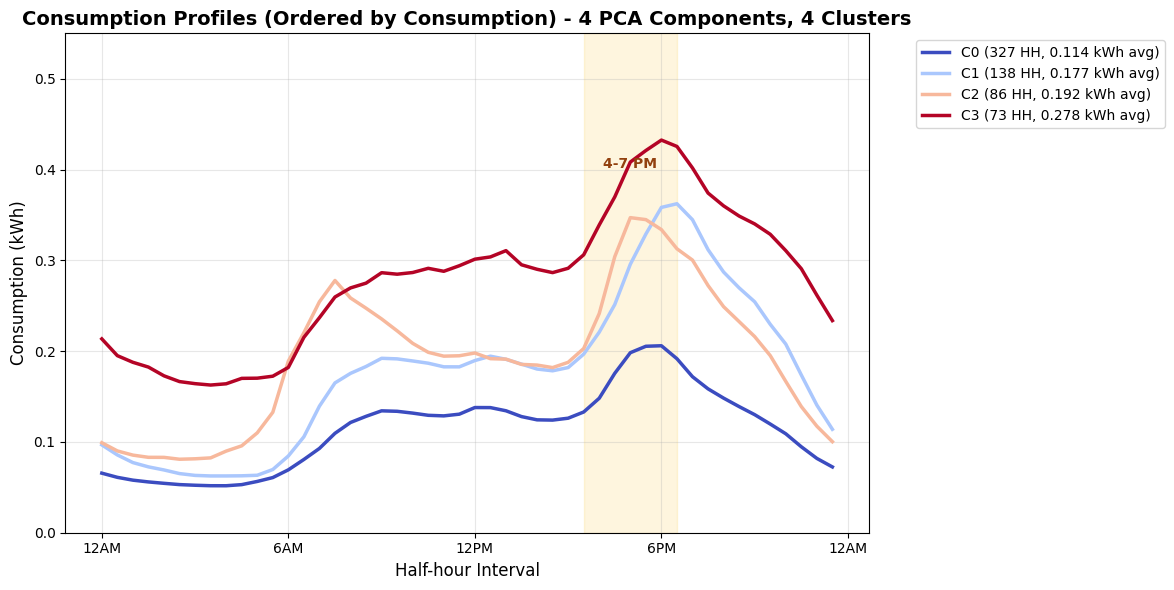

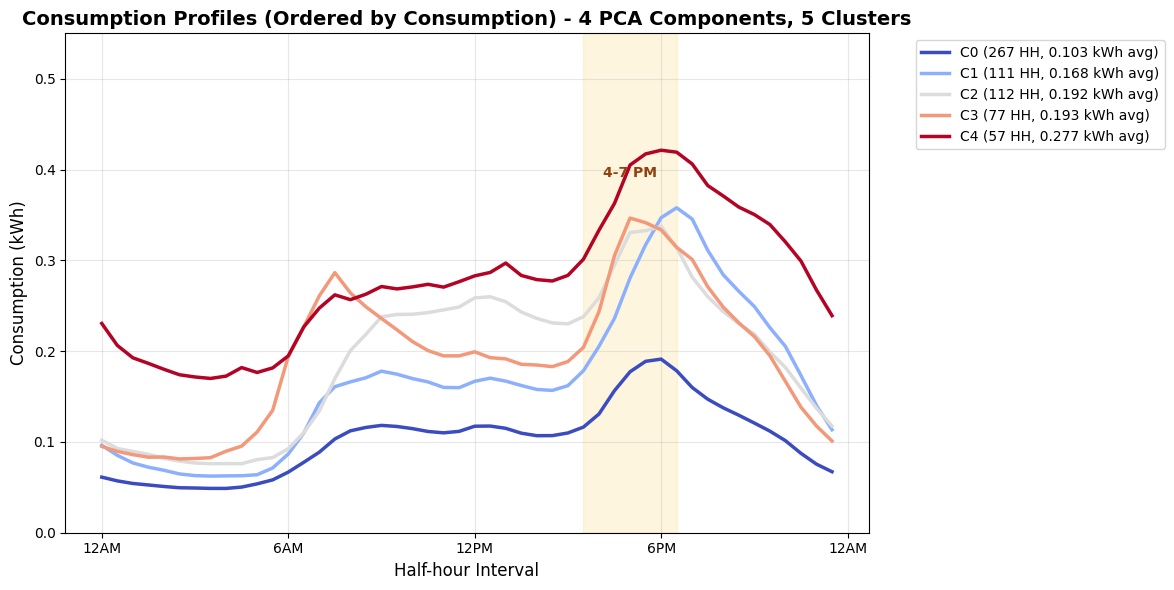

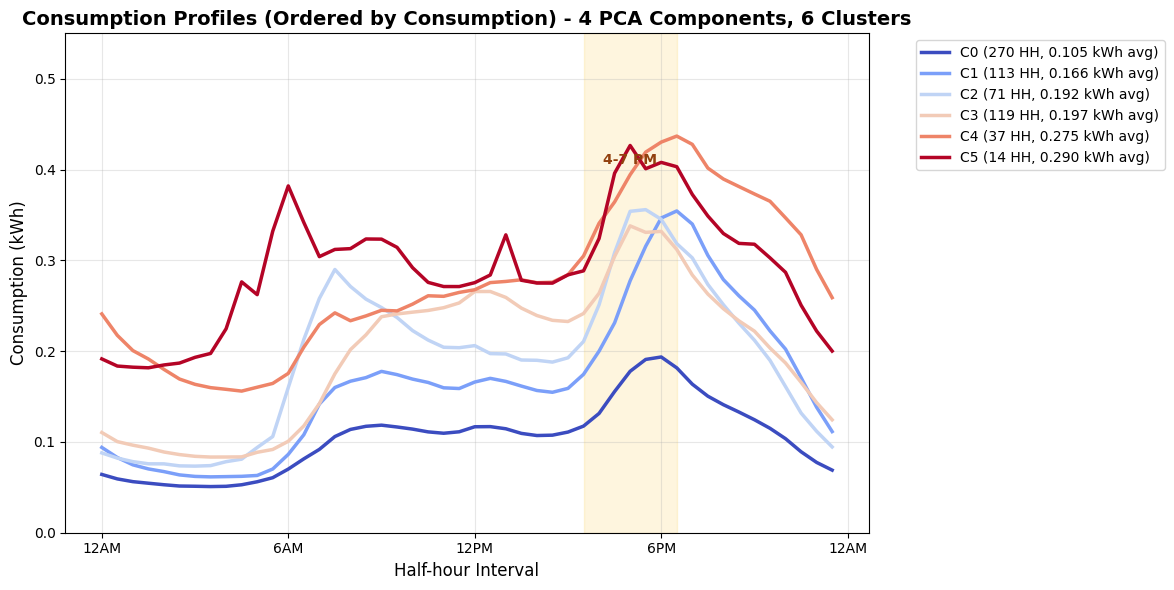

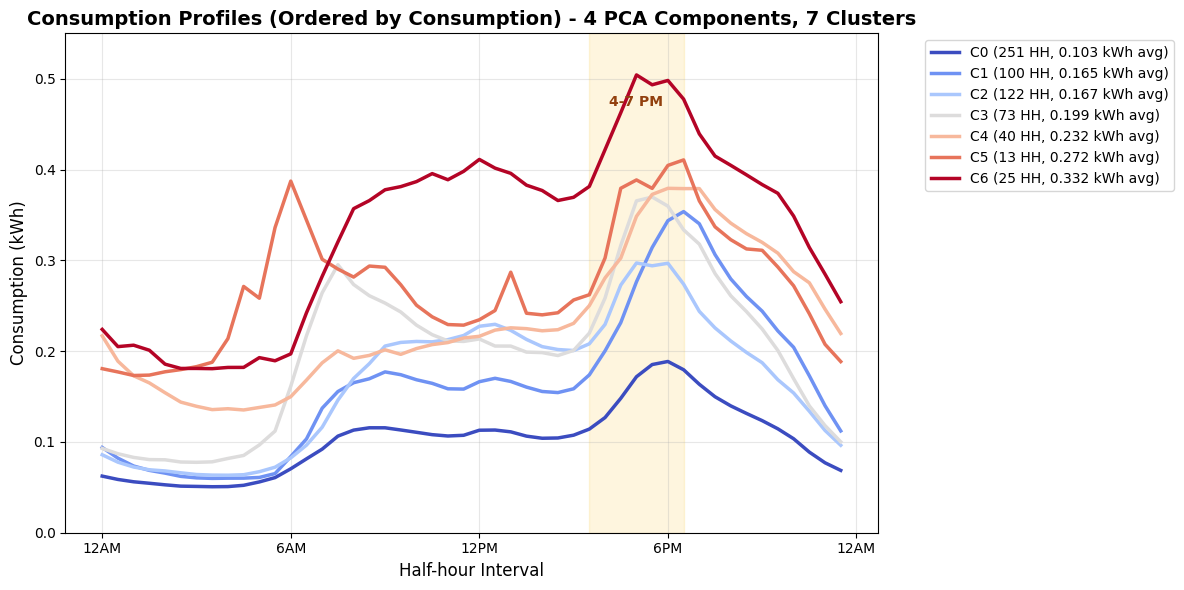

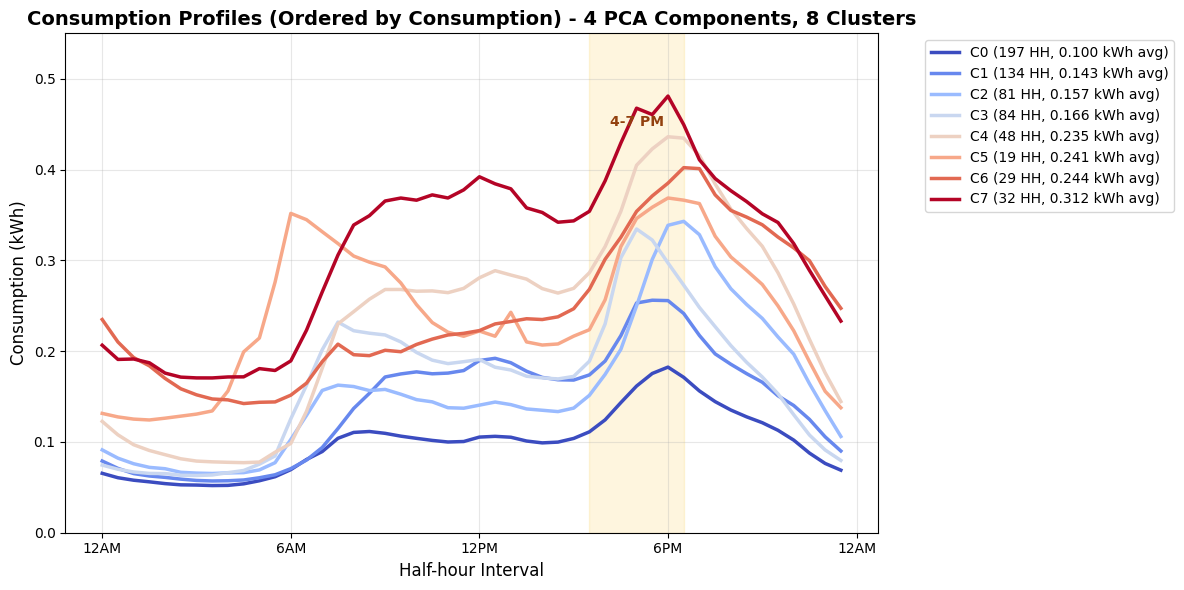

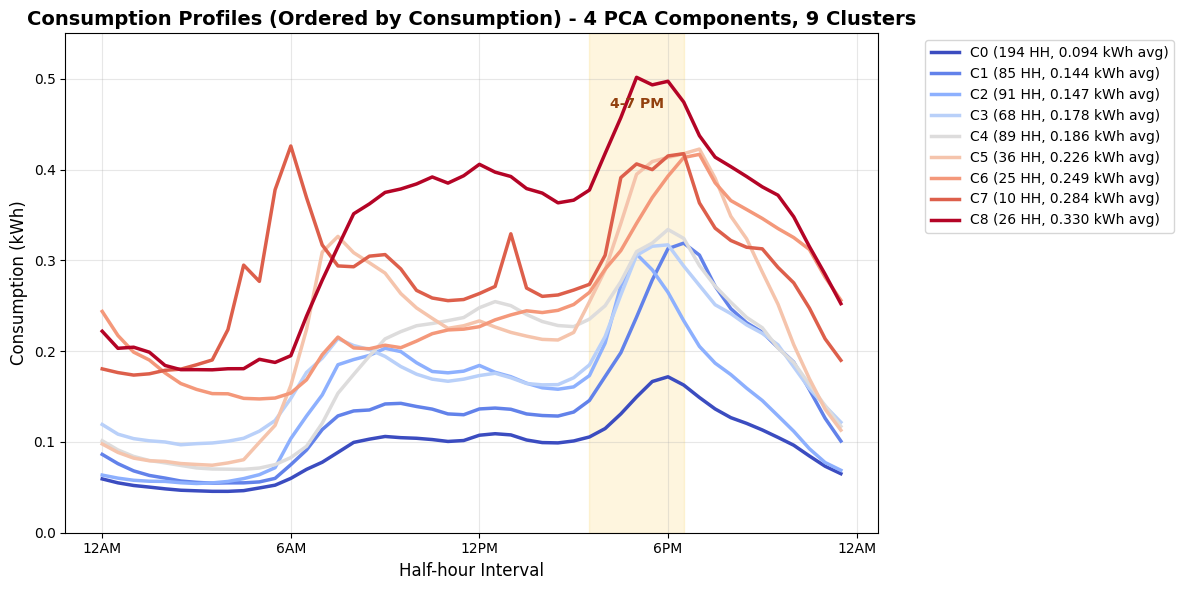

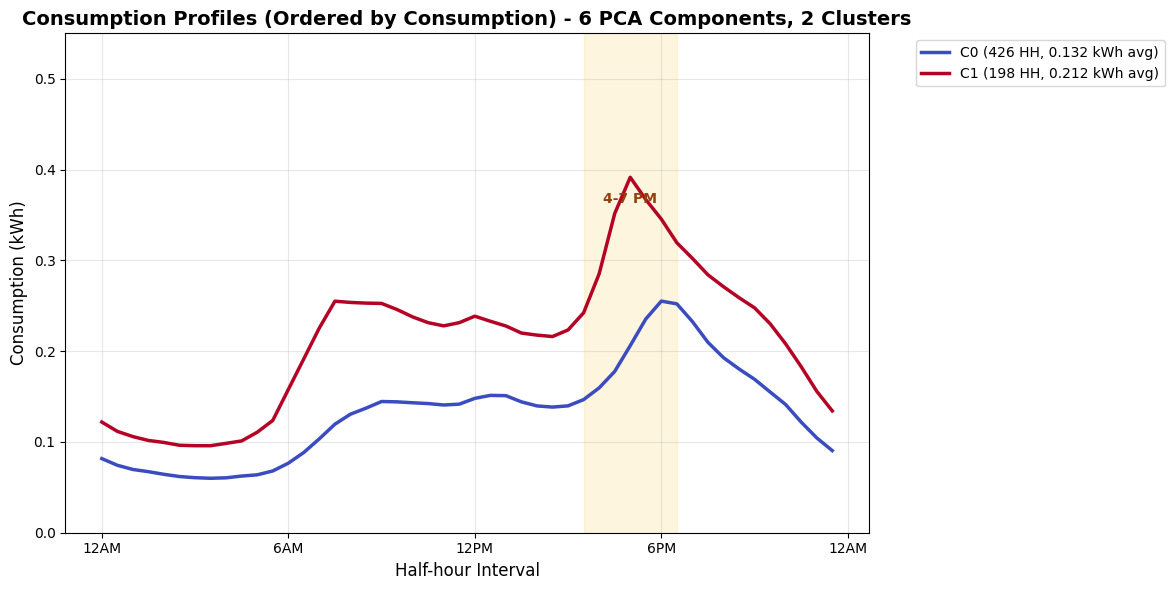

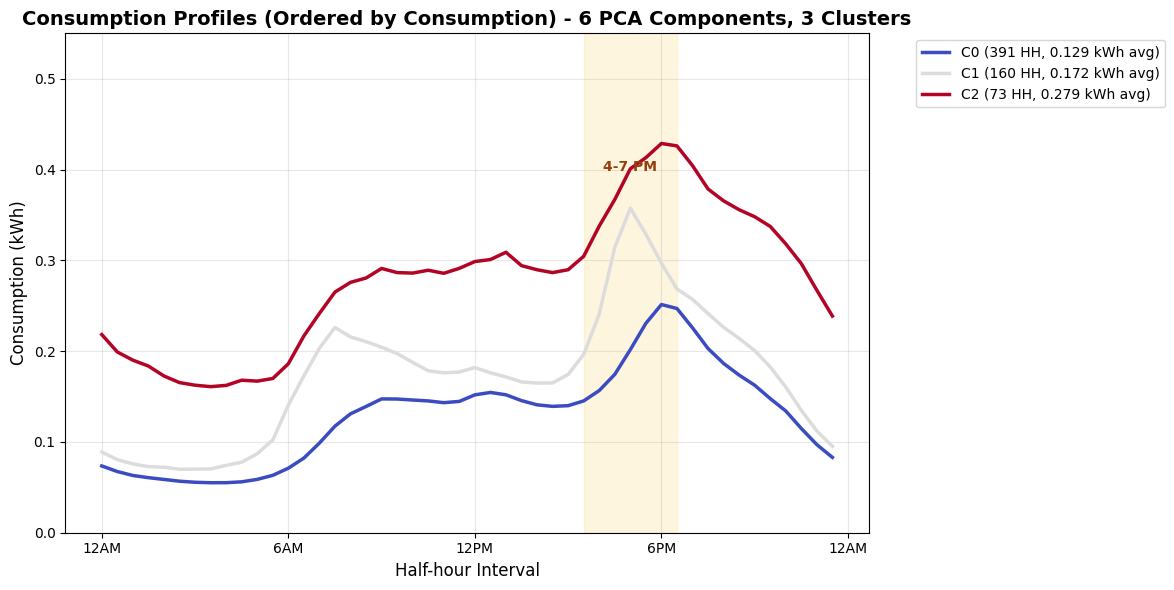

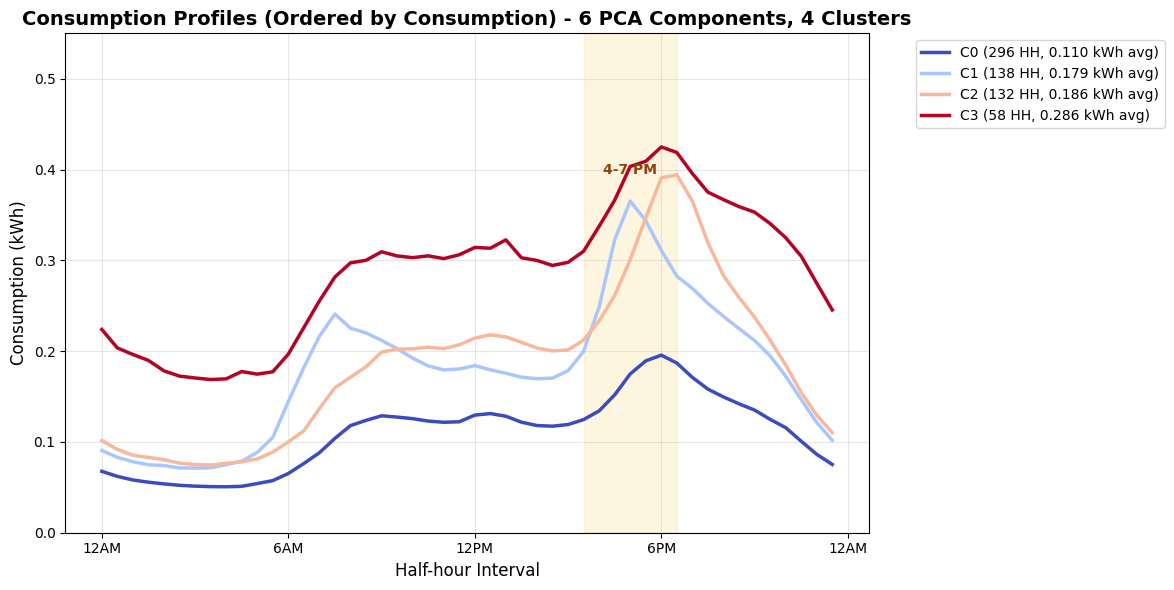

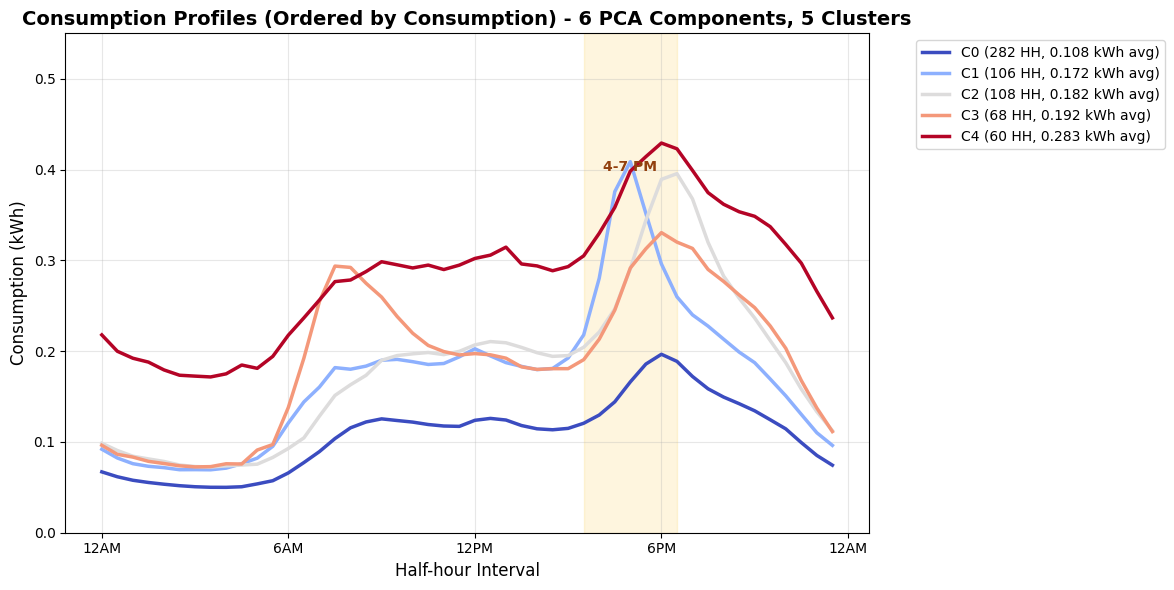

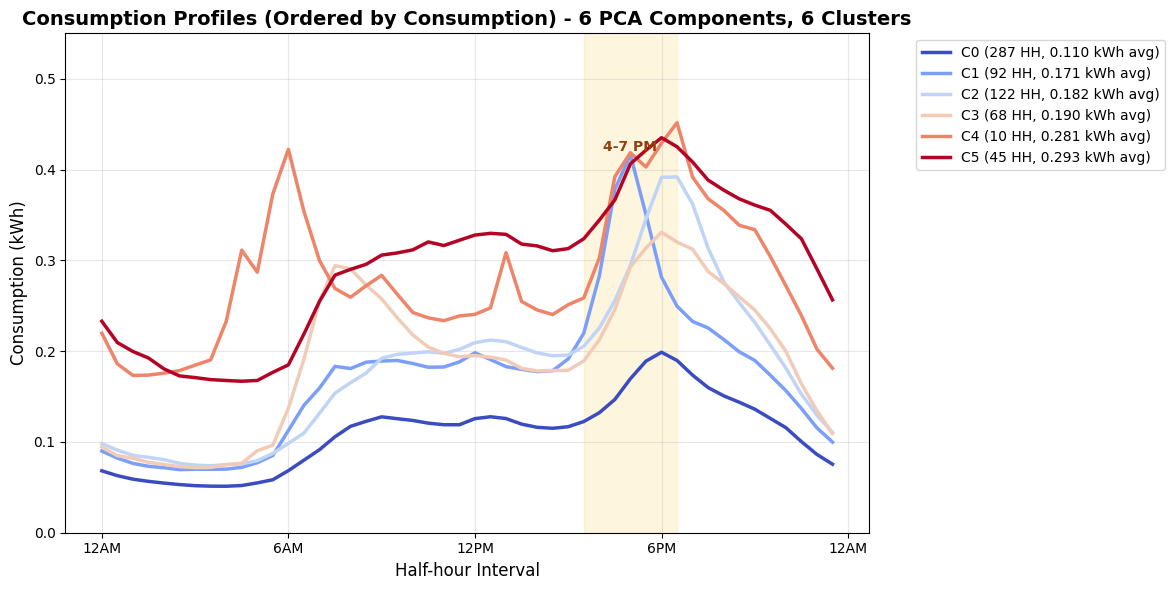

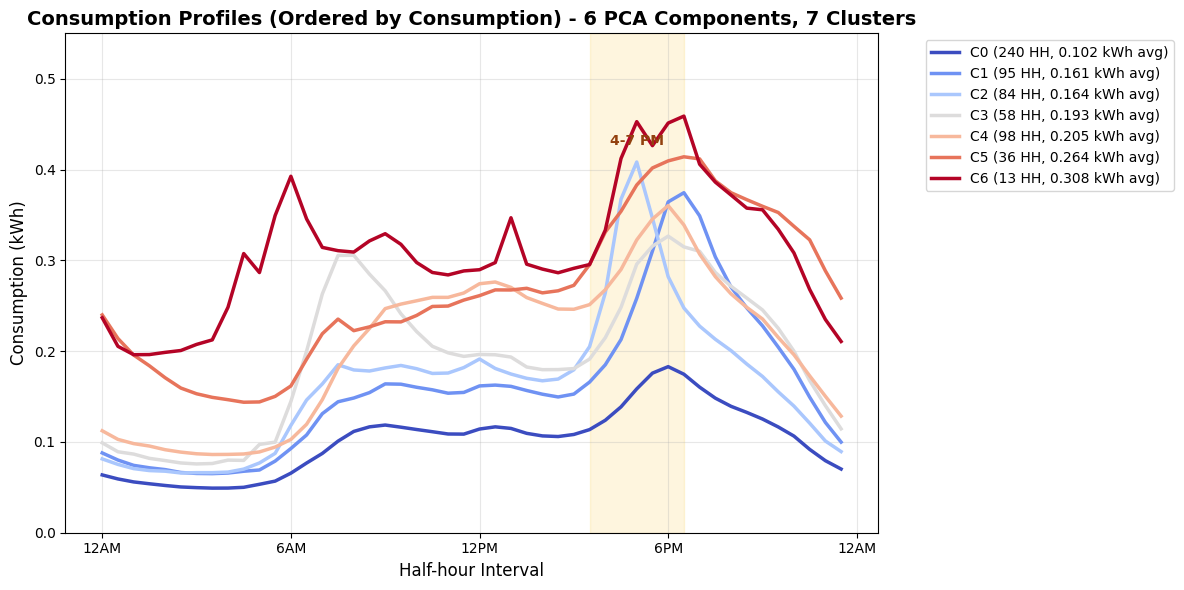

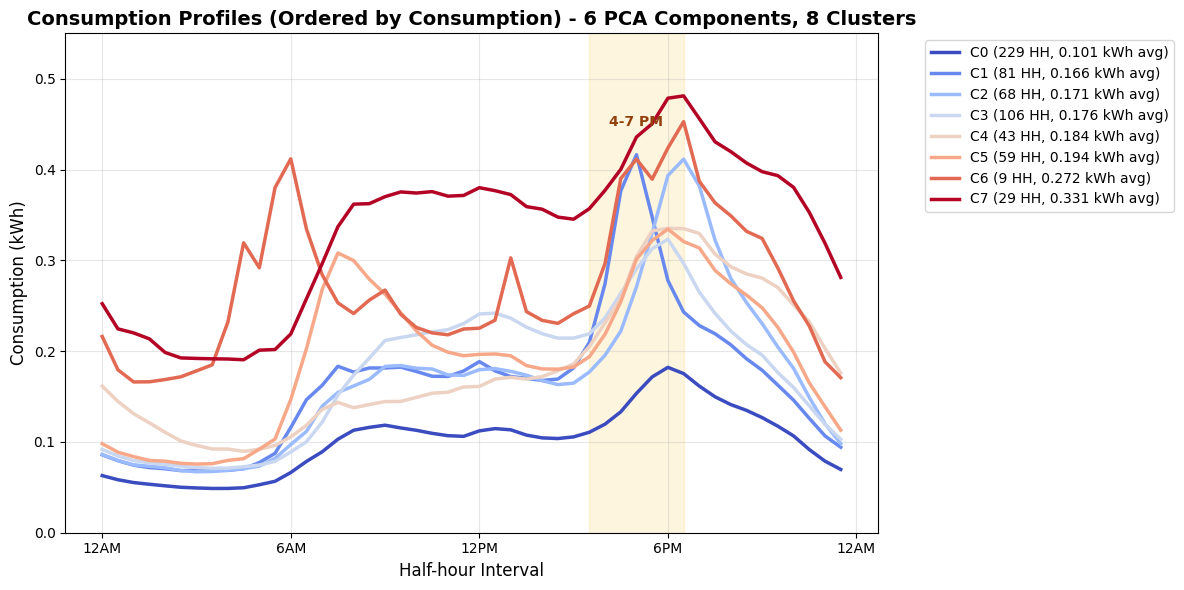

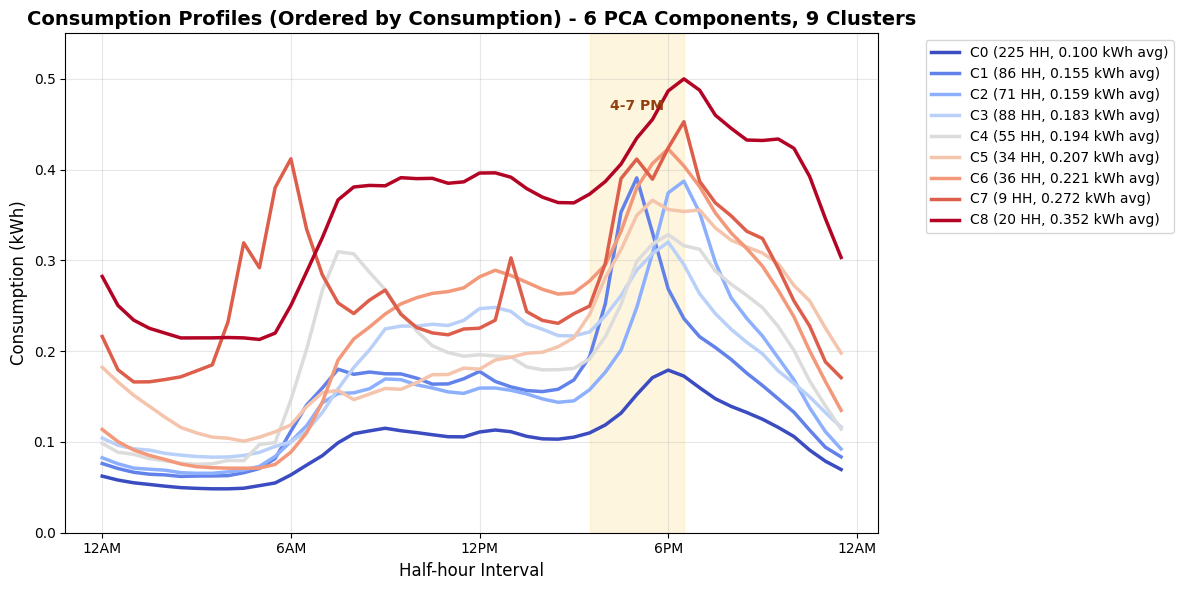

In [18]:
# Lets do the mapping


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.graph_objects as go
import os
os.environ["OMP_NUM_THREADS"] = "3"  # or set to 1, 2, depending on your CPU

manyclusters = 10

# ----------------------------------------------------------------------------
# 0) Prepare your data from df24_clean
# ----------------------------------------------------------------------------
df24_clean = df_pre_consumption_clean.copy()

# Create a results dataframe that will store all cluster labels
df_clustering_results = df24_clean[["ANON_ID"]].copy()  # Start with just ANON_ID

# Preserve ANON_ID as a column
anon_ids = df24_clean["ANON_ID"].values

# Prepare data for PCA and clustering
data_24 = df24_clean.drop(columns=["ANON_ID"])  # the 48 HH columns
data_24_values = data_24.values.astype(np.float64)

# Scale the data
scaler_raw = StandardScaler()
data_24_scaled = scaler_raw.fit_transform(data_24_values)

# ----------------------------------------------------------------------------
# Helper Functions for Consumption-Based Ordering
# ----------------------------------------------------------------------------

def rename_clusters_by_consumption(labels, data_values):
    """
    Rename clusters based on their mean consumption (ascending order)

    Parameters:
    - labels: cluster assignments for each household
    - data_values: consumption data (households x 48 half-hours)

    Returns:
    - renamed_labels: labels with clusters renamed 0, 1, 2... by increasing mean consumption
    - cluster_means: mean consumption for each renamed cluster
    - mapping_dict: dictionary mapping original cluster IDs to new IDs
    """
    unique_clusters = np.unique(labels)
    cluster_means = []

    # Calculate mean consumption for each cluster
    for cluster in unique_clusters:
        cluster_mask = labels == cluster
        cluster_data = data_values[cluster_mask]
        mean_consumption = np.mean(cluster_data)
        cluster_means.append((cluster, mean_consumption))

    # Sort by mean consumption
    cluster_means.sort(key=lambda x: x[1])

    # Create mapping from old cluster ID to new cluster ID
    cluster_mapping = {}
    sorted_means = []
    for new_id, (old_id, mean_val) in enumerate(cluster_means):
        cluster_mapping[old_id] = new_id
        sorted_means.append(mean_val)

    # Apply mapping to labels
    renamed_labels = np.array([cluster_mapping[label] for label in labels])

    return renamed_labels, sorted_means, cluster_mapping

def apply_consumption_ordering_to_all_columns(df_clustering_results, data_24_values):
    """
    Apply consumption-based ordering to all clustering columns in the dataframe

    Parameters:
    - df_clustering_results: dataframe with clustering results
    - data_24_values: original consumption data

    Returns:
    - df_ordered: dataframe with consumption-ordered cluster labels
    - all_mappings: dictionary of mappings for each clustering configuration
    """
    df_ordered = df_clustering_results.copy()
    all_mappings = {}

    # Get all cluster columns
    cluster_columns = [col for col in df_clustering_results.columns if col.startswith('Cluster_Comp')]

    print(f"Applying consumption-based ordering to {len(cluster_columns)} clustering columns...")

    for col in cluster_columns:
        print(f"  Processing {col}...")

        # Get original labels
        original_labels = df_clustering_results[col].values

        # Apply consumption-based renaming
        renamed_labels, cluster_means, mapping_dict = rename_clusters_by_consumption(
            original_labels, data_24_values
        )

        # Update the dataframe with renamed labels
        df_ordered[col] = renamed_labels

        # Store the mapping for reference
        all_mappings[col] = {
            'mapping': mapping_dict,
            'means': cluster_means,
            'n_clusters': len(np.unique(original_labels))
        }

        print(f"    Original → New mapping: {mapping_dict}")
        print(f"    Cluster means (ascending): {[f'{m:.3f}' for m in cluster_means]}")

    return df_ordered, all_mappings

# ----------------------------------------------------------------------------
# 1) Range of PCA components and cluster counts
# ----------------------------------------------------------------------------
n_components_list = [4, 6]
clusters_range = range(2, manyclusters)

results = []

for n_comp in n_components_list:
    print(f"Processing PCA with {n_comp} components...")

    pca = PCA(n_components=n_comp, random_state=42)
    pca_scores = pca.fit_transform(data_24_scaled)

    scaler_pca = StandardScaler()
    pca_scores_scaled = scaler_pca.fit_transform(pca_scores)

    for k in clusters_range:
        print(f"  - Clustering with {k} clusters...")

        kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
        labels = kmeans.fit_predict(pca_scores_scaled)

        sil_score = silhouette_score(pca_scores_scaled, labels)

        cluster_centers_pca = scaler_pca.inverse_transform(kmeans.cluster_centers_)
        cluster_centers_scaled = pca.inverse_transform(cluster_centers_pca)
        cluster_centers_original = scaler_raw.inverse_transform(cluster_centers_scaled)

        avg_meas = average_clustermeasure_to_centroid(
            data_original=data_24_values,
            labels=labels,
            n_clusters=k,
            cluster_centroids=cluster_centers_original,
            alpha=0.8
        )

        # Store ORIGINAL cluster labels first (will be reordered later)
        column_name = f"Cluster_Comp{n_comp:02d}_k{k:02d}"
        df_clustering_results[column_name] = labels

        results.append({
            "n_components": n_comp,
            "n_clusters": k,
            "silhouette": sil_score,
            "avg_clustermeasure": avg_meas,
            "column_name": column_name
        })

print(f"\nCompleted clustering! Added {len(results)} clustering columns to the dataframe.")
print(f"DataFrame shape: {df_clustering_results.shape}")

# ----------------------------------------------------------------------------
# 2) Apply Consumption-Based Ordering to All Columns
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("APPLYING CONSUMPTION-BASED ORDERING TO ALL CLUSTERING COLUMNS")
print("="*80)

df_clustering_results_ordered, cluster_mappings = apply_consumption_ordering_to_all_columns(
    df_clustering_results, data_24_values
)

print(f"\n✓ Consumption-based ordering applied to all clustering columns!")
print(f"✓ All clusters now ordered: C0 (lowest consumption) → C(max) (highest consumption)")

# ----------------------------------------------------------------------------
# 3) Create Consumption Profile Plots with Ordered Clusters
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("CREATING CONSUMPTION PROFILE PLOTS WITH ORDERED CLUSTERS")
print("="*80)

for n_comp in n_components_list:
    for k in clusters_range:
        column_name = f"Cluster_Comp{n_comp:02d}_k{k:02d}"

        # Get ordered labels
        ordered_labels = df_clustering_results_ordered[column_name].values

        # Plot consumption profiles
        plt.figure(figsize=(12, 6))

        # Get cluster counts
        unique_clusters, cluster_counts = np.unique(ordered_labels, return_counts=True)

        # Create color map that goes from blue (low consumption) to red (high consumption)
        colors = plt.cm.coolwarm(np.linspace(0, 1, len(unique_clusters)))

        # Plot each cluster profile (now in consumption order)
        for i, cluster_id in enumerate(unique_clusters):
            cluster_mask = ordered_labels == cluster_id
            cluster_data = data_24_values[cluster_mask]
            mean_profile = np.mean(cluster_data, axis=0)
            count = cluster_counts[i]

            # Get mean consumption for label
            cluster_mean = cluster_mappings[column_name]['means'][cluster_id]

            plt.plot(range(1, 49), mean_profile,
                    linewidth=2.5,
                    color=colors[i],
                    label=f'C{cluster_id} ({count} HH, {cluster_mean:.3f} kWh avg)')

        # Highlight 4-7pm period
        plt.axvspan(32, 38, alpha=0.15, color='#fbbf24', zorder=0)
        plt.text(35, plt.ylim()[1] * 0.9, '4-7 PM', ha='center', va='center',
                 fontsize=10, fontweight='bold', color='#92400e')

        plt.title(f'Consumption Profiles (Ordered by Consumption) - {n_comp} PCA Components, {k} Clusters',
                  fontsize=14, fontweight='bold')
        plt.xlabel('Half-hour Interval', fontsize=12)
        plt.ylabel('Consumption (kWh)', fontsize=12)
        plt.grid(True, alpha=0.3)

        # Time labels
        time_positions = [1, 13, 25, 37, 49]
        time_labels = ['12AM', '6AM', '12PM', '6PM', '12AM']
        plt.xticks(time_positions, time_labels)

        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.ylim(0, 0.55)
        plt.show()


## 5.1 Output for Comp = 6 and k = 7 plots with every profile assigned

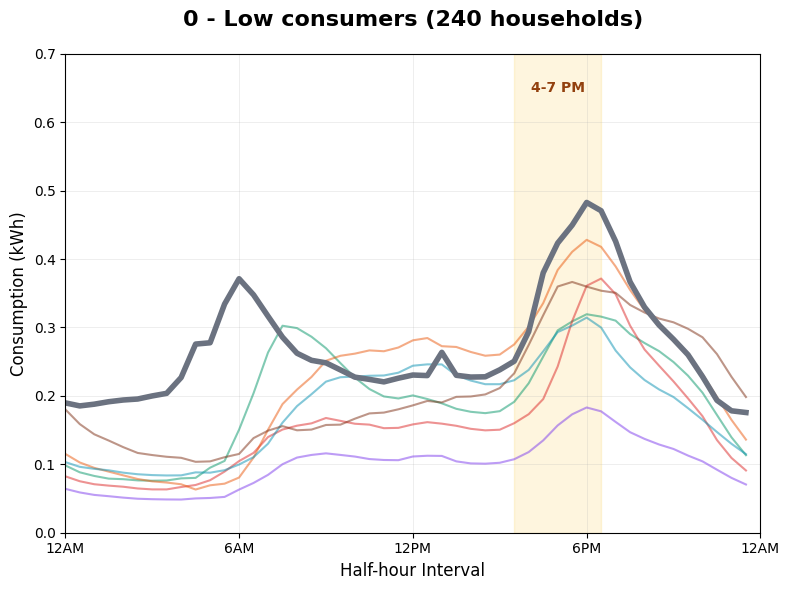

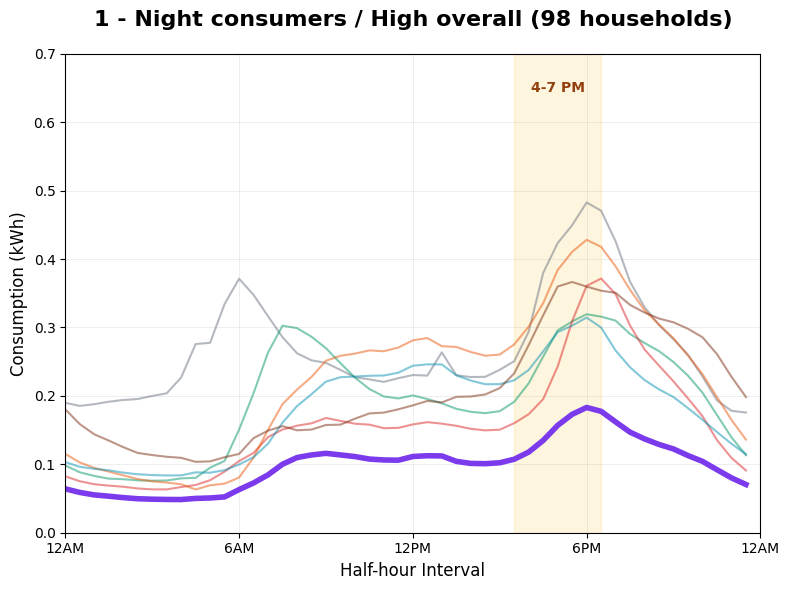

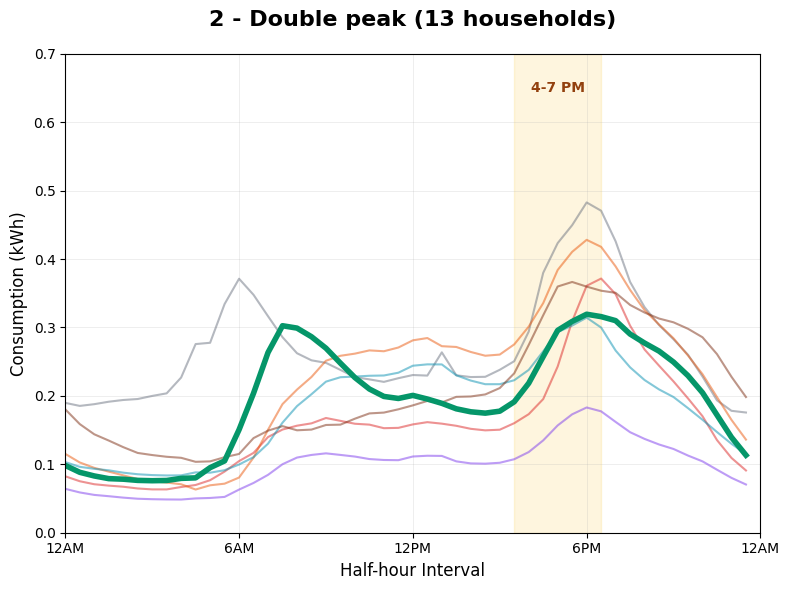

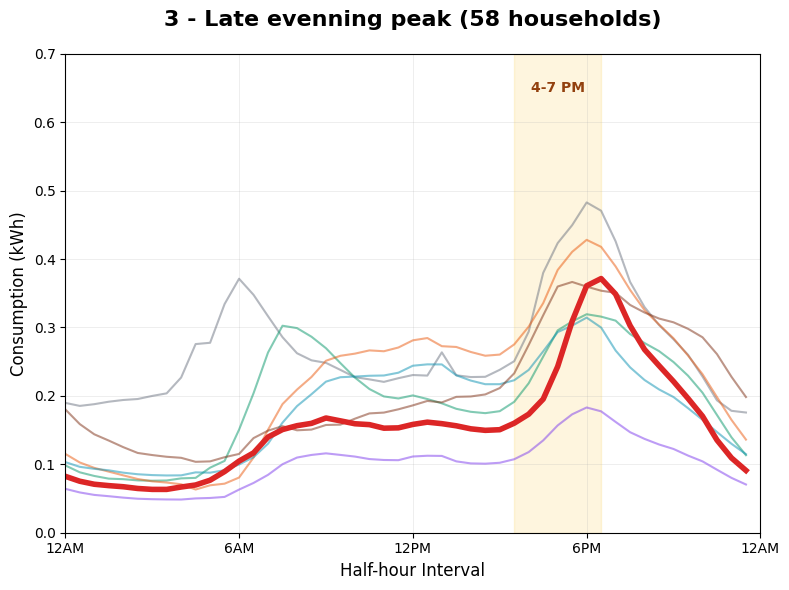

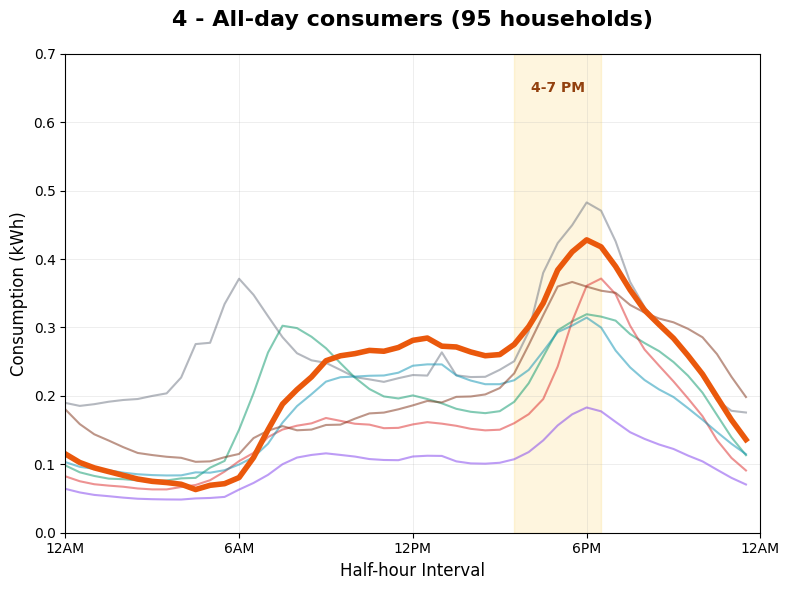

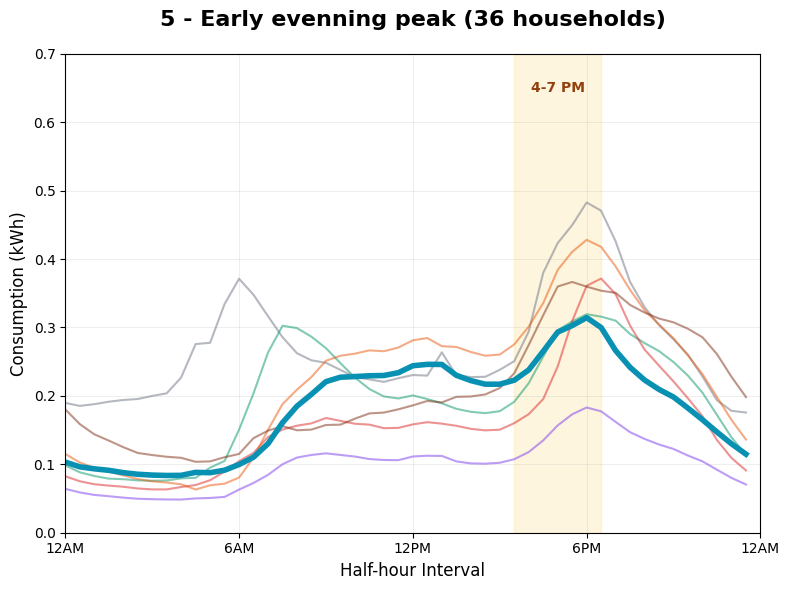

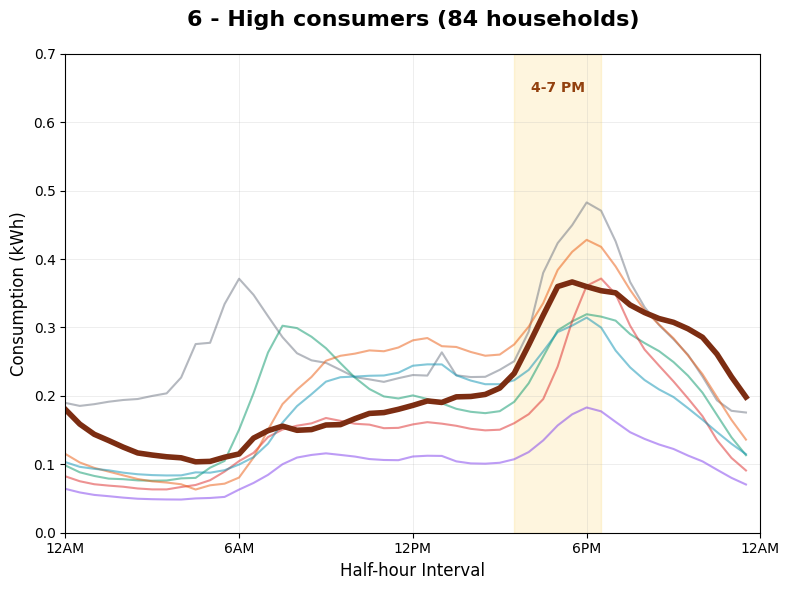

Saved: cluster_plots/all_clusters_overview.png


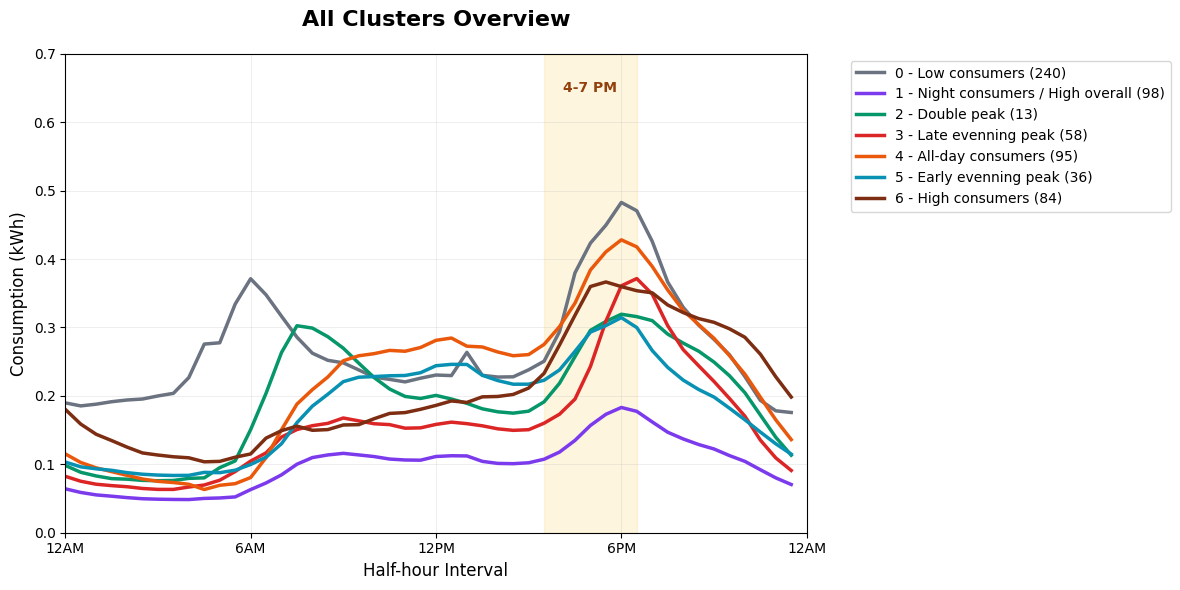


All plots saved to 'cluster_plots' folder!


In [24]:
# ----------------------------------------------------------------------------
# Simple Spotlight Cluster Visualization
# ----------------------------------------------------------------------------

import os

# Create folder for saving plots
output_folder = "cluster_plots"
os.makedirs(output_folder, exist_ok=True)

# Define custom nicknames for each cluster
cluster_nicknames = {
    0: "0 - Low consumers",
    1: "1 - Night consumers / High overall",
    2: "2 - Double peak",
    3: "3 - Late evenning peak",
    4: "4 - All-day consumers",
    5: "5 - Early evenning peak",
    6: "6 - High consumers"
}

# Muted color palette
colors = ['#6b7280', '#7c3aed', '#059669', '#dc2626', '#ea580c', '#0891b2', '#7c2d12']

# Create individual spotlight plots
for spotlight_cluster in range(n_clusters):
    plt.figure(figsize=(8, 6))

    # Plot all clusters in background (faded but keep original colors)
    for cluster in range(n_clusters):
        if cluster != spotlight_cluster:
            plt.plot(range(1, 49), cluster_centers_original[cluster],
                    color=colors[cluster % len(colors)],
                    linewidth=1.5,
                    alpha=0.5)

    # Plot the spotlight cluster (bold)
    plt.plot(range(1, 49), cluster_centers_original[spotlight_cluster],
            color=colors[spotlight_cluster % len(colors)],
            linewidth=4,
            alpha=1.0)

    # Highlight 4-7pm period (half-hours 32-38: 4:00pm to 7:00pm)
    plt.axvspan(32, 38, alpha=0.15, color='#fbbf24', zorder=0)
    plt.text(35, 0.65, '4-7 PM', ha='center', va='center',
             fontsize=10, fontweight='bold', color='#92400e')

    # Get cluster statistics
    cluster_count = cluster_counts_df[cluster_counts_df["Cluster"] == spotlight_cluster]["Household Count"].iloc[0]

    # Simple title
    nickname = cluster_nicknames.get(spotlight_cluster, f"Cluster {spotlight_cluster}")
    plt.title(f'{nickname} ({cluster_count} households)',
              fontsize=16, fontweight='bold', pad=20)

    plt.xlabel("Half-hour Interval", fontsize=12)
    plt.ylabel("Consumption (kWh)", fontsize=12)

    # Simple grid
    plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

    # Set limits
    plt.ylim(0, 0.7)
    plt.xlim(1, 48)

    # Time labels for reference
    time_positions = [1, 13, 25, 37, 49]
    time_labels = ['12AM', '6AM', '12PM', '6PM', '12AM']
    plt.xticks(time_positions, time_labels)

    plt.tight_layout()
    '''
    # Save individual plot
    filename = f"{output_folder}/cluster_{spotlight_cluster}_{nickname.replace(' ', '_').lower()}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"Saved: {filename}")
    '''
    plt.show()

# ----------------------------------------------------------------------------
# Overview Plot - All Clusters Together
# ----------------------------------------------------------------------------

plt.figure(figsize=(12, 6))

# Plot all clusters with their individual colors and normal linewidth
for cluster in range(n_clusters):
    nickname = cluster_nicknames.get(cluster, f"Cluster {cluster}")
    cluster_count = cluster_counts_df[cluster_counts_df["Cluster"] == cluster]["Household Count"].iloc[0]

    plt.plot(range(1, 49), cluster_centers_original[cluster],
            color=colors[cluster % len(colors)],
            linewidth=2.5,
            alpha=1.0,
            label=f'{nickname} ({cluster_count})')

# Highlight 4-7pm period
plt.axvspan(32, 38, alpha=0.15, color='#fbbf24', zorder=0)
plt.text(35, 0.65, '4-7 PM', ha='center', va='center',
         fontsize=10, fontweight='bold', color='#92400e')

plt.title('All Clusters Overview', fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Half-hour Interval", fontsize=12)
plt.ylabel("Consumption (kWh)", fontsize=12)

# Grid and limits
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
plt.ylim(0, 0.7)
plt.xlim(1, 48)

# Time labels
time_positions = [1, 13, 25, 37, 49]
time_labels = ['12AM', '6AM', '12PM', '6PM', '12AM']
plt.xticks(time_positions, time_labels)

# Legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)

plt.tight_layout()

# Save overview plot
overview_filename = f"{output_folder}/all_clusters_overview.png"
plt.savefig(overview_filename, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved: {overview_filename}")

plt.show()

print(f"\nAll plots saved to '{output_folder}' folder!")

# 6. Output a .csv with ANON_ID Clusters... and Socio_df

In [20]:
print(f"Shape of df_clustering_results {(df_clustering_results_ordered.shape)}")
print(f"Shape of socio_df {(socio_df.shape)}")

complemented_socio_df = pd.merge(
    socio_df,
    df_clustering_results_ordered,
    on='ANON_ID',
    how='left'
)
print(f"Shape of complemented_socio_df {(complemented_socio_df.shape)}")


complemented_socio_df_masked = complemented_socio_df.dropna(subset=['Cluster_Comp04_k02']) # Only keep rows with a valid cluster
print(f"Shape of complemented_socio_df after masking {(complemented_socio_df_masked.shape)}")
print(f"Columns in complemented socio df {(complemented_socio_df_masked.columns)}")



# Output CSV
# complemented_socio_df_masked.to_csv("comp_socio_df.csv", index=False)
# print("Saved clustering results with socio df to 'comp_socio_df.csv'")

# ------------- Before output the .csv lets add a column called Treatment
# ------------- with 1 - Intervention and 0 Control

# Add Treatment column to socio_df
print("="*60)
print("ADDING TREATMENT COLUMN TO complemented_socio_df_masked")
print("="*60)

# Create a copy to avoid modifying the original (optional)
comp_socio_df = complemented_socio_df_masked.copy()

# Get unique ANON_IDs from intervention and control datasets
intervention_ids = set(df_interventionpre['ANON_ID'].unique())
control_ids = set(df_controlpre['ANON_ID'].unique())

print(f"ANON_IDs in df_interventionpre: {len(intervention_ids):,}")
print(f"ANON_IDs in df_controlpre: {len(control_ids):,}")
print(f"ANON_IDs in socio_df: {len(comp_socio_df):,}")

# Check for overlap between intervention and control (should be 0)
overlap = intervention_ids.intersection(control_ids)
if overlap:
    print(f"⚠️  WARNING: {len(overlap)} ANON_IDs appear in BOTH intervention and control!")
    print(f"Overlapping IDs: {list(overlap)[:10]}...")  # Show first 10
else:
    print("✓ No overlap between intervention and control groups")

# Create Treatment column
def assign_treatment(anon_id):
    if anon_id in intervention_ids:
        return 1
    elif anon_id in control_ids:
        return 0
    else:
        return None  # Not in either dataset

comp_socio_df['Treatment'] = comp_socio_df['ANON_ID'].apply(assign_treatment)

# Analysis of the Treatment assignment
print(f"\n" + "="*60)
print("TREATMENT ASSIGNMENT RESULTS")
print("="*60)

treatment_counts = comp_socio_df['Treatment'].value_counts(dropna=False)
print("Treatment distribution:")
print(f"  Treatment = 1 (Intervention): {treatment_counts.get(1, 0):,}")
print(f"  Treatment = 0 (Control): {treatment_counts.get(0, 0):,}")
print(f"  Treatment = NaN (Not assigned): {comp_socio_df['Treatment'].isna().sum():,}")

# Show percentages
total_assigned = treatment_counts.get(1, 0) + treatment_counts.get(0, 0)
if total_assigned > 0:
    intervention_pct = (treatment_counts.get(1, 0) / total_assigned) * 100
    control_pct = (treatment_counts.get(0, 0) / total_assigned) * 100
    print(f"\nOf assigned households:")
    print(f"  Intervention: {intervention_pct:.1f}%")
    print(f"  Control: {control_pct:.1f}%")

# Check which ANON_IDs from socio_df are not in either intervention or control
unassigned_ids = comp_socio_df[comp_socio_df['Treatment'].isna()]['ANON_ID'].tolist()
if unassigned_ids:
    print(f"\nANON_IDs in socio_df but not in intervention/control datasets:")
    print(f"Count: {len(unassigned_ids)}")
    print(f"First 10: {unassigned_ids[:10]}")

# Check which ANON_IDs from intervention/control are not in socio_df
intervention_not_in_socio = intervention_ids - set(comp_socio_df['ANON_ID'])
control_not_in_socio = control_ids - set(comp_socio_df['ANON_ID'])

if intervention_not_in_socio:
    print(f"\nIntervention ANON_IDs not in socio_df: {len(intervention_not_in_socio)}")
    print(f"Examples: {list(intervention_not_in_socio)[:5]}")

if control_not_in_socio:
    print(f"Control ANON_IDs not in socio_df: {len(control_not_in_socio)}")
    print(f"Examples: {list(control_not_in_socio)[:5]}")

# Show sample of the updated dataframe
print(f"\n" + "="*60)
print("SAMPLE OF UPDATED DATAFRAME")
print("="*60)
print("Columns:", comp_socio_df.columns.tolist())
print("\nFirst few rows:")
print(comp_socio_df[['ANON_ID', 'Treatment']].head(10))

print("\nSample by treatment group:")
if treatment_counts.get(1, 0) > 0:
    print("Intervention group sample:")
    print(comp_socio_df[comp_socio_df['Treatment'] == 1][['ANON_ID', 'Treatment']].head(3))

if treatment_counts.get(0, 0) > 0:
    print("Control group sample:")
    print(comp_socio_df[comp_socio_df['Treatment'] == 0][['ANON_ID', 'Treatment']].head(3))

print(f"\n✓ Treatment column successfully added to comp_socio_df!")
print(f"Final dataframe shape: {comp_socio_df.shape}")


comp_socio_df.rename(columns={'Treatment': 'Group'}, inplace=True)
comp_socio_df.head()
comp_socio_df.to_csv("comp_socio_df.csv", index=False)
print("Saved clustering results with socio df to 'comp_socio_df.csv'")


Shape of df_clustering_results (624, 17)
Shape of socio_df (1044, 15)
Shape of complemented_socio_df (1044, 31)
Shape of complemented_socio_df after masking (624, 31)
Columns in complemented socio df Index(['ANON_ID', 'AGE_GROUP', 'INCOME_CATEGORY', 'HOUSEHOLD_OCCUPANCY',
       'CHILDREN_AT_HOME', 'HOUSEHOLD_SIZE', 'NUMBER_OF_BEDROOMS',
       'OCCUPATION', 'EMPLOYMENT_STATUS', 'HIGHEST_QUALIFICATION',
       'HOME_OWNERSHIP', 'HOME_TYPE', 'HOME_VALUE', 'SOCIAL_GRADE',
       'TARIFF_GROUP', 'Cluster_Comp04_k02', 'Cluster_Comp04_k03',
       'Cluster_Comp04_k04', 'Cluster_Comp04_k05', 'Cluster_Comp04_k06',
       'Cluster_Comp04_k07', 'Cluster_Comp04_k08', 'Cluster_Comp04_k09',
       'Cluster_Comp06_k02', 'Cluster_Comp06_k03', 'Cluster_Comp06_k04',
       'Cluster_Comp06_k05', 'Cluster_Comp06_k06', 'Cluster_Comp06_k07',
       'Cluster_Comp06_k08', 'Cluster_Comp06_k09'],
      dtype='object')
ADDING TREATMENT COLUMN TO complemented_socio_df_masked
ANON_IDs in df_interventionpre: 387


In [21]:
comp_socio_df.shape



(624, 32)

In [22]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import os
import re


df_peak_merged = df_peak_merged_relative

common_ids_03  = set(socio_df['ANON_ID']).intersection(df_peak_merged_relative['ANON_ID'])
df_clustering_results_ordered = socio_df[socio_df['ANON_ID'].isin(common_ids_03)].reset_index(drop=True)



# Display and saving settings
SHOW_PLOTS = True
SAVE_PLOTS = False
output_dir = 'relative_cluster_treatment_effect_plots'
os.makedirs(output_dir, exist_ok=True)

def show_or_save_plot(filename=None):
    """Helper function to handle plot display and saving based on settings"""
    if SAVE_PLOTS and filename:
        plt.savefig(os.path.join(output_dir, filename), dpi=400, bbox_inches='tight')
        print(f"✓ Saved: {filename}")

    if SHOW_PLOTS:
        plt.show()
    else:
        plt.close()

print("="*80)
print("RELATIVE TREATMENT EFFECTS BY CLUSTERING CONFIGURATION")
print("="*80)

# Get all cluster columns from socio_df (using the consumption-ordered clusters)
cluster_columns = [col for col in df_clustering_results_ordered.columns if col.startswith('Cluster_Comp')]
print(f"Found {len(cluster_columns)} clustering methodologies:")
for col in cluster_columns:
    print(f"  - {col}")

# Extract unique clustering configurations
cluster_configs = []
for col in cluster_columns:
    parts = col.split('_')
    comp = int(parts[1][4:])  # Extract number after 'Comp'
    k = int(parts[2][1:])     # Extract number after 'k'
    cluster_configs.append({
        'column': col,
        'components': comp,
        'k_clusters': k,
        'config_name': f"{comp}C_{k}K"
    })

cluster_configs = sorted(cluster_configs, key=lambda x: (x['components'], x['k_clusters']))
print(f"\nProcessing {len(cluster_configs)} cluster configurations...")

# ---------------------------
# Prepare Base Dataset with Monthly Baselines
# ---------------------------
print(f"\n" + "="*60)
print("PREPARING BASE DATASET WITH MONTHLY BASELINES")
print("="*60)

# Make sure required columns are properly typed
df_peak_merged['ANON_ID'] = df_peak_merged['ANON_ID'].astype(str)
df_peak_merged['Month'] = df_peak_merged['Month'].astype(str)
df_peak_merged['Treatment'] = df_peak_merged['Treatment'].astype(int)
df_peak_merged['Post'] = df_peak_merged['Post'].astype(int)

print(f"Original dataset shape: {df_peak_merged.shape}")

# Calculate monthly baselines
baseline_consumption_monthly = (df_peak_merged[df_peak_merged['Post'] == 0]
                               .groupby(['ANON_ID', 'Month'])['peak_kwh']
                               .mean()
                               .reset_index()
                               .rename(columns={'peak_kwh': 'baseline_peak_kwh'}))

print(f"Monthly baselines calculated: {len(baseline_consumption_monthly):,} (ANON_ID × Month combinations)")
print(f"Unique households with monthly baselines: {baseline_consumption_monthly['ANON_ID'].nunique():,}")

# Merge monthly baselines
df_peak_merged_baseline = pd.merge(df_peak_merged, baseline_consumption_monthly,
                                  on=['ANON_ID', 'Month'], how='left')

# Check missing baselines
missing_baselines = df_peak_merged_baseline['baseline_peak_kwh'].isna().sum()
print(f"Observations with missing monthly baselines: {missing_baselines:,}")

if missing_baselines > 0:
    print("Missing baselines by month:")
    missing_by_month = (df_peak_merged_baseline[df_peak_merged_baseline['baseline_peak_kwh'].isna()]
                       ['Month'].value_counts().sort_index())
    for month, count in missing_by_month.items():
        print(f"  Month {month}: {count:,} missing")


# Apply minimum baseline threshold
min_baseline_threshold = 0.01
print(f"\nApplying minimum baseline threshold: {min_baseline_threshold} kWh")

before_threshold = len(df_peak_merged_baseline)
households_before = df_peak_merged_baseline['ANON_ID'].nunique()

# Apply threshold
df_analysis_base = df_peak_merged_baseline[
    (df_peak_merged_baseline['baseline_peak_kwh'] > min_baseline_threshold) &
    (df_peak_merged_baseline['baseline_peak_kwh'].notna())
].copy()

after_threshold = len(df_analysis_base)
households_after = df_analysis_base['ANON_ID'].nunique()

print(f"Dataset impact of baseline threshold:")
print(f"  Observations before: {before_threshold:,}")
print(f"  Observations after: {after_threshold:,}")
print(f"  Observations dropped: {before_threshold - after_threshold:,} ({(before_threshold - after_threshold)/before_threshold*100:.1f}%)")
print(f"  Households before: {households_before:,}")
print(f"  Households after: {households_after:,}")
print(f"  Households dropped: {households_before - households_after:,} ({(households_before - households_after)/households_before*100:.1f}%)")

# Calculate relative changes
df_analysis_base['peak_kwh_relative'] = ((df_analysis_base['peak_kwh'] - df_analysis_base['baseline_peak_kwh']) /
                                        df_analysis_base['baseline_peak_kwh']) * 100

print(f"\nFinal base dataset shape: {df_analysis_base.shape}")
print(f"Relative consumption statistics:")
print(df_analysis_base['peak_kwh_relative'].describe())

# ---------------------------
# Create Monthly Treatment Effect Plots for Each Configuration
# ---------------------------
print(f"\n" + "="*60)
print("CREATING MONTHLY TREATMENT EFFECT PLOTS BY CONFIGURATION")
print("="*60)

# Formula for relative DiD
formula_relative = (
    "peak_kwh_relative ~ C(Month) + Treatment + Post + Temp_4to7_avg "
    "+ Post:C(Month) + Treatment:Post:C(Month)"
)

# Process each clustering configuration - THIS IS THE MISSING LOOP!
for config in cluster_configs:
    cluster_col = config['column']
    config_name = config['config_name']

    print(f"\n{'='*50}")
    print(f"Processing Monthly Effects: {config_name} ({cluster_col})")
    print(f"{'='*50}")

    # Merge cluster information with analysis dataset
    df_analysis = pd.merge(
        df_analysis_base,
        df_clustering_results_ordered[['ANON_ID', cluster_col]],
        on='ANON_ID',
        how='inner'
    )

    # Rename cluster column for consistency
    df_analysis = df_analysis.rename(columns={cluster_col: 'Cluster'})
    df_analysis['Cluster'] = df_analysis['Cluster'].astype(str)

    print(f"Analysis dataset shape: {df_analysis.shape}")
    print(f"Households in analysis: {df_analysis['ANON_ID'].nunique():,}")

    # Get unique clusters
    cluster_categories = sorted(df_analysis['Cluster'].unique())
    print(f"Clusters: {', '.join(cluster_categories)} (n={len(cluster_categories)})")

    # Store results for each cluster in this configuration
    config_cluster_results = {}

    # Run separate regressions for each cluster
    for cluster in cluster_categories:
        cluster_data = df_analysis[df_analysis['Cluster'] == cluster].copy()

        if len(cluster_data) < 50:  # Skip if sample size too small
            print(f"  Cluster {cluster}: Small sample ({len(cluster_data)}). Skipping.")
            continue

        try:
            cluster_model = smf.ols(formula=formula_relative, data=cluster_data).fit(
                cov_type='cluster', cov_kwds={'groups': cluster_data['ANON_ID']}
            )

            # Extract cluster-specific treatment effects
            cluster_effects = cluster_model.params[cluster_model.params.index.str.contains('Treatment:Post:C\(Month\)')]
            cluster_effects_se = cluster_model.bse[cluster_model.params.index.str.contains('Treatment:Post:C\(Month\)')]

            # Extract months from parameter names
            months = []
            for param_name in cluster_effects.index:
                match = re.search(r'C\(Month\)\[T\.([^\]]+)\]', param_name)
                if match:
                    months.append(int(match.group(1)))
                else:
                    match = re.search(r'C\(Month\)\[([^\]]+)\]', param_name)
                    if match:
                        months.append(int(match.group(1)))
                    else:
                        match = re.search(r'(\d+)', param_name)
                        if match:
                            months.append(int(match.group(1)))

            # Store results
            config_cluster_results[cluster] = {
                'months': months,
                'effects': cluster_effects.values,
                'se': cluster_effects_se.values,
                'n_obs': len(cluster_data),
                'n_households': cluster_data['ANON_ID'].nunique(),
                'r_squared': cluster_model.rsquared
            }

            print(f"  Cluster {cluster}: {len(cluster_data):,} obs, {cluster_data['ANON_ID'].nunique():,} households, {len(months)} months")

        except Exception as e:
            print(f"  Cluster {cluster}: Error - {e}")

    # Skip if no successful cluster analyses
    if not config_cluster_results:
        print(f"  ❌ No successful cluster analyses for {config_name}. Skipping plots.")
        continue

    # Store results for this configuration (for summary later)
    all_config_results[config_name] = {
        'config': config,
        'cluster_results': config_cluster_results
    }

    # Create individual heatmap for this configuration
    heatmap_data = []
    for cluster, results in config_cluster_results.items():
        for month, effect in zip(results['months'], results['effects']):
            heatmap_data.append({
                'Cluster': f"C{cluster}",
                'Month': month,
                'Effect': effect
            })

    if heatmap_data:
        heatmap_df = pd.DataFrame(heatmap_data)
        heatmap_pivot = heatmap_df.pivot(index='Cluster', columns='Month', values='Effect')

        # Create individual heatmap
        plt.figure(figsize=(12, 6))
        sns.heatmap(heatmap_pivot, cmap='RdBu_r', center=0, annot=True, fmt='.2f',
                   vmin=-15, vmax=6, cbar_kws={'label': 'Treatment Effect (%)'})
        plt.title(f'Relative Treatment Effects Heatmap: {config_name}\n'
                 f'({config["components"]} PCA Components, {config["k_clusters"]} Clusters)')
        plt.xlabel('Month')
        plt.ylabel('Cluster (Ordered by Consumption)')
        plt.tight_layout()

        filename = f'relative_heatmap_{config_name.lower()}.jpg'
        show_or_save_plot(filename)

    # ---------------------------
    # Create Monthly Treatment Effect Plots with Confidence Intervals
    # ---------------------------
    # Prepare data for time series plots
    timeseries_data = []

    for cluster, results in config_cluster_results.items():
        for i, month in enumerate(results['months']):
            effect = results['effects'][i]
            se = results['se'][i]
            ci_95_lower = effect - 1.96 * se
            ci_95_upper = effect + 1.96 * se
            ci_80_lower = effect - 1.28 * se
            ci_80_upper = effect + 1.28 * se

            timeseries_data.append({
                'Cluster': f"C{cluster}",
                'Month': month,
                'Effect': effect,
                'SE': se,
                'CI_95_lower': ci_95_lower,
                'CI_95_upper': ci_95_upper,
                'CI_80_lower': ci_80_lower,
                'CI_80_upper': ci_80_upper,
                'n_obs': results['n_obs'],
                'n_households': results['n_households']
            })

    if timeseries_data:
        timeseries_df = pd.DataFrame(timeseries_data)

        # Get unique clusters for this configuration
        unique_clusters = sorted(timeseries_df['Cluster'].unique())
        n_clusters = len(unique_clusters)

        # Create facet grid plot
        fig, axes = plt.subplots(nrows=n_clusters, figsize=(12, 2.5 + 2*n_clusters), sharex=True)

        # Handle the case of only one cluster
        if n_clusters == 1:
            axes = [axes]

        # Color palette for clusters (consumption-ordered: blue to red)
        cluster_colors = plt.cm.coolwarm(np.linspace(0, 1, n_clusters))

        for i, cluster in enumerate(unique_clusters):
            ax = axes[i]
            cluster_data = timeseries_df[timeseries_df['Cluster'] == cluster].sort_values('Month')

            # Use color from palette
            color = cluster_colors[i]

            # Plot main effect line
            ax.plot(cluster_data['Month'], cluster_data['Effect'],
                   marker='o', color=color, linewidth=2.5, markersize=6)

            # Add both confidence intervals
            ax.fill_between(cluster_data['Month'],
                           cluster_data['CI_95_lower'],
                           cluster_data['CI_95_upper'],
                           alpha=0.2, color=color, label='95% CI')
            ax.fill_between(cluster_data['Month'],
                           cluster_data['CI_80_lower'],
                           cluster_data['CI_80_upper'],
                           alpha=0.4, color=color, label='80% CI')

            # Add reference line at zero
            ax.axhline(0, linestyle='--', color='gray', alpha=0.7)

            # Add sample size to title
            n_households = cluster_data['n_households'].iloc[0] if len(cluster_data) > 0 else 'N/A'
            n_obs = cluster_data['n_obs'].iloc[0] if len(cluster_data) > 0 else 'N/A'
            ax.set_title(f"{cluster} ({n_households} HH, {n_obs} obs)", fontweight='bold')

            ax.set_ylabel("Treatment Effect (%)", fontsize=10)
            ax.grid(True, alpha=0.3)
            ax.set_ylim(-15, 6)  # Adjusted for relative effects

            # Add legend only to first subplot
            if i == 0:
                ax.legend(loc='upper right', fontsize=9)

            # Improve tick formatting
            ax.tick_params(axis='both', which='major', labelsize=9)

        # Set x-label for bottom subplot
        axes[-1].set_xlabel("Month", fontsize=12)

        # Add overall title
        fig.suptitle(f'Relative Monthly Treatment Effects: {config_name}\n'
                    f'({config["components"]} PCA Components, {config["k_clusters"]} Clusters)',
                    fontsize=14, fontweight='bold', y=0.98)

        plt.tight_layout()
        plt.subplots_adjust(top=0.92)  # Make room for suptitle

        filename = f'relative_monthly_effects_{config_name.lower()}.jpg'
        show_or_save_plot(filename)

        # ---------------------------
        # Create Combined Plot (All Clusters Together)
        # ---------------------------
        plt.figure(figsize=(14, 8))

        for i, cluster in enumerate(unique_clusters):
            cluster_data = timeseries_df[timeseries_df['Cluster'] == cluster].sort_values('Month')
            color = cluster_colors[i]
            n_households = cluster_data['n_households'].iloc[0] if len(cluster_data) > 0 else 'N/A'

            # Plot main effect line
            plt.plot(cluster_data['Month'], cluster_data['Effect'],
                    marker='o', color=color, linewidth=2.5, markersize=6,
                    label=f'{cluster} ({n_households} HH)')

            # Add confidence intervals
            plt.fill_between(cluster_data['Month'],
                           cluster_data['CI_95_lower'],
                           cluster_data['CI_95_upper'],
                           alpha=0.15, color=color)
            plt.fill_between(cluster_data['Month'],
                           cluster_data['CI_80_lower'],
                           cluster_data['CI_80_upper'],
                           alpha=0.25, color=color)

        # Add reference line at zero
        plt.axhline(0, linestyle='--', color='gray', alpha=0.7, linewidth=1)

        plt.title(f'Relative Treatment Effects Comparison: {config_name}\n'
                 f'({config["components"]} PCA Components, {config["k_clusters"]} Clusters)',
                 fontsize=14, fontweight='bold', pad=20)
        plt.xlabel("Month", fontsize=12)
        plt.ylabel("Treatment Effect (% Change from Monthly Baseline)", fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.ylim(-15, 6)

        # Add legend
        plt.legend(title="Cluster (Consumption Order)", bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()

        filename = f'relative_combined_effects_{config_name.lower()}.jpg'
        show_or_save_plot(filename)

    print(f"  ✓ Created heatmap and line plots for {config_name}")
    print(f"    - Heatmap: Monthly effects overview")
    print(f"    - Facet plot: {n_clusters} individual cluster panels")
    print(f"    - Combined plot: All clusters overlaid")

# ---------------------------
# Analysis by Clustering Configuration (Summary)
# ---------------------------
print(f"\n" + "="*60)
print("CREATING SUMMARY ANALYSIS")
print("="*60)

# Store all results for summary
summary_results = []

for config_name, config_data in all_config_results.items():
    cluster_results = config_data['cluster_results']
    config_info = config_data['config']

    for cluster, results in cluster_results.items():
        # Calculate average treatment effect for summary
        avg_effect = np.mean(results['effects'])
        avg_se = np.sqrt(np.mean(np.array(results['se'])**2))  # RMS of standard errors

        summary_results.append({
            'Config': config_name,
            'Components': config_info['components'],
            'K_Clusters': config_info['k_clusters'],
            'Cluster': cluster,
            'Avg_Effect_Pct': avg_effect,
            'Avg_SE': avg_se,
            'N_Observations': results['n_obs'],
            'N_Households': results['n_households'],
            'R_Squared': results['r_squared']
        })

# ---------------------------
# Create Summary Analysis
# ---------------------------
print(f"\n" + "="*60)
print("SUMMARY ANALYSIS")
print("="*60)

summary_df = pd.DataFrame(summary_results)
print(f"Total analysis results: {len(summary_df)}")
print(f"Configurations analyzed: {summary_df['Config'].nunique()}")
print(f"Total cluster-level analyses: {len(summary_df)}")

if len(summary_df) > 0:
    print(f"\nOverall treatment effect statistics:")
    print(f"Mean effect across all clusters: {summary_df['Avg_Effect_Pct'].mean():.3f}%")
    print(f"Standard deviation: {summary_df['Avg_Effect_Pct'].std():.3f}%")
    print(f"Range: {summary_df['Avg_Effect_Pct'].min():.3f}% to {summary_df['Avg_Effect_Pct'].max():.3f}%")

    # Check for significant effects (rough approximation)
    summary_df['Significant'] = np.abs(summary_df['Avg_Effect_Pct']) > 1.96 * summary_df['Avg_SE']
    sig_count = summary_df['Significant'].sum()
    print(f"Approximately significant effects: {sig_count} out of {len(summary_df)} ({sig_count/len(summary_df)*100:.1f}%)")

# ---------------------------
# Create Visualizations
# ---------------------------
if len(summary_df) > 0:
    print(f"\n" + "="*60)
    print("CREATING VISUALIZATIONS")
    print("="*60)

    # Plot 1: Heatmap of average treatment effects by configuration
    plt.figure(figsize=(16, 10))

    # Create pivot table for heatmap
    heatmap_data = summary_df.pivot_table(
        index=['Components', 'K_Clusters'],
        columns='Cluster',
        values='Avg_Effect_Pct',
        aggfunc='mean'
    )

    # Create row labels combining components and k
    row_labels = [f"{comp}C-{k}K" for comp, k in heatmap_data.index]

    plt.subplot(2, 2, 1)
    sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
                cbar_kws={'label': 'Avg Treatment Effect (%)'})
    plt.title('Average Treatment Effects by Configuration and Cluster', fontweight='bold')
    plt.ylabel('Configuration (Components-Clusters)')
    plt.xlabel('Cluster (Ordered by Consumption)')

    # Plot 2: Distribution of treatment effects
    plt.subplot(2, 2, 2)
    plt.hist(summary_df['Avg_Effect_Pct'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(0, color='red', linestyle='--', alpha=0.7, label='No Effect')
    plt.xlabel('Average Treatment Effect (%)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Treatment Effects', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 3: Effects by number of components
    plt.subplot(2, 2, 3)
    comp_effects = summary_df.groupby('Components')['Avg_Effect_Pct'].agg(['mean', 'std']).reset_index()
    plt.errorbar(comp_effects['Components'], comp_effects['mean'],
                yerr=comp_effects['std'], fmt='o-', capsize=5, linewidth=2)
    plt.xlabel('Number of PCA Components')
    plt.ylabel('Average Treatment Effect (%)')
    plt.title('Treatment Effects by PCA Components', fontweight='bold')
    plt.grid(True, alpha=0.3)

    # Plot 4: Effects by number of clusters
    plt.subplot(2, 2, 4)
    k_effects = summary_df.groupby('K_Clusters')['Avg_Effect_Pct'].agg(['mean', 'std']).reset_index()
    plt.errorbar(k_effects['K_Clusters'], k_effects['mean'],
                yerr=k_effects['std'], fmt='o-', capsize=5, linewidth=2)
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Average Treatment Effect (%)')
    plt.title('Treatment Effects by Number of Clusters', fontweight='bold')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    show_or_save_plot('01_relative_treatment_effects_summary.jpg')

    # Plot 5: Detailed comparison by configuration
    if len(summary_df['Config'].unique()) > 1:
        plt.figure(figsize=(15, 8))

        configs = sorted(summary_df['Config'].unique())
        colors = plt.cm.viridis(np.linspace(0, 1, len(configs)))

        for i, config in enumerate(configs):
            config_data = summary_df[summary_df['Config'] == config]
            plt.scatter(config_data['Cluster'].astype(float).astype(int), config_data['Avg_Effect_Pct'],
                       s=100, alpha=0.7, color=colors[i], label=config)

        plt.axhline(0, color='red', linestyle='--', alpha=0.7)
        plt.xlabel('Cluster (Ordered by Consumption)')
        plt.ylabel('Average Treatment Effect (%)')
        plt.title('Treatment Effects by Cluster Across All Configurations', fontweight='bold')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        show_or_save_plot('02_effects_by_cluster_all_configs.jpg')

# ---------------------------
# Save Results
# ---------------------------
if len(summary_df) > 0:
    summary_df.to_csv(os.path.join(output_dir, 'relative_treatment_effects_summary.csv'), index=False)
    print(f"\n✓ Results saved to: {output_dir}/relative_treatment_effects_summary.csv")

print(f"\n" + "="*60)
print("RELATIVE CLUSTER TREATMENT EFFECTS ANALYSIS COMPLETE!")
print("="*60)
print(f"✓ Analyzed {len(cluster_configs)} clustering configurations")
print(f"✓ Used monthly baselines (better seasonal control)")
print(f"✓ Dropped {before_threshold - after_threshold:,} observations due to low baselines")
print(f"✓ Effects measured as percentage changes from monthly baselines")
print(f"✓ Results saved to '{output_dir}' directory")

NameError: name 'df_peak_merged_relative' is not defined

## Extra: Analyze the 11 missing ANON IDs on old clustering.

In [ ]:
# Load the old clusters data
oldclusters = pd.read_csv("ANON_ID_w_socio_and_clusters.csv")

# Get unique ANON_IDs from both datasets
anon_ids_old = set(oldclusters['ANON_ID'].unique())
anon_ids_new = set(df_pre_consumption_clean['ANON_ID'].unique())

# Find ANON_IDs that are in the NEW dataset but NOT in the old one
new_anon_ids = anon_ids_new - anon_ids_old

print("="*60)
print("NEW ANON_IDs ANALYSIS")
print("="*60)

print(f"ANON_IDs in old dataset: {len(anon_ids_old):,}")
print(f"ANON_IDs in new dataset: {len(anon_ids_new):,}")
print(f"NEW ANON_IDs (in new but not in old): {len(new_anon_ids):,}")

if new_anon_ids:
    print(f"\nNew ANON_IDs: {list(new_anon_ids)}")

    # Get socio-demographic features for the new ANON_IDs
    new_households_socio = socio_df[socio_df['ANON_ID'].isin(new_anon_ids)].copy()

    print(f"\n1. SOCIO-DEMOGRAPHIC FEATURES FOR NEW HOUSEHOLDS:")
    print("="*60)
    print(f"Shape: {new_households_socio.shape}")
    print(f"All new households found in socio_df: {len(new_households_socio)}")

    if len(new_households_socio) > 0:
        print(f"\nColumns in socio_df:")
        print(socio_df.columns.tolist())

        print(f"\nSocio-demographic data for new households:")
        print(new_households_socio)

        print(f"\nSummary statistics for new households:")
        print(new_households_socio.describe())

        # Compare with overall population
        print(f"\n2. COMPARISON WITH OVERALL POPULATION:")
        print("="*60)

        # For each numeric column, compare new households vs overall population
        numeric_cols = socio_df.select_dtypes(include=[np.number]).columns.tolist()
        if 'ANON_ID' in numeric_cols:
            numeric_cols.remove('ANON_ID')

        comparison_data = []
        for col in numeric_cols:
            if col in new_households_socio.columns:
                new_mean = new_households_socio[col].mean()
                overall_mean = socio_df[col].mean()
                comparison_data.append({
                    'Feature': col,
                    'New_Households_Mean': new_mean,
                    'Overall_Population_Mean': overall_mean,
                    'Difference': new_mean - overall_mean
                })

        if comparison_data:
            comparison_df = pd.DataFrame(comparison_data)
            print(comparison_df)

        # Check categorical variables if any
        categorical_cols = socio_df.select_dtypes(include=['object']).columns.tolist()
        if 'ANON_ID' in categorical_cols:
            categorical_cols.remove('ANON_ID')

        if categorical_cols:
            print(f"\n3. CATEGORICAL FEATURES FOR NEW HOUSEHOLDS:")
            print("="*60)
            for col in categorical_cols:
                if col in new_households_socio.columns:
                    print(f"\n{col}:")
                    print("New households:")
                    print(new_households_socio[col].value_counts())
                    print("Overall population:")
                    print(socio_df[col].value_counts())

    else:
        print("❌ None of the new ANON_IDs were found in socio_df!")
        print("This suggests the new households don't have socio-demographic data.")

        # Check which ones are missing
        missing_from_socio = new_anon_ids - set(socio_df['ANON_ID'].unique())
        print(f"ANON_IDs missing from socio_df: {list(missing_from_socio)}")

else:
    print("✓ No new ANON_IDs found - datasets have the same households")



In [ ]:
# Check entries in df_pre for the new ANON_IDs
print("="*60)
print("DF_PRE ENTRIES ANALYSIS FOR NEW ANON_IDs")
print("="*60)

# Count entries in df_pre for each new ANON_ID
new_anon_counts = []

for anon_id in new_anon_ids:
    count = len(df_pre[df_pre['ANON_ID'] == anon_id])
    new_anon_counts.append({
        'ANON_ID': anon_id,
        'df_pre_entries': count
    })

new_counts_df = pd.DataFrame(new_anon_counts)
new_counts_df = new_counts_df.sort_values('df_pre_entries', ascending=False)

print(f"Entries in df_pre for new ANON_IDs:")
print(f"Total new ANON_IDs: {len(new_counts_df)}")
print(f"ANON_IDs with 0 entries: {len(new_counts_df[new_counts_df['df_pre_entries'] == 0])}")
print(f"ANON_IDs with >0 entries: {len(new_counts_df[new_counts_df['df_pre_entries'] > 0])}")

print(f"\nDetailed counts for new ANON_IDs:")
print(new_counts_df)

print(f"\nSummary statistics:")
print(new_counts_df['df_pre_entries'].describe())

# Now create histogram for ALL unique ANON_IDs in df_pre
print(f"\n" + "="*60)
print("HISTOGRAM: ENTRIES PER ANON_ID IN DF_PRE")
print("="*60)

# Count entries for ALL ANON_IDs in df_pre
all_anon_counts = df_pre['ANON_ID'].value_counts()

print(f"Total unique ANON_IDs in df_pre: {len(all_anon_counts):,}")
print(f"Total entries in df_pre: {len(df_pre):,}")
print(f"Average entries per ANON_ID: {all_anon_counts.mean():.1f}")

# Create histogram
plt.figure(figsize=(12, 8))

# Main histogram
plt.subplot(2, 1, 1)
plt.hist(all_anon_counts, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Entry Counts per ANON_ID in df_pre', fontsize=14, fontweight='bold')
plt.xlabel('Number of Entries per ANON_ID')
plt.ylabel('Number of ANON_IDs')
plt.grid(True, alpha=0.3)

# Add statistics text
stats_text = f"""
Total ANON_IDs: {len(all_anon_counts):,}
Mean entries: {all_anon_counts.mean():.1f}
Median entries: {all_anon_counts.median():.1f}
Min entries: {all_anon_counts.min():,}
Max entries: {all_anon_counts.max():,}
"""
plt.text(0.7, 0.7, stats_text, transform=plt.gca().transAxes,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
         fontsize=10, verticalalignment='top')

# Zoomed histogram (if there are extreme values)
plt.subplot(2, 1, 2)
# Focus on the main distribution (exclude extreme outliers)
q99 = all_anon_counts.quantile(0.99)
filtered_counts = all_anon_counts[all_anon_counts <= q99]

plt.hist(filtered_counts, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title(f'Distribution (Zoomed - up to 99th percentile: {q99:.0f} entries)', fontsize=12)
plt.xlabel('Number of Entries per ANON_ID')
plt.ylabel('Number of ANON_IDs')
plt.grid(True, alpha=0.3)

# Highlight new ANON_IDs if they have data
if len(new_counts_df[new_counts_df['df_pre_entries'] > 0]) > 0:
    new_counts_values = new_counts_df[new_counts_df['df_pre_entries'] > 0]['df_pre_entries']
    plt.hist(new_counts_values, bins=min(10, len(new_counts_values)),
             alpha=0.8, color='gold', edgecolor='red', linewidth=2,
             label=f'New ANON_IDs ({len(new_counts_values)})')
    plt.legend()

plt.tight_layout()
plt.show()

# Additional analysis
print(f"\nDetailed distribution:")
print(all_anon_counts.value_counts().head(10))

print(f"\nPercentile analysis:")
percentiles = [10, 25, 50, 75, 90, 95, 99]
for p in percentiles:
    value = all_anon_counts.quantile(p/100)
    print(f"{p}th percentile: {value:.0f} entries")

# Check for potential data quality issues
print(f"\n" + "="*60)
print("DATA QUALITY INSIGHTS")
print("="*60)

low_entry_threshold = 100  # Adjust based on your data expectations
high_entry_threshold = all_anon_counts.quantile(0.95)

low_entries = all_anon_counts[all_anon_counts < low_entry_threshold]
high_entries = all_anon_counts[all_anon_counts > high_entry_threshold]

print(f"ANON_IDs with < {low_entry_threshold} entries: {len(low_entries):,} ({len(low_entries)/len(all_anon_counts)*100:.1f}%)")
print(f"ANON_IDs with > {high_entry_threshold:.0f} entries: {len(high_entries):,} ({len(high_entries)/len(all_anon_counts)*100:.1f}%)")

if len(new_anon_ids) > 0:
    print(f"\nNew ANON_IDs entry counts compared to overall distribution:")
    for anon_id in new_anon_ids:
        count = new_counts_df[new_counts_df['ANON_ID'] == anon_id]['df_pre_entries'].iloc[0]
        percentile = (all_anon_counts >= count).mean() * 100
        print(f"ANON_ID {anon_id}: {count:,} entries ({percentile:.1f}th percentile)")

In [ ]:
# Get consumption data for the new ANON_IDs
new_households_consumption = df_pre_consumption_clean[df_pre_consumption_clean['ANON_ID'].isin(new_anon_ids)].copy()

print("="*60)
print("CONSUMPTION PROFILES FOR NEW ANON_IDs")
print("="*60)

print(f"New ANON_IDs found in consumption data: {len(new_households_consumption)}")
print(f"Expected: {len(new_anon_ids)}")

if len(new_households_consumption) > 0:
    print(f"\nANON_IDs with consumption data:")
    print(new_households_consumption['ANON_ID'].tolist())

    # Plot 1: Individual profiles for each new household
    plt.figure(figsize=(15, 10))

    # Get half-hour columns
    hh_columns = [col for col in new_households_consumption.columns if col.startswith('HH_')]

    # Color palette for the households
    colors = plt.cm.Set3(np.linspace(0, 1, len(new_households_consumption)))

    for idx, (_, row) in enumerate(new_households_consumption.iterrows()):
        anon_id = row['ANON_ID']
        consumption_values = row[hh_columns].values

        plt.plot(range(1, 49), consumption_values,
                linewidth=2.5,
                label=f'ANON_ID {anon_id}',
                color=colors[idx],
                marker='o', markersize=3, alpha=0.8)

    # Highlight 4-7pm period
    plt.axvspan(32, 38, alpha=0.15, color='#fbbf24', zorder=0)
    plt.text(35, plt.ylim()[1] * 0.9, '4-7 PM', ha='center', va='center',
             fontsize=10, fontweight='bold', color='#92400e')

    plt.title('Daily Consumption Profiles - New Households (11 ANON_IDs)',
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Half-hour Interval', fontsize=12)
    plt.ylabel('Consumption (kWh)', fontsize=12)
    plt.grid(True, alpha=0.3)

    # Time labels
    time_positions = [1, 13, 25, 37, 49]
    time_labels = ['12AM', '6AM', '12PM', '6PM', '12AM']
    plt.xticks(time_positions, time_labels)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Plot 2: Average profile vs overall population
    plt.figure(figsize=(12, 6))

    # Calculate average for new households
    new_avg_profile = new_households_consumption[hh_columns].mean(axis=0).values

    # Calculate average for overall population (for comparison)
    overall_avg_profile = df_pre_consumption_clean[hh_columns].mean(axis=0).values

    plt.plot(range(1, 49), new_avg_profile,
            linewidth=4, label='New Households Average',
            color='red', marker='o', markersize=4)

    plt.plot(range(1, 49), overall_avg_profile,
            linewidth=3, label='Overall Population Average',
            color='blue', alpha=0.7, linestyle='--')

    # Highlight 4-7pm period
    plt.axvspan(32, 38, alpha=0.15, color='#fbbf24', zorder=0)
    plt.text(35, max(new_avg_profile) * 0.9, '4-7 PM', ha='center', va='center',
             fontsize=10, fontweight='bold', color='#92400e')

    plt.title('Average Consumption Profile: New Households vs Overall Population',
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Half-hour Interval', fontsize=12)
    plt.ylabel('Average Consumption (kWh)', fontsize=12)
    plt.grid(True, alpha=0.3)

    plt.xticks(time_positions, time_labels)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

    # Plot 3: Consumption statistics comparison
    plt.figure(figsize=(14, 8))

    # Calculate statistics for each half-hour
    new_stats = pd.DataFrame({
        'mean': new_households_consumption[hh_columns].mean(),
        'std': new_households_consumption[hh_columns].std(),
        'min': new_households_consumption[hh_columns].min(),
        'max': new_households_consumption[hh_columns].max()
    })

    overall_stats = pd.DataFrame({
        'mean': df_pre_consumption_clean[hh_columns].mean(),
        'std': df_pre_consumption_clean[hh_columns].std(),
        'min': df_pre_consumption_clean[hh_columns].min(),
        'max': df_pre_consumption_clean[hh_columns].max()
    })

    # Plot with error bars
    x_values = range(1, 49)

    plt.errorbar(x_values, new_stats['mean'], yerr=new_stats['std'],
                fmt='o-', linewidth=2, capsize=3, capthick=1,
                label='New Households (mean ± std)', color='red', alpha=0.8)

    plt.errorbar(x_values, overall_stats['mean'], yerr=overall_stats['std'],
                fmt='s--', linewidth=2, capsize=2, capthick=1,
                label='Overall Population (mean ± std)', color='blue', alpha=0.6)

    # Highlight 4-7pm period
    plt.axvspan(32, 38, alpha=0.15, color='#fbbf24', zorder=0)
    plt.text(35, plt.ylim()[1] * 0.9, '4-7 PM', ha='center', va='center',
             fontsize=10, fontweight='bold', color='#92400e')

    plt.title('Consumption Statistics: New Households vs Overall Population',
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Half-hour Interval', fontsize=12)
    plt.ylabel('Consumption (kWh)', fontsize=12)
    plt.grid(True, alpha=0.3)

    plt.xticks(time_positions, time_labels)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

    # Summary statistics
    print(f"\n" + "="*60)
    print("CONSUMPTION ANALYSIS SUMMARY")
    print("="*60)

    print(f"New households average daily consumption:")
    print(f"  - Mean: {new_avg_profile.mean():.3f} kWh per half-hour")
    print(f"  - Peak: {new_avg_profile.max():.3f} kWh (at half-hour {new_avg_profile.argmax() + 1})")
    print(f"  - Total daily: {new_avg_profile.sum():.3f} kWh")

    print(f"\nOverall population average daily consumption:")
    print(f"  - Mean: {overall_avg_profile.mean():.3f} kWh per half-hour")
    print(f"  - Peak: {overall_avg_profile.max():.3f} kWh (at half-hour {overall_avg_profile.argmax() + 1})")
    print(f"  - Total daily: {overall_avg_profile.sum():.3f} kWh")

    print(f"\nComparison:")
    print(f"  - New households consume {(new_avg_profile.mean()/overall_avg_profile.mean()-1)*100:+.1f}% vs population average")
    print(f"  - Peak consumption difference: {(new_avg_profile.max()/overall_avg_profile.max()-1)*100:+.1f}%")

    # Individual household statistics
    print(f"\nIndividual household statistics:")
    for _, row in new_households_consumption.iterrows():
        anon_id = row['ANON_ID']
        hh_values = row[hh_columns].values
        total_daily = hh_values.sum()
        peak_hh = hh_values.argmax() + 1
        peak_value = hh_values.max()

        print(f"  ANON_ID {anon_id}: Total={total_daily:.2f} kWh, Peak={peak_value:.3f} kWh (HH {peak_hh})")

else:
    print("❌ No consumption data found for the new ANON_IDs!")
    print("This suggests they might not have made it through the data cleaning process.")